# Sberbank Russian Housing Market

---
## 0. Links and Code Library

- [Keras. Guide to the Sequential model](https://keras.io/getting-started/sequential-model-guide/)
- [Scikit-Learn. Model evaluation: quantifying the quality of predictions](http://scikit-learn.org/stable/modules/model_evaluation.html)
- [Extended version of this project](https://olgabelitskaya.github.io/MLE_ND_P6_V1.html)

In [1]:
import numpy as np 
import pandas as pd 
import scipy

# from subprocess import check_output
# print(check_output(["ls", "../input"]).decode("utf8"))

In [2]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import HTML
from matplotlib import rcParams

import seaborn as sns
import matplotlib.pylab as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.model_selection import KFold, ParameterGrid, cross_val_score, GridSearchCV

from sklearn.metrics import mean_squared_error, median_absolute_error, mean_absolute_error
from sklearn.metrics import r2_score, explained_variance_score

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, ExtraTreesRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.linear_model import Ridge, RidgeCV, BayesianRidge
from sklearn.linear_model import HuberRegressor, TheilSenRegressor, RANSACRegressor

from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

In [4]:
import keras as ks
from keras.models import Sequential, load_model, Model

from keras.optimizers import SGD, RMSprop

from keras.layers import Dense, Dropout, LSTM
from keras.layers import Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.layers.embeddings import Embedding

from keras.wrappers.scikit_learn import KerasRegressor

from keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [5]:
def regression(regressor, x_train, x_test, y_train):
    reg = regressor
    reg.fit(x_train, y_train)
    
    y_train_reg = reg.predict(x_train)
    y_test_reg = reg.predict(x_test)
    
    return y_train_reg, y_test_reg

def loss_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['loss'], color='#348ABD', label = 'train')
    plt.plot(fit_history.history['val_loss'], color='#228B22', label = 'test')

    plt.legend()
    plt.title('Loss Function');  
    
def mae_plot(fit_history):
    plt.figure(figsize=(18, 4))

    plt.plot(fit_history.history['mean_absolute_error'], color='#348ABD', label = 'train')
    plt.plot(fit_history.history['val_mean_absolute_error'], color='#228B22', label = 'test')

    plt.legend()
    plt.title('Mean Absolute Error');   

def scores(regressor, y_train, y_test, y_train_reg, y_test_reg):
    print("_______________________________________")
    print(regressor)
    print("_______________________________________")
    print("EV score. Train: ", explained_variance_score(y_train, y_train_reg))
    print("EV score. Test: ", explained_variance_score(y_test, y_test_reg))
    print("---------")
    print("R2 score. Train: ", r2_score(y_train, y_train_reg))
    print("R2 score. Test: ", r2_score(y_test, y_test_reg))
    print("---------")
    print("MSE score. Train: ", mean_squared_error(y_train, y_train_reg))
    print("MSE score. Test: ", mean_squared_error(y_test, y_test_reg))
    print("---------")
    print("MAE score. Train: ", mean_absolute_error(y_train, y_train_reg))
    print("MAE score. Test: ", mean_absolute_error(y_test, y_test_reg))
    print("---------")
    print("MdAE score. Train: ", median_absolute_error(y_train, y_train_reg))
    print("MdAE score. Test: ", median_absolute_error(y_test, y_test_reg))
    
def scores2(regressor, target, target_predict):
    print("_______________________________________")
    print(regressor)
    print("_______________________________________")
    print("EV score:", explained_variance_score(target, target_predict))
    print("---------")
    print("R2 score:", r2_score(target, target_predict))
    print("---------")
    print("MSE score:", mean_squared_error(target, target_predict))
    print("---------")
    print("MAE score:", mean_absolute_error(target, target_predict))
    print("---------")
    print("MdAE score:", median_absolute_error(target, target_predict))

---
## 1. Problem Statement
Sberbank is challenging programmers to develop algorithms which use a broad spectrum of features to predict real prices. Competitors will rely on a rich dataset that includes housing data and macroeconomic patterns. An accurate forecasting model will allow Sberbank to provide more certainty to their customers in an uncertain economy.

---
## 2. Datasets and Inputs
### 2.1 Description by Files

In [6]:
HTML('''<div id="data">
<p><iframe src="data_dictionary.txt" frameborder="0" height="300"width="97%"></iframe></p>
</div>''')

### 2.2 Load and Display the Data

In [7]:
macro = pd.read_csv('kaggle_sberbank_macro.csv')
train = pd.read_csv('kaggle_sberbank_train.csv')
test = pd.read_csv('kaggle_sberbank_test.csv')

In [9]:
macro[100:110].T[1:10]

100      101     102      103      104     105  \
oil_urals               82.87    82.87   82.87    82.87    82.87   82.87   
gdp_quart              9995.8   9995.8  9995.8   9995.8   9995.8  9995.8   
gdp_quart_growth          4.1      4.1     4.1      4.1      4.1     4.1   
cpi                     319.8    319.8   319.8    319.8    319.8   319.8   
ppi                     350.2    350.2   350.2    350.2    350.2   350.2   
gdp_deflator              NaN      NaN     NaN      NaN      NaN     NaN   
balance_trade          16.604   16.604  16.604   16.604   16.604  16.604   
balance_trade_growth     14.1     14.1    14.1     14.1     14.1    14.1   
usdrub                29.1525  29.0261    29.1  28.9194  29.0239  29.092   

                         106     107      108      109  
oil_urals              82.87   82.87    82.87    82.87  
gdp_quart             9995.8  9995.8   9995.8   9995.8  
gdp_quart_growth         4.1     4.1      4.1      4.1  
cpi                    319.8   319.8    319.8    319.8  
ppi                    350.2   350.2    350.2    350.2  
gdp_deflator             NaN     NaN      NaN      NaN  
balance_trade         16.604  16.604   16.604   16.604  
balance_trade_growth    14.1    14.1     14.1     14.1  
usdrub                29.092  29.092  29.1835  29.1398

In [10]:
train[200:210].T[1:10]

200         201         202         203         204  \
timestamp   2011-10-25  2011-10-25  2011-10-25  2011-10-25  2011-10-26   
full_sq             38          33          30          76          44   
life_sq             19          14          18          51          29   
floor               15           8           3           2           8   
max_floor          NaN         NaN         NaN         NaN         NaN   
material           NaN         NaN         NaN         NaN         NaN   
build_year         NaN         NaN         NaN         NaN         NaN   
num_room           NaN         NaN         NaN         NaN         NaN   
kitch_sq           NaN         NaN         NaN         NaN         NaN   

                   205         206         207         208         209  
timestamp   2011-10-26  2011-10-26  2011-10-26  2011-10-26  2011-10-26  
full_sq             35          72          32          84          45  
life_sq             21          45          18          43          26  
floor                5          10           6          21           5  
max_floor          NaN         NaN         NaN         NaN         NaN  
material           NaN         NaN         NaN         NaN         NaN  
build_year         NaN         NaN         NaN         NaN         NaN  
num_room           NaN         NaN         NaN         NaN         NaN  
kitch_sq           NaN         NaN         NaN         NaN         NaN

---
## 3. Solution Statement
### 3.1 Feature Selection

In [11]:
X_list_num = ['timestamp',
              'full_sq', 'num_room', 'area_m', 
              'kremlin_km', 'big_road2_km', 'big_road1_km',
              'workplaces_km',
              'stadium_km', 'swim_pool_km', 'fitness_km', 
              'detention_facility_km', 'cemetery_km',
              'radiation_km', 'oil_chemistry_km',
              'theater_km', 'exhibition_km', 'museum_km', 
              'park_km', 'public_healthcare_km',  
              'metro_min_walk','metro_km_avto', 
              'bus_terminal_avto_km', 'public_transport_station_min_walk',
              'railroad_station_walk_min', 'railroad_station_avto_km',
              'kindergarten_km', 'school_km', 'preschool_km',
              'university_km', 'additional_education_km',
              'shopping_centers_km', 'big_market_km',
              'ekder_all', 'work_all', 'young_all']

X_list_cat = ['sub_area', 'ID_metro', 
              'office_raion', 'sport_objects_raion',
              'raion_popul', 'healthcare_centers_raion',
              'school_education_centers_raion', 
              'preschool_education_centers_raion']

target_train = train['price_doc']

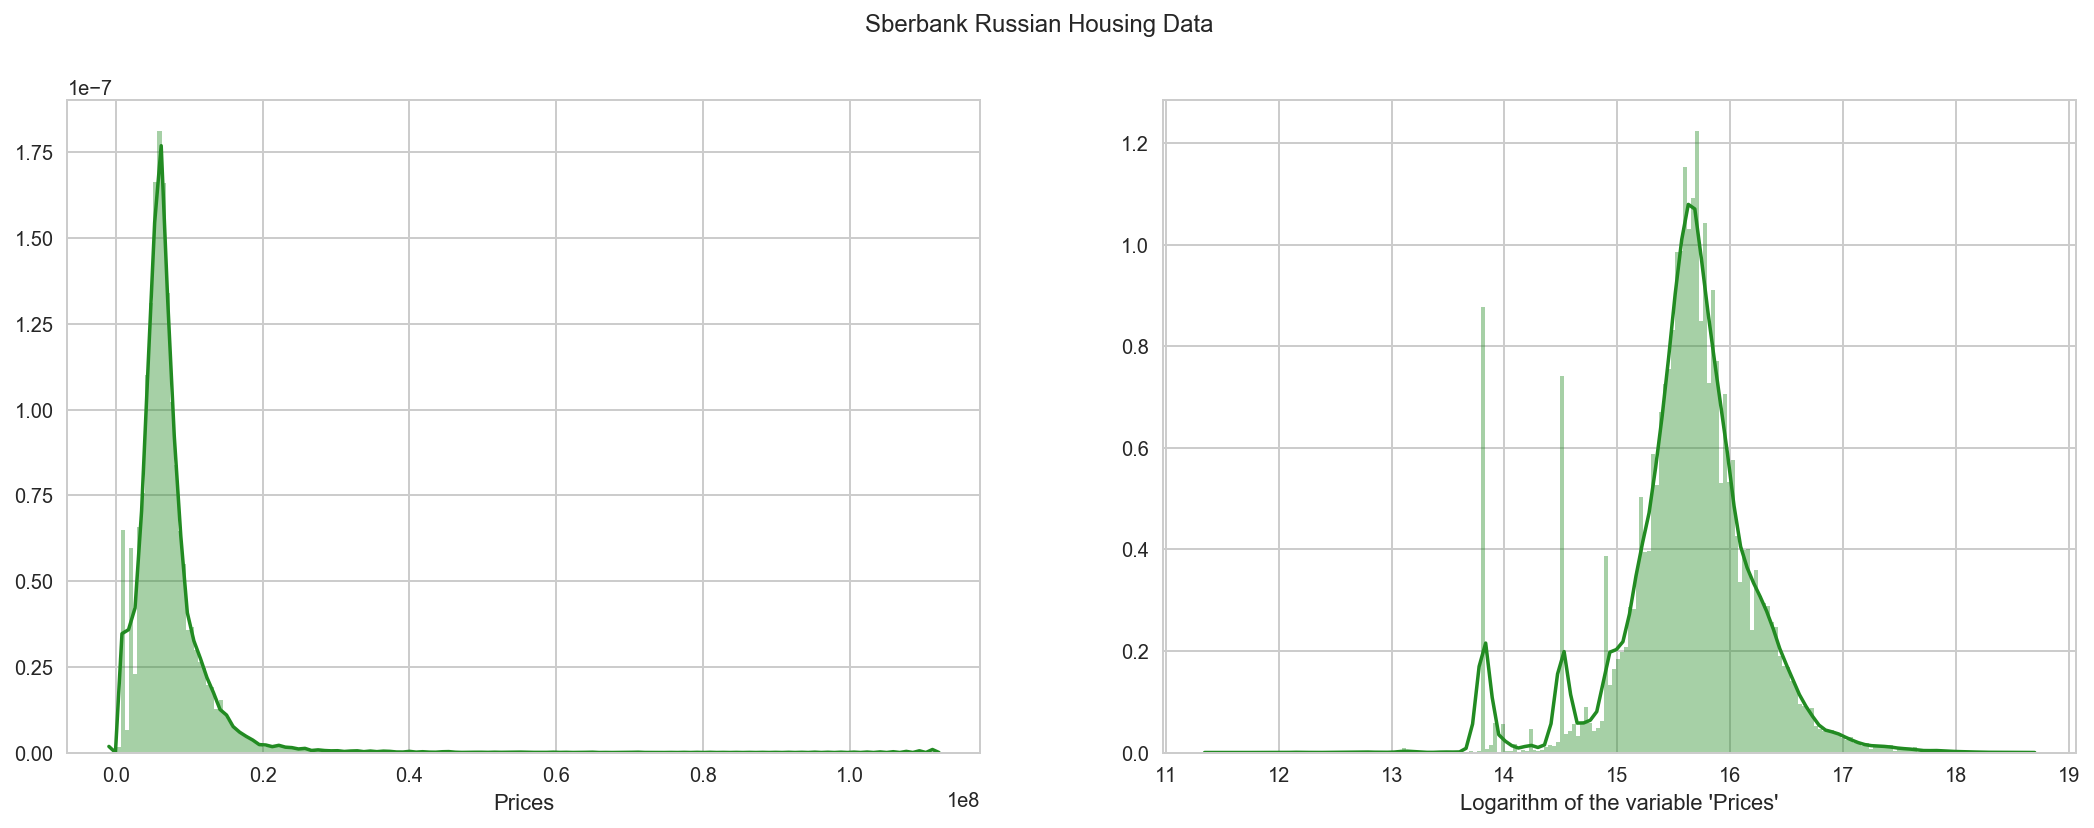

In [12]:
plt.style.use('seaborn-whitegrid')
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18, 6))

sns.distplot(target_train, bins=200, color='#228B22', ax=ax1)
ax1.set_xlabel("Prices")

sns.distplot(np.log(target_train), bins=200, color='#228B22', ax=ax2)
ax2.set_xlabel("Logarithm of the variable 'Prices'")

plt.suptitle('Sberbank Russian Housing Data');

In [15]:
print ("Sberbank Russian Housing Dataset Statistics: \n")
print ("Number of houses = ", len(target_train))
print ("Number of features = ", len(list(train[X_list_num+X_list_cat].keys())))
print ("Minimum house price = ", np.min(target_train))
print ("Maximum house price = ", np.max(target_train))
print ("Mean house price = ", "%.2f" % np.mean(target_train))
print ("Median house price = ", "%.2f" % np.median(target_train))
print ("Standard deviation of house prices =", "%.2f" % np.std(target_train))


Sberbank Russian Housing Dataset Statistics: 

Number of houses =  30471
Number of features =  44
Minimum house price =  100000
Maximum house price =  111111112
Mean house price =  7123035.28
Median house price =  6274411.00
Standard deviation of house prices = 4780032.89


### 3.2 Fill in Missing Values

In [16]:
train[X_list_num].isnull().sum()

timestamp                               0
full_sq                                 0
num_room                             9572
area_m                                  0
kremlin_km                              0
big_road2_km                            0
big_road1_km                            0
workplaces_km                           0
stadium_km                              0
swim_pool_km                            0
fitness_km                              0
detention_facility_km                   0
cemetery_km                             0
radiation_km                            0
oil_chemistry_km                        0
theater_km                              0
exhibition_km                           0
museum_km                               0
park_km                                 0
public_healthcare_km                    0
metro_min_walk                         25
metro_km_avto                           0
bus_terminal_avto_km                    0
public_transport_station_min_walk 

In [17]:
test[X_list_num].isnull().sum()

timestamp                             0
full_sq                               0
num_room                              0
area_m                                0
kremlin_km                            0
big_road2_km                          0
big_road1_km                          0
workplaces_km                         0
stadium_km                            0
swim_pool_km                          0
fitness_km                            0
detention_facility_km                 0
cemetery_km                           0
radiation_km                          0
oil_chemistry_km                      0
theater_km                            0
exhibition_km                         0
museum_km                             0
park_km                               0
public_healthcare_km                  0
metro_min_walk                       34
metro_km_avto                         0
bus_terminal_avto_km                  0
public_transport_station_min_walk     0
railroad_station_walk_min            34


In [18]:
df_train = pd.DataFrame(train, columns=X_list_num)
df_train_cat = pd.DataFrame(train, columns=X_list_num+X_list_cat)

df_test = pd.DataFrame(test, columns=X_list_num)
df_test_cat = pd.DataFrame(test, columns=X_list_num+X_list_cat)

df_train['prices'] = target_train
df_train_cat['prices'] = target_train

df_train = df_train.dropna(subset=['num_room'])
df_train_cat = df_train_cat.dropna(subset=['num_room'])

df_train['metro_min_walk'] = \
df_train['metro_min_walk'].interpolate(method='linear')
df_train_cat['metro_min_walk'] = \
df_train_cat['metro_min_walk'].interpolate(method='linear')

df_train['railroad_station_walk_min'] = \
df_train['railroad_station_walk_min'].interpolate(method='linear')
df_train_cat['railroad_station_walk_min'] = \
df_train_cat['railroad_station_walk_min'].interpolate(method='linear')

df_test['metro_min_walk'] = \
df_test['metro_min_walk'].interpolate(method='linear')
df_test_cat['metro_min_walk'] = \
df_test_cat['metro_min_walk'].interpolate(method='linear')

df_test['railroad_station_walk_min'] = \
df_test['railroad_station_walk_min'].interpolate(method='linear')
df_test_cat['railroad_station_walk_min'] = \
df_test_cat['railroad_station_walk_min'].interpolate(method='linear')

len(df_train)

20899

### 3.3 Macro and Categorical Features

In [21]:
# Add the Macro Feature
usdrub_pairs = dict(zip(list(macro['timestamp']), list(macro['usdrub'])))
# salary_pairs = dict(zip(list(macro['timestamp']), list(macro['salary'])))

df_train['timestamp'].replace(usdrub_pairs,inplace=True)
df_train_cat['timestamp'].replace(usdrub_pairs,inplace=True)

df_test['timestamp'].replace(usdrub_pairs,inplace=True)
df_test_cat['timestamp'].replace(usdrub_pairs,inplace=True)

df_train.rename(columns={'timestamp' : 'usdrub'}, inplace=True)
df_train_cat.rename(columns={'timestamp' : 'usdrub'}, inplace=True)

df_test.rename(columns={'timestamp' : 'usdrub'}, inplace=True)
df_test_cat.rename(columns={'timestamp' : 'usdrub'}, inplace=True)

In [22]:
# Preprocess Categorical Features
for df in [df_train_cat, df_test_cat]:
    print ("____________________________________________")
    
    print('sub area')
    print('Number of categories:', len(set(df['sub_area'])))
    print(set(df['sub_area']))

    print('\nID metro')
    print('Number of categories:', len(set(df['ID_metro'])))
    print(set(df['ID_metro']))

    print('\noffice raion')
    print('Number of categories:', len(set(df['office_raion'])))
    print(set(df['office_raion']))

    print('\nsport objects raion')
    print('Number of categories:', len(set(df['sport_objects_raion'])))
    print(set(df_train_cat['sport_objects_raion']))

    print('\nraion popul')
    print('Number of categories:', len(set(df['raion_popul'])))
    print(set(df['raion_popul']))

    print('\nhealthcare centers raion')
    print('Number of categories:', len(set(df_train_cat['healthcare_centers_raion'])))
    print(set(df['healthcare_centers_raion']))

    print('\nschool education centers raion')
    print('Number of categories:', len(set(df['school_education_centers_raion'])))
    print(set(df['school_education_centers_raion']))

    print('\npreschool education centers raion')
    print('Number of categories:', len(set(df['preschool_education_centers_raion'])))
    print(set(df['preschool_education_centers_raion']))

____________________________________________
sub area
Number of categories: 146
{'Orehovo-Borisovo Severnoe', 'Chertanovo Juzhnoe', 'Dmitrovskoe', 'Severnoe Izmajlovo', 'Presnenskoe', "Altuf'evskoe", 'Poselenie Pervomajskoe', 'Nekrasovka', 'Poselenie Kievskij', 'Brateevo', 'Pokrovskoe Streshnevo', 'Nagatino-Sadovniki', 'Veshnjaki', 'Koptevo', 'Vostochnoe Degunino', 'Meshhanskoe', 'Solncevo', 'Kuncevo', 'Troparevo-Nikulino', 'Begovoe', 'Nizhegorodskoe', 'Beskudnikovskoe', 'Lianozovo', 'Izmajlovo', 'Poselenie Kokoshkino', 'Krylatskoe', 'Alekseevskoe', 'Kapotnja', 'Lefortovo', 'Savelki', 'Poselenie Shhapovskoe', 'Sokol', 'Nagornoe', 'Hamovniki', 'Birjulevo Vostochnoe', 'Poselenie Mosrentgen', "Kon'kovo", 'Horoshevo-Mnevniki', 'Novo-Peredelkino', 'Zapadnoe Degunino', 'Losinoostrovskoe', 'Filevskij Park', 'Pechatniki', 'Teplyj Stan', 'Ajeroport', 'Ochakovo-Matveevskoe', "Mar'ina Roshha", 'Molzhaninovskoe', 'Ljublino', 'Rjazanskij', 'Juzhnoportovoe', 'Ivanovskoe', 'Fili Davydkovo', 'Golovins

In [23]:
for feature in X_list_cat:
    for element in list(set(df_test_cat[feature])):
        if element not in list(set(df_train_cat[feature])): 
            print (feature, element)

ID_metro 224


In [24]:
ID_metro_cat = pd.factorize(df_train_cat['ID_metro'])
df_train_cat['ID_metro'] = ID_metro_cat[0]

ID_metro_pairs = dict(zip(list(ID_metro_cat[1]), list(set(ID_metro_cat[0]))))
ID_metro_pairs[224] = 219

df_test_cat['ID_metro'].replace(ID_metro_pairs,inplace=True)

In [25]:
for feature in X_list_cat:
    if feature !='ID_metro':
        feature_cat = pd.factorize(df_train_cat[feature])
        df_train_cat[feature] = feature_cat[0]
        feature_pairs = dict(zip(list(feature_cat[1]), list(set(feature_cat[0]))))
        df_test_cat[feature].replace(feature_pairs,inplace=True)

In [26]:
for df in [df_train_cat, df_test_cat]:
    print ("____________________________________________")
    
    print('sub area')
    print('Number of categories:', len(set(df['sub_area'])))
    print(set(df['sub_area']))

    print('\nID metro')
    print('Number of categories:', len(set(df['ID_metro'])))
    print(set(df['ID_metro']))

    print('\noffice raion')
    print('Number of categories:', len(set(df['office_raion'])))
    print(set(df['office_raion']))

    print('\nsport objects raion')
    print('Number of categories:', len(set(df['sport_objects_raion'])))
    print(set(df_train_cat['sport_objects_raion']))

    print('\nraion popul')
    print('Number of categories:', len(set(df['raion_popul'])))
    print(set(df['raion_popul']))

    print('\nhealthcare centers raion')
    print('Number of categories:', len(set(df_train_cat['healthcare_centers_raion'])))
    print(set(df['healthcare_centers_raion']))

    print('\nschool education centers raion')
    print('Number of categories:', len(set(df['school_education_centers_raion'])))
    print(set(df['school_education_centers_raion']))

    print('\npreschool education centers raion')
    print('Number of categories:', len(set(df['preschool_education_centers_raion'])))
    print(set(df['preschool_education_centers_raion']))

____________________________________________
sub area
Number of categories: 146
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145}

ID metro
Number of categories: 219
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 

In [27]:
df_train_cat1 = df_train_cat
encode = OneHotEncoder(sparse=False)

for column in X_list_cat:
    encode.fit(df_train_cat[[column]])
    transform = encode.transform(df_train_cat[[column]])
    
    transform = pd.DataFrame(transform, 
                             columns=[(column+"_"+str(i)) for i in df_train_cat[column].value_counts().index])
    transform = transform.set_index(df_train_cat.index.values)
    
    df_train_cat1 = pd.concat([df_train_cat1, transform], axis=1)
    df_train_cat1 = df_train_cat1.drop(column, 1)

In [28]:
df_test_cat1 = df_test_cat
encode = OneHotEncoder(sparse=False)

for column in X_list_cat:
    encode.fit(df_test_cat[[column]])
    transform = encode.transform(df_test_cat[[column]])
    
    transform = pd.DataFrame(transform, 
                             columns=[(column+"_"+str(i)) for i in df_test_cat[column].value_counts().index])
    transform = transform.set_index(df_test_cat.index.values)
    
    df_test_cat1 = pd.concat([df_test_cat1, transform], axis=1)
    df_test_cat1 = df_test_cat1.drop(column, 1)

In [29]:
# Check Encoding
df_train_cat1.iloc[:, 623:636][:3].as_matrix()

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [30]:
df_train_cat['preschool_education_centers_raion'][:3]

7672    0
8056    1
8111    2
Name: preschool_education_centers_raion, dtype: int64

In [31]:
print('Shape of the train data frame:', df_train_cat1.shape)
print('Shape of the test data frame:', df_test_cat1.shape)

Shape of the train data frame: (20899, 636)
Shape of the test data frame: (7662, 626)


In [32]:
print("Features in the train data, but not in the test data:")
for element in list(df_train_cat1):
    if element not in list(df_test_cat1):
        print(element)

Features in the train data, but not in the test data:
prices
sub_area_136
ID_metro_188
ID_metro_205
ID_metro_216
ID_metro_214
ID_metro_183
ID_metro_179
ID_metro_153
ID_metro_217
raion_popul_136


In [33]:
print("Features in the test data, but not in the train data:")
for element in list(df_test_cat1):
    if element not in list(df_train_cat1):
        print(element)

Features in the test data, but not in the train data:
ID_metro_219


In [34]:
for column in ['sub_area_136',' ID_metro_188', 'ID_metro_205', 'ID_metro_216', 'ID_metro_214',
              'ID_metro_183',' ID_metro_179', 'ID_metro_153', 'ID_metro_217', 'raion_popul_136']:
    df_test_cat1[column] = 0
    
df_train_cat1['ID_metro_219'] = 0

print('Columns with zero values were added.\n')
print('Shape of the train data frame:', df_train_cat1.shape)
print('Shape of the test data frame:', df_test_cat1.shape)

Columns with zero values were added.

Shape of the train data frame: (20899, 637)
Shape of the test data frame: (7662, 636)


### 3.4 Display Correlation

In [35]:
pearson = df_train.corr(method='pearson')
corr_with_prices = pearson.ix[-1][:-1]
corr_with_prices[abs(corr_with_prices).argsort()[::-1]]

full_sq                              0.593829
num_room                             0.476337
kremlin_km                          -0.290126
stadium_km                          -0.238431
detention_facility_km               -0.233395
university_km                       -0.222964
theater_km                          -0.222873
workplaces_km                       -0.220889
swim_pool_km                        -0.220480
exhibition_km                       -0.212144
radiation_km                        -0.208256
museum_km                           -0.203846
park_km                             -0.201636
metro_min_walk                      -0.200058
fitness_km                          -0.197702
metro_km_avto                       -0.194751
shopping_centers_km                 -0.182459
public_healthcare_km                -0.182388
big_road2_km                        -0.178865
bus_terminal_avto_km                -0.176601
ekder_all                            0.169331
area_m                            

In [37]:
top_features_list = corr_with_prices[abs(corr_with_prices).argsort()[::-1]][:16].index.values.tolist()
print(top_features_list)

['full_sq', 'num_room', 'kremlin_km', 'stadium_km', 'detention_facility_km', 'university_km', 'theater_km', 'workplaces_km', 'swim_pool_km', 'exhibition_km', 'radiation_km', 'museum_km', 'park_km', 'metro_min_walk', 'fitness_km', 'metro_km_avto']


### 3.5 Scale, Shuffle and Split the Data

In [38]:
target_train = df_train['prices'].as_matrix()

features_train = df_train.drop('prices', 1).as_matrix()
features_test = df_test.as_matrix()

features_train_cat = df_train_cat.drop('prices', 1).as_matrix()
features_test_cat = df_test_cat.as_matrix()

features_train_cat_enc = df_train_cat1.drop('prices', 1).as_matrix()
features_test_cat_enc = df_test_cat1.as_matrix()

In [39]:
print('Numeric Features')
X_train, X_test, y_train, y_test = \
train_test_split(features_train, target_train, test_size = 0.2, random_state = 1)
X_train.shape, X_test.shape

Numeric Features


((16719, 36), (4180, 36))

In [40]:
print('Numeric and Categorical Features')
X_train_cat, X_test_cat, y_train_cat, y_test_cat = \
train_test_split(features_train_cat, target_train, test_size = 0.2, random_state = 1)
X_train_cat.shape, X_test_cat.shape

Numeric and Categorical Features


((16719, 44), (4180, 44))

In [41]:
print('Numeric and Encoded Categorical Features')
X_train_cat_enc, X_test_cat_enc, y_train_cat_enc, y_test_cat_enc = \
train_test_split(features_train_cat_enc, target_train, test_size = 0.2, random_state = 1)
X_train_cat_enc.shape, X_test_cat_enc.shape

Numeric and Encoded Categorical Features


((16719, 636), (4180, 636))

In [42]:
scale_X = RobustScaler()
X_train = scale_X.fit_transform(X_train)
X_test = scale_X.transform(X_test)

scale_y = RobustScaler()
y_train = scale_y.fit_transform(y_train.reshape(-1,1))
y_test = scale_y.transform(y_test.reshape(-1,1))

scale_X_cat = RobustScaler()
X_train_cat = scale_X_cat.fit_transform(X_train_cat)
X_test_cat = scale_X_cat.transform(X_test_cat)

scale_y_cat = RobustScaler()
y_train_cat = scale_y_cat.fit_transform(y_train_cat.reshape(-1,1))
y_test_cat = scale_y_cat.transform(y_test_cat.reshape(-1,1))

scale_X_cat_enc = RobustScaler()
X_train_cat_enc = scale_X_cat_enc.fit_transform(X_train_cat_enc)
X_test_cat_enc = scale_X_cat_enc.transform(X_test_cat_enc)

scale_y_cat_enc = RobustScaler()
y_train_cat_enc = scale_y_cat_enc.fit_transform(y_train_cat_enc.reshape(-1,1))
y_test_cat_enc = scale_y_cat_enc.transform(y_test_cat_enc.reshape(-1,1))

## 4. Benchmark Models
### 4.1 Regressors; Scikit-Learn
#### Tuning Parameters

In [43]:
print('Numeric Features')
print ('Gradient Boosting Regressor')
param_grid_gbr = {'max_depth': [3, 4, 5], 'n_estimators': range(36, 361, 36)}
gridsearch_gbr = GridSearchCV(GradientBoostingRegressor(), 
                              param_grid_gbr, n_jobs=5).fit(X_train, y_train)

gridsearch_gbr.best_params_

Numeric Features
Gradient Boosting Regressor


{'max_depth': 4, 'n_estimators': 216}

In [ ]:
print ('Bagging Regressor')
param_grid_br = {'n_estimators': range(36, 361, 36)}
gridsearch_br = GridSearchCV(BaggingRegressor(), 
                             param_grid_br, n_jobs=5).fit(X_train, y_train)

gridsearch_br.best_params_

In [ ]:
print('Numeric and Categorical Features')
print ('Gradient Boosting Regressor')
param_grid_gbr_cat = {'max_depth': [3, 4, 5], 'n_estimators': range(44, 441, 44)}
gridsearch_gbr_cat = GridSearchCV(GradientBoostingRegressor(), 
                                  param_grid_gbr_cat, n_jobs=5).fit(X_train_cat, y_train_cat)

gridsearch_gbr_cat.best_params_

In [ ]:
print ('Bagging Regressor')
param_grid_br_cat = {'n_estimators': range(44, 441, 44)}
gridsearch_br_cat = GridSearchCV(BaggingRegressor(), 
                                 param_grid_br_cat, n_jobs=5).fit(X_train_cat, y_train_cat)

gridsearch_br_cat.best_params_

In [ ]:
print('Numeric and Encoded Categorical Features')
print ('Gradient Boosting Regressor')
param_grid_gbr_cat_enc = {'max_depth': [3, 4, 5], 'n_estimators': [159, 318, 636]}
gridsearch_gbr_cat_enc = GridSearchCV(GradientBoostingRegressor(), 
                                      param_grid_gbr_cat_enc, 
                                      n_jobs=5).fit(X_train_cat_enc, y_train_cat_enc)

gridsearch_gbr_cat_enc.best_params_

In [ ]:
print ('Bagging Regressor')
param_grid_br_cat_enc = {'n_estimators': [159, 318, 636]}
gridsearch_br_cat_enc = GridSearchCV(BaggingRegressor(), 
                                     param_grid_br_cat_enc, 
                                     n_jobs=5).fit(X_train_cat_enc, y_train_cat_enc)

gridsearch_br_cat_enc.best_params_

#### Fit the Regressors

In [44]:
print('Numeric Features')
y_train_gbr, y_test_gbr = regression(GradientBoostingRegressor(max_depth=4, n_estimators=216), 
                                     X_train, X_test, y_train)

y_train_br, y_test_br = regression(BaggingRegressor(n_estimators=252), 
                                   X_train, X_test, y_train)

scores('GradientBoostingRegressor', y_train, y_test, y_train_gbr, y_test_gbr)
scores('BaggingRegressor', y_train, y_test, y_train_br, y_test_br)

Numeric Features
_______________________________________
GradientBoostingRegressor
_______________________________________
EV score. Train:  0.831379132614
EV score. Test:  0.722620570847
---------
R2 score. Train:  0.831379132614
R2 score. Test:  0.722547684361
---------
MSE score. Train:  0.306650462824
MSE score. Test:  0.555155416429
---------
MAE score. Train:  0.343499699946
MAE score. Test:  0.403613149286
---------
MdAE score. Train:  0.184974044477
MdAE score. Test:  0.201730438151
_______________________________________
BaggingRegressor
_______________________________________
EV score. Train:  0.955573010387
EV score. Test:  0.72125683237
---------
R2 score. Train:  0.955540124303
R2 score. Test:  0.720809724294
---------
MSE score. Train:  0.0808538211843
MSE score. Test:  0.558632907479
---------
MAE score. Train:  0.147394225217
MAE score. Test:  0.391975258998
---------
MdAE score. Train:  0.0644892463992
MdAE score. Test:  0.178006884717


In [45]:
print('Numeric and Categorical Features')
y_train_cat_gbr, y_test_cat_gbr = \
regression(GradientBoostingRegressor(max_depth=3, n_estimators=396), X_train_cat, X_test_cat, y_train_cat)

y_train_cat_br, y_test_cat_br = \
regression(BaggingRegressor(n_estimators=220), X_train_cat, X_test_cat, y_train_cat)

scores('GradientBoostingRegressor', 
       y_train_cat, y_test_cat, y_train_cat_gbr, y_test_cat_gbr)
scores('BaggingRegressor', 
       y_train_cat, y_test_cat, y_train_cat_br, y_test_cat_br)

Numeric and Categorical Features
_______________________________________
GradientBoostingRegressor
_______________________________________
EV score. Train:  0.819256487057
EV score. Test:  0.716312615052
---------
R2 score. Train:  0.819256487057
R2 score. Test:  0.716227966546
---------
MSE score. Train:  0.328696458248
MSE score. Test:  0.567800564361
---------
MAE score. Train:  0.352419590753
MAE score. Test:  0.407636587921
---------
MdAE score. Train:  0.190394737254
MdAE score. Test:  0.204666173255
_______________________________________
BaggingRegressor
_______________________________________
EV score. Train:  0.955726827078
EV score. Test:  0.72084335789
---------
R2 score. Train:  0.955705877839
R2 score. Test:  0.720453646992
---------
MSE score. Train:  0.0805523851922
MSE score. Test:  0.559345383937
---------
MAE score. Train:  0.147433279022
MAE score. Test:  0.392721454757
---------
MdAE score. Train:  0.0632280296717
MdAE score. Test:  0.177734719066


In [46]:
print('Numeric and Encoded Categorical Features')
y_train_cat_enc_gbr, y_test_cat_enc_gbr = \
regression(GradientBoostingRegressor(max_depth=3, n_estimators=159), 
           X_train_cat_enc, X_test_cat_enc, y_train_cat_enc)

y_train_cat_enc_br, y_test_cat_enc_br = \
regression(BaggingRegressor(n_estimators=159), 
           X_train_cat_enc, X_test_cat_enc, y_train_cat_enc)

scores('GradientBoostingRegressor', 
       y_train_cat_enc, y_test_cat_enc, y_train_cat_enc_gbr, y_test_cat_enc_gbr)
scores('BaggingRegressor', 
       y_train_cat_enc, y_test_cat_enc, y_train_cat_enc_br, y_test_cat_enc_br)

Numeric and Encoded Categorical Features
_______________________________________
GradientBoostingRegressor
_______________________________________
EV score. Train:  0.769881646987
EV score. Test:  0.708744553638
---------
R2 score. Train:  0.769881646987
R2 score. Test:  0.708698460836
---------
MSE score. Train:  0.418488533179
MSE score. Test:  0.582866381592
---------
MAE score. Train:  0.390531067732
MAE score. Test:  0.420075687227
---------
MdAE score. Train:  0.205749300262
MdAE score. Test:  0.21778188135
_______________________________________
BaggingRegressor
_______________________________________
EV score. Train:  0.9559524829
EV score. Test:  0.717498003689
---------
R2 score. Train:  0.955925225462
R2 score. Test:  0.717068286326
---------
MSE score. Train:  0.0801534840885
MSE score. Test:  0.566119165247
---------
MAE score. Train:  0.148051092995
MAE score. Test:  0.392918840482
---------
MdAE score. Train:  0.0643800157233
MdAE score. Test:  0.178678497554


#### MLP Regressors

In [47]:
mlpr = MLPRegressor(hidden_layer_sizes=(324,), max_iter=200, 
                    solver='lbfgs', alpha=0.01)
mlpr.fit(X_train, y_train)

y_train_mlpr = mlpr.predict(X_train)
y_test_mlpr = mlpr.predict(X_test)

scores('MLP Regressor; Numeric Features', 
       y_train, y_test, y_train_mlpr, y_test_mlpr)

_______________________________________
MLP Regressor; Numeric Features
_______________________________________
EV score. Train:  0.69712297008
EV score. Test:  0.681323796484
---------
R2 score. Train:  0.69699723523
R2 score. Test:  0.680969571288
---------
MSE score. Train:  0.551034634647
MSE score. Test:  0.638349224433
---------
MAE score. Train:  0.429853127078
MAE score. Test:  0.448812151476
---------
MdAE score. Train:  0.241143631862
MdAE score. Test:  0.252277572295


In [48]:
mlpr_cat = MLPRegressor(hidden_layer_sizes=(396,), max_iter=200, 
                        solver='lbfgs', alpha=0.01)
mlpr_cat.fit(X_train_cat, y_train_cat)

y_train_cat_mlpr = mlpr_cat.predict(X_train_cat)
y_test_cat_mlpr = mlpr_cat.predict(X_test_cat)

scores('MLP Regressor; Numeric and Categorical Features', 
       y_train_cat, y_test_cat, y_train_cat_mlpr, y_test_cat_mlpr)

_______________________________________
MLP Regressor; Numeric and Categorical Features
_______________________________________
EV score. Train:  0.71659794212
EV score. Test:  0.689279894564
---------
R2 score. Train:  0.716597024607
R2 score. Test:  0.689152533367
---------
MSE score. Train:  0.515390858304
MSE score. Test:  0.621975903812
---------
MAE score. Train:  0.413158615406
MAE score. Test:  0.437974860647
---------
MdAE score. Train:  0.223515856502
MdAE score. Test:  0.23878764401


In [49]:
mlpr_cat_enc = MLPRegressor(hidden_layer_sizes=(318,), max_iter=200, 
                            solver='lbfgs', alpha=0.01)
mlpr_cat_enc.fit(X_train_cat_enc, y_train_cat_enc)

y_train_cat_enc_mlpr = mlpr_cat_enc.predict(X_train_cat_enc)
y_test_cat_enc_mlpr = mlpr_cat_enc.predict(X_test_cat_enc)

scores('MLP Regressor; Numeric and Encoded Categorical Features', 
       y_train_cat_enc, y_test_cat_enc, y_train_cat_enc_mlpr, y_test_cat_enc_mlpr)

_______________________________________
MLP Regressor; Numeric and Encoded Categorical Features
_______________________________________
EV score. Train:  0.76258410509
EV score. Test:  0.688659889218
---------
R2 score. Train:  0.762577536312
R2 score. Test:  0.688609829687
---------
MSE score. Train:  0.431771639556
MSE score. Test:  0.623061801715
---------
MAE score. Train:  0.396366179851
MAE score. Test:  0.445312424708
---------
MdAE score. Train:  0.219753884136
MdAE score. Test:  0.236214616025


#### Display Predictions

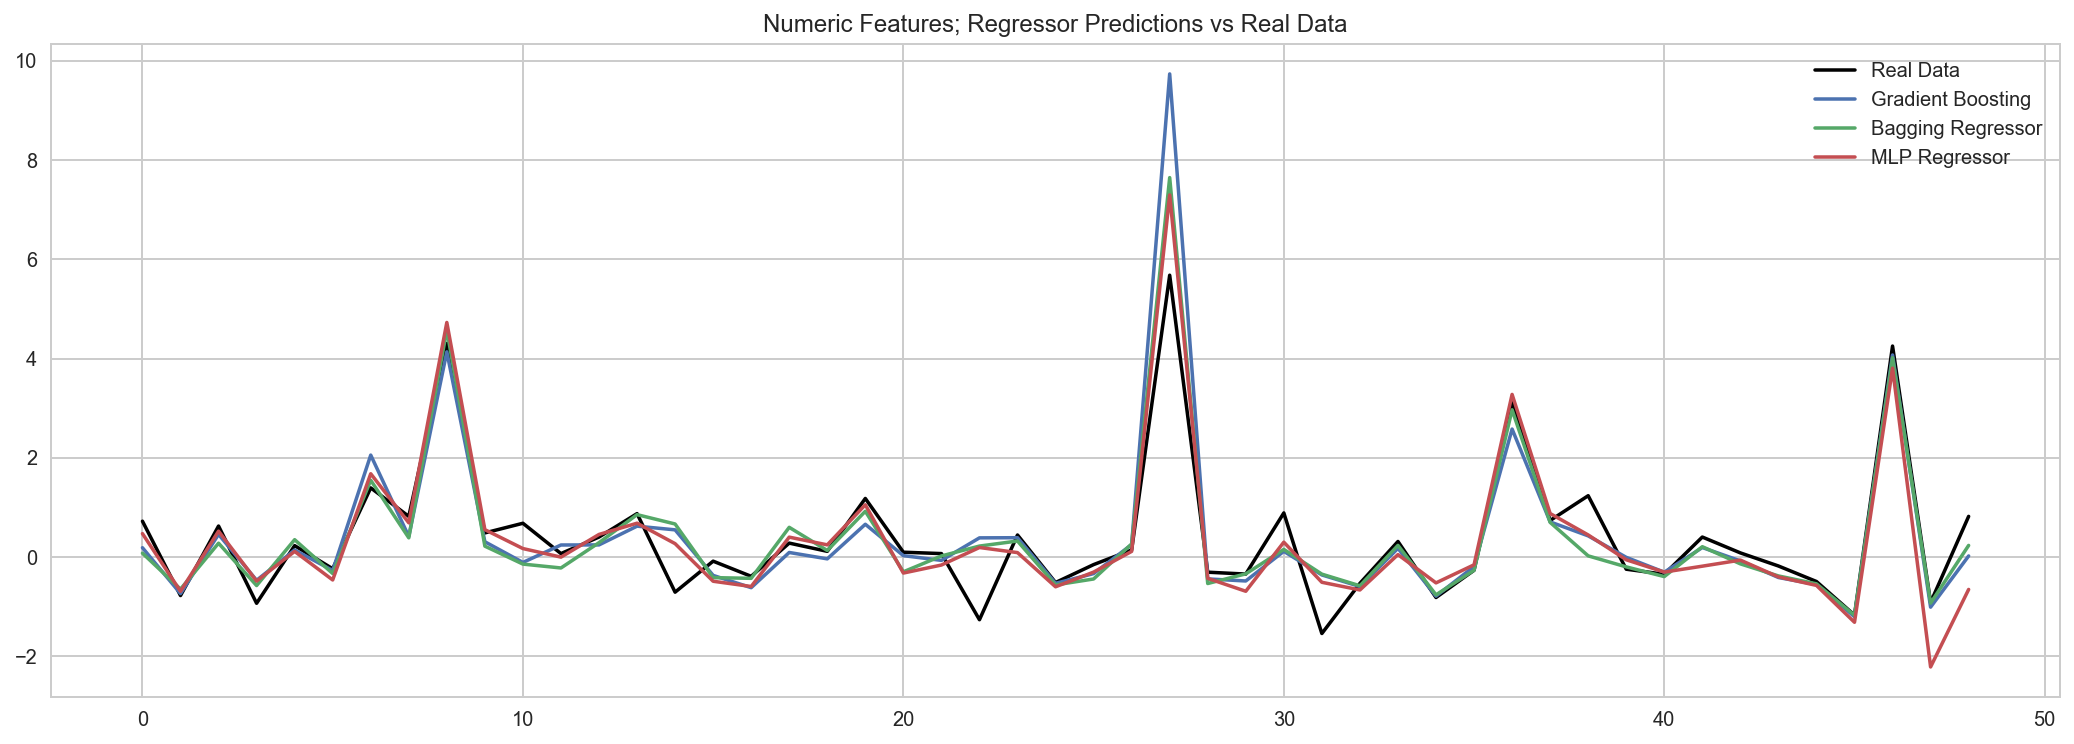

In [50]:
plt.figure(figsize = (18, 6))

plt.plot(y_test[1:50], color = 'black', label='Real Data')

plt.plot(y_test_gbr[1:50], label='Gradient Boosting')
plt.plot(y_test_br[1:50], label='Bagging Regressor')
plt.plot(y_test_mlpr[1:50], label='MLP Regressor')

plt.legend()
plt.title("Numeric Features; Regressor Predictions vs Real Data");

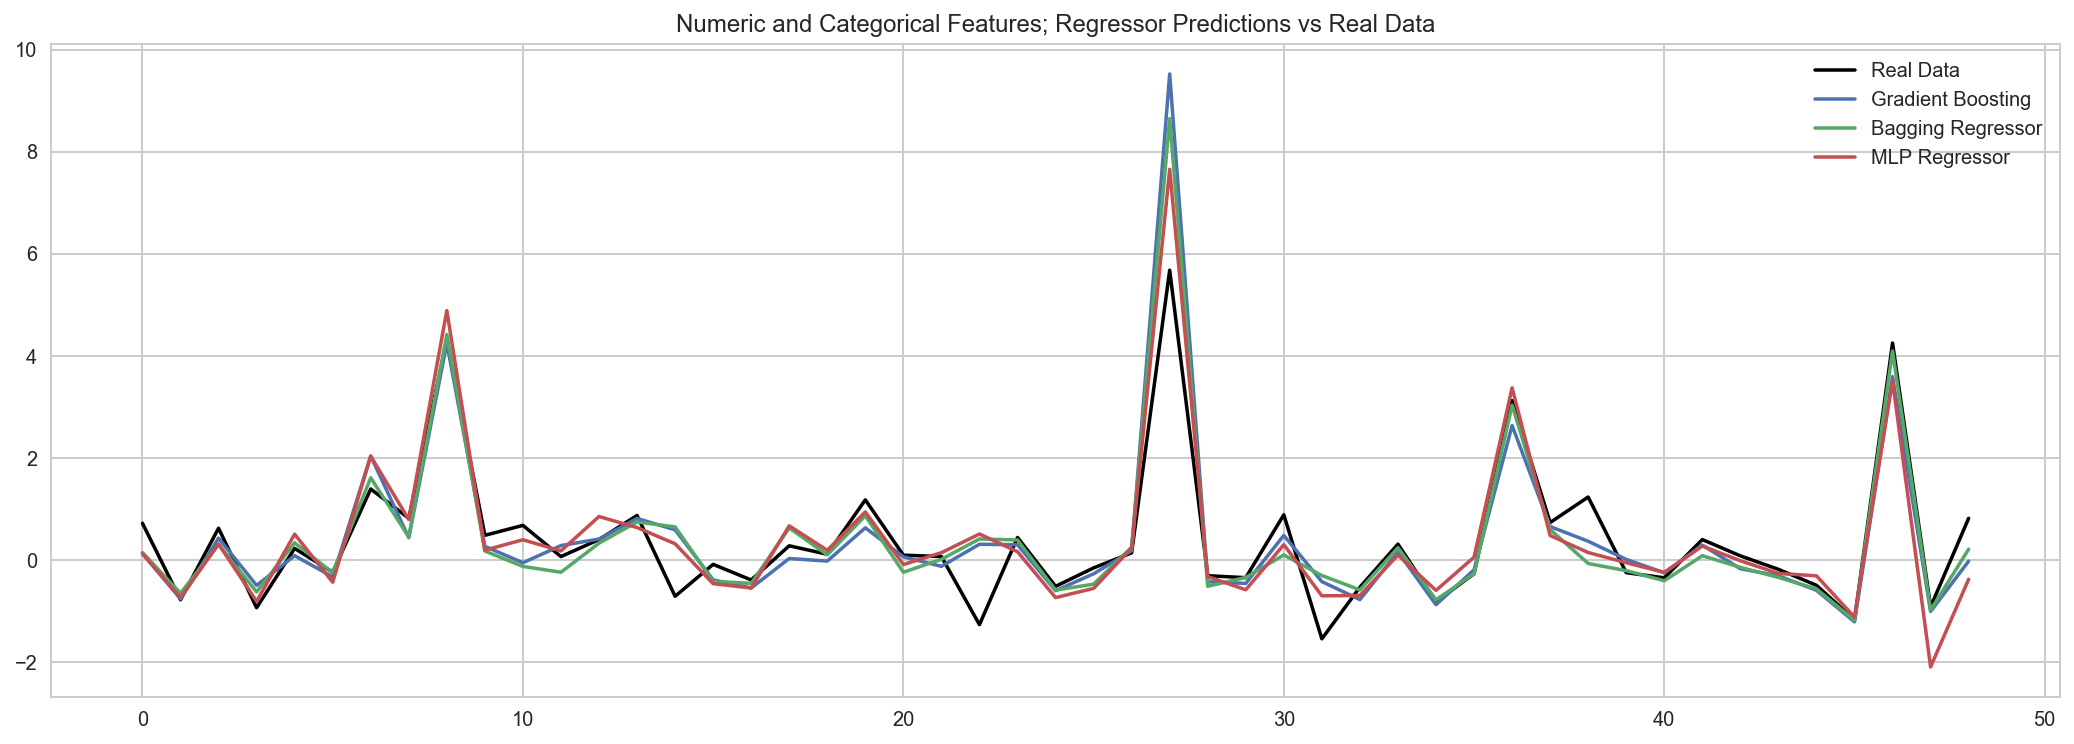

In [51]:
plt.figure(figsize = (18, 6))

plt.plot(y_test_cat[1:50], color = 'black', label='Real Data')

plt.plot(y_test_cat_gbr[1:50], label='Gradient Boosting')
plt.plot(y_test_cat_br[1:50], label='Bagging Regressor')
plt.plot(y_test_cat_mlpr[1:50], label='MLP Regressor')

plt.legend()
plt.title("Numeric and Categorical Features; Regressor Predictions vs Real Data");

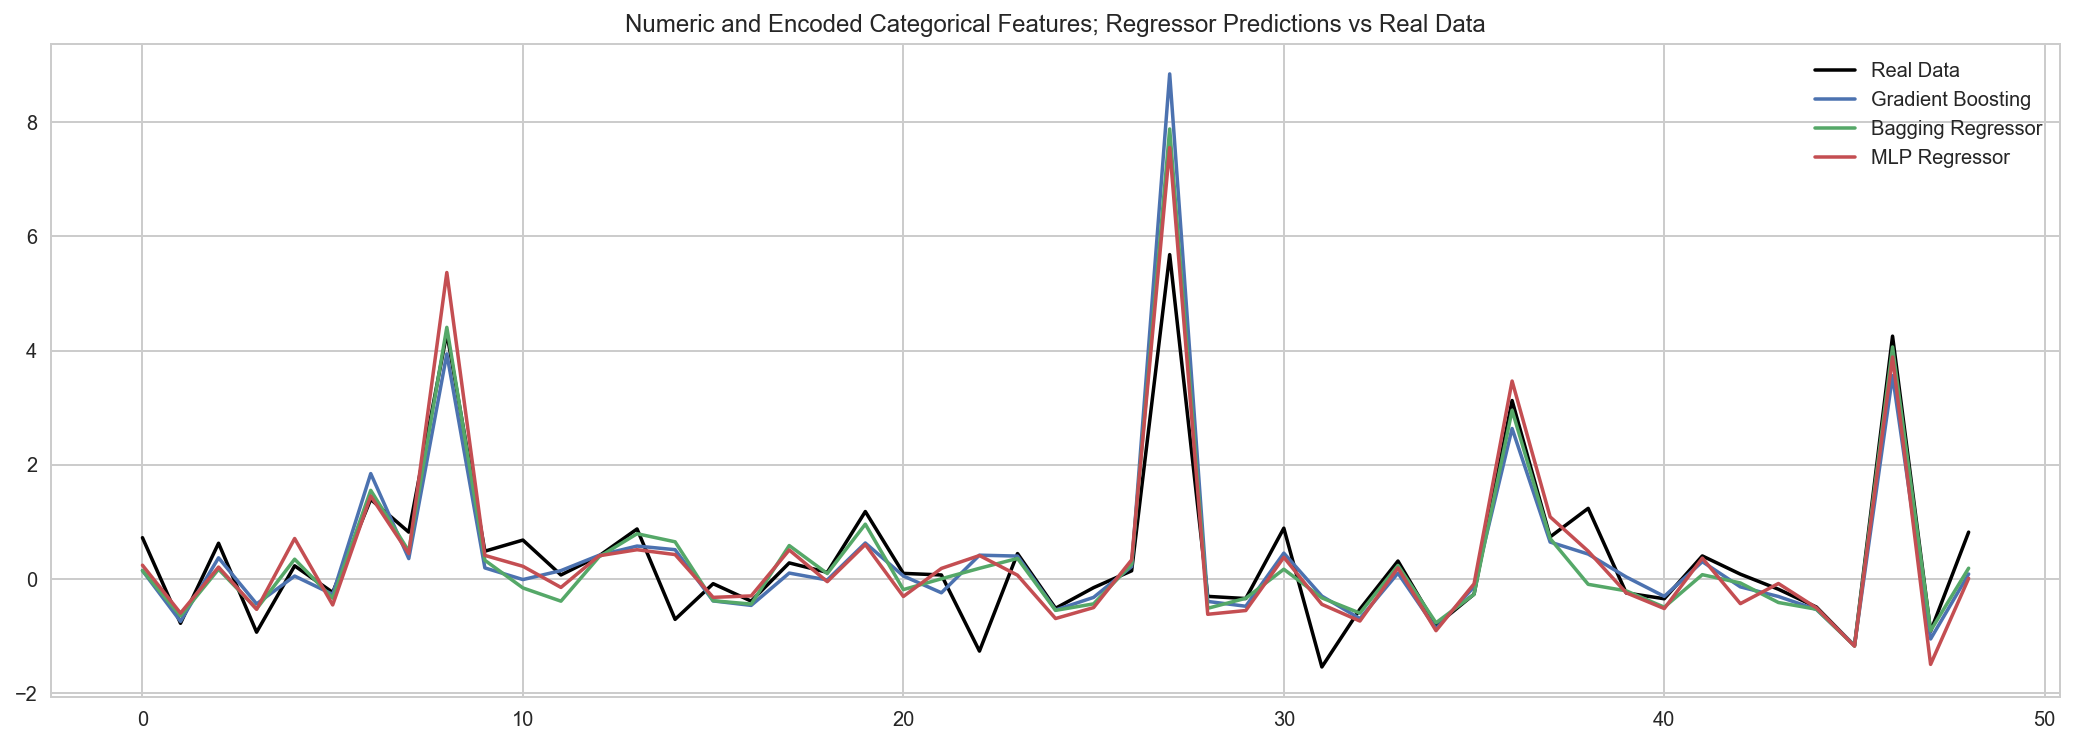

In [52]:
plt.figure(figsize = (18, 6))

plt.plot(y_test_cat_enc[1:50], color = 'black', label='Real Data')

plt.plot(y_test_cat_enc_gbr[1:50], label='Gradient Boosting')
plt.plot(y_test_cat_enc_br[1:50], label='Bagging Regressor')
plt.plot(y_test_cat_enc_mlpr[1:50], label='MLP Regressor')

plt.legend()
plt.title("Numeric and Encoded Categorical Features; Regressor Predictions vs Real Data");

### 4.2 Neural Networks
#### MLP

In [53]:
def mlp_model():
    model = Sequential()
    
    model.add(Dense(1152, activation='relu', input_dim=36))   
    model.add(Dense(288, activation='relu'))    
    model.add(Dense(72, activation='relu'))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [54]:
mlp_model = mlp_model()
mlp_checkpointer = ModelCheckpoint(filepath='weights.best.mlp_reg.sberbank.hdf5', 
                                   verbose=2, save_best_only=True)

mlp_history = mlp_model.fit(X_train, y_train, validation_data=(X_test, y_test),
                            nb_epoch=10, batch_size=128, verbose=0, callbacks=[mlp_checkpointer])

Epoch 00000: val_loss improved from inf to 0.69990, saving model to weights.best.mlp_reg.sberbank.hdf5
Epoch 00001: val_loss improved from 0.69990 to 0.68781, saving model to weights.best.mlp_reg.sberbank.hdf5
Epoch 00002: val_loss improved from 0.68781 to 0.61596, saving model to weights.best.mlp_reg.sberbank.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss did not improve


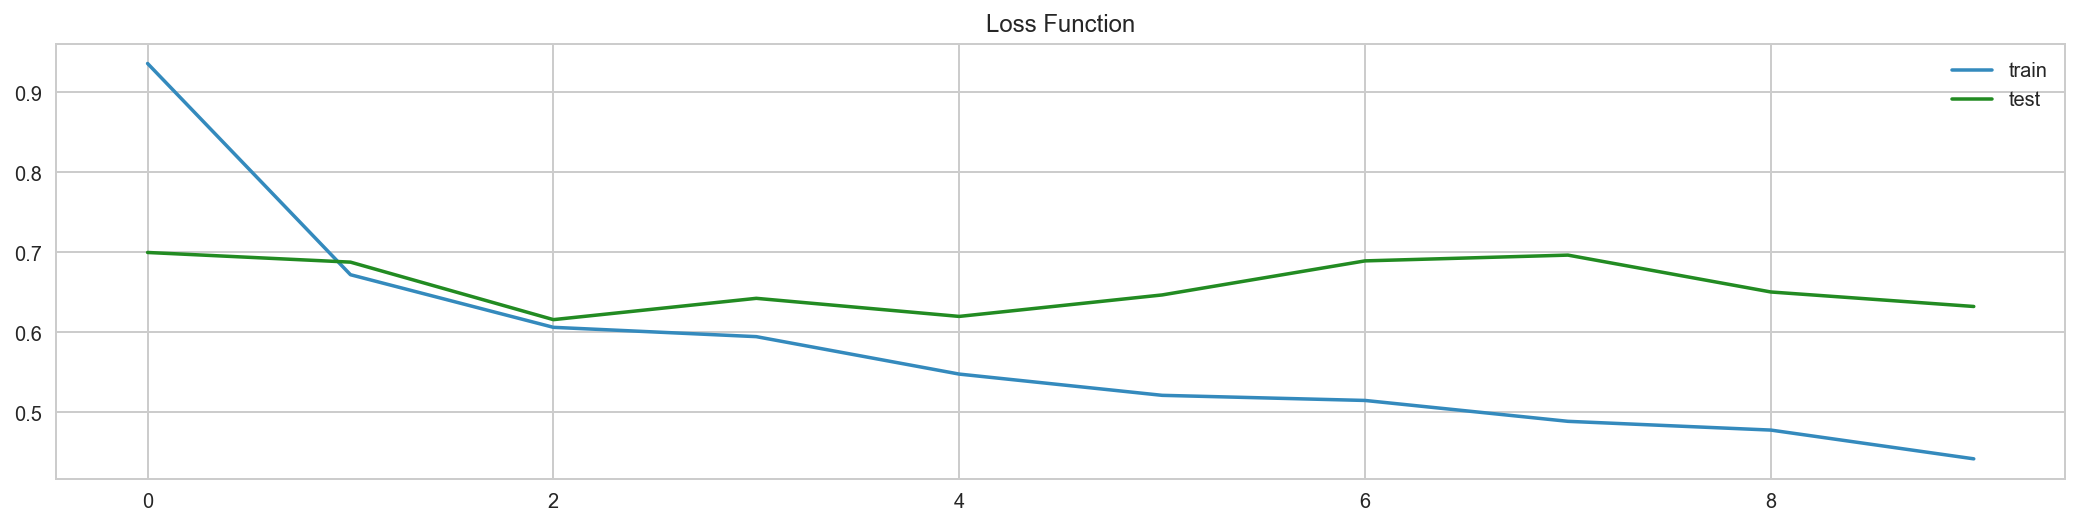

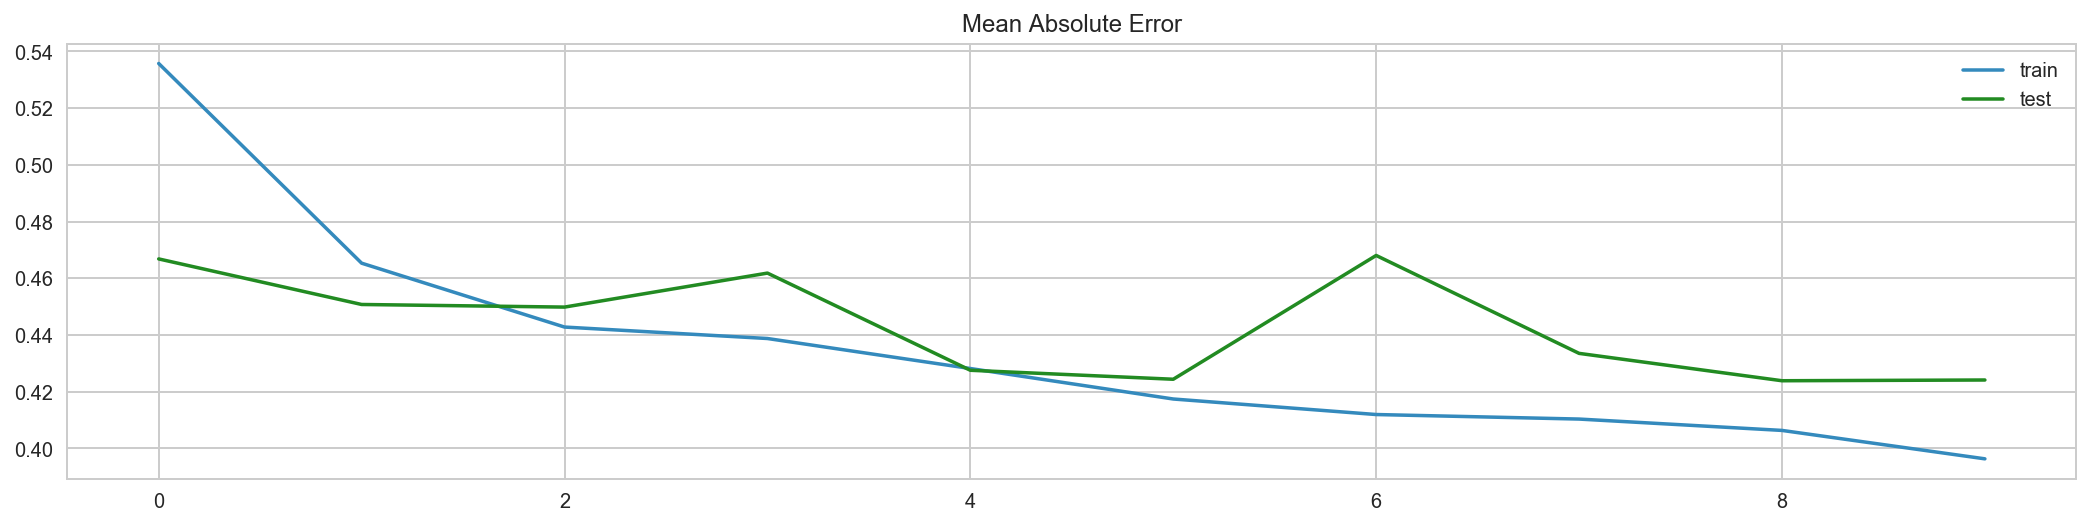

In [55]:
loss_plot(mlp_history)
mae_plot(mlp_history)

In [56]:
mlp_model.load_weights('weights.best.mlp_reg.sberbank.hdf5')

y_train_mlp = mlp_model.predict(X_train)
y_test_mlp = mlp_model.predict(X_test)

scores('MLP Model; Numeric Features', y_train, y_test, y_train_mlp, y_test_mlp)

_______________________________________
MLP Model; Numeric Features
_______________________________________
EV score. Train:  0.691433154985
EV score. Test:  0.692617922664
---------
R2 score. Train:  0.691189173612
R2 score. Test:  0.692161466006
---------
MSE score. Train:  0.561597056788
MSE score. Test:  0.615955318804
---------
MAE score. Train:  0.43471662806
MAE score. Test:  0.449846562538
---------
MdAE score. Train:  0.244068416754
MdAE score. Test:  0.250771793971


In [57]:
mlp_model.save('kaggle_sberbank_mlp_reg_model.h5')

In [58]:
def mlp_cat_model():
    model = Sequential()
    
    model.add(Dense(88*16, activation='relu', input_dim=44))   
    model.add(Dense(88*4, activation='relu'))    
    model.add(Dense(88, activation='relu'))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [59]:
mlp_cat_model = mlp_cat_model()
mlp_cat_checkpointer = ModelCheckpoint(filepath='weights.best.mlp_cat_reg.sberbank.hdf5', 
                                       verbose=2, save_best_only=True)
mlp_cat_history = mlp_cat_model.fit(X_train_cat, y_train_cat, 
                                    validation_data=(X_test_cat, y_test_cat),
                                    nb_epoch=10, batch_size=128, verbose=0, callbacks=[mlp_cat_checkpointer])

Epoch 00000: val_loss improved from inf to 0.75480, saving model to weights.best.mlp_cat_reg.sberbank.hdf5
Epoch 00001: val_loss improved from 0.75480 to 0.68497, saving model to weights.best.mlp_cat_reg.sberbank.hdf5
Epoch 00002: val_loss did not improve
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss improved from 0.68497 to 0.65019, saving model to weights.best.mlp_cat_reg.sberbank.hdf5
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.65019 to 0.64779, saving model to weights.best.mlp_cat_reg.sberbank.hdf5
Epoch 00009: val_loss did not improve


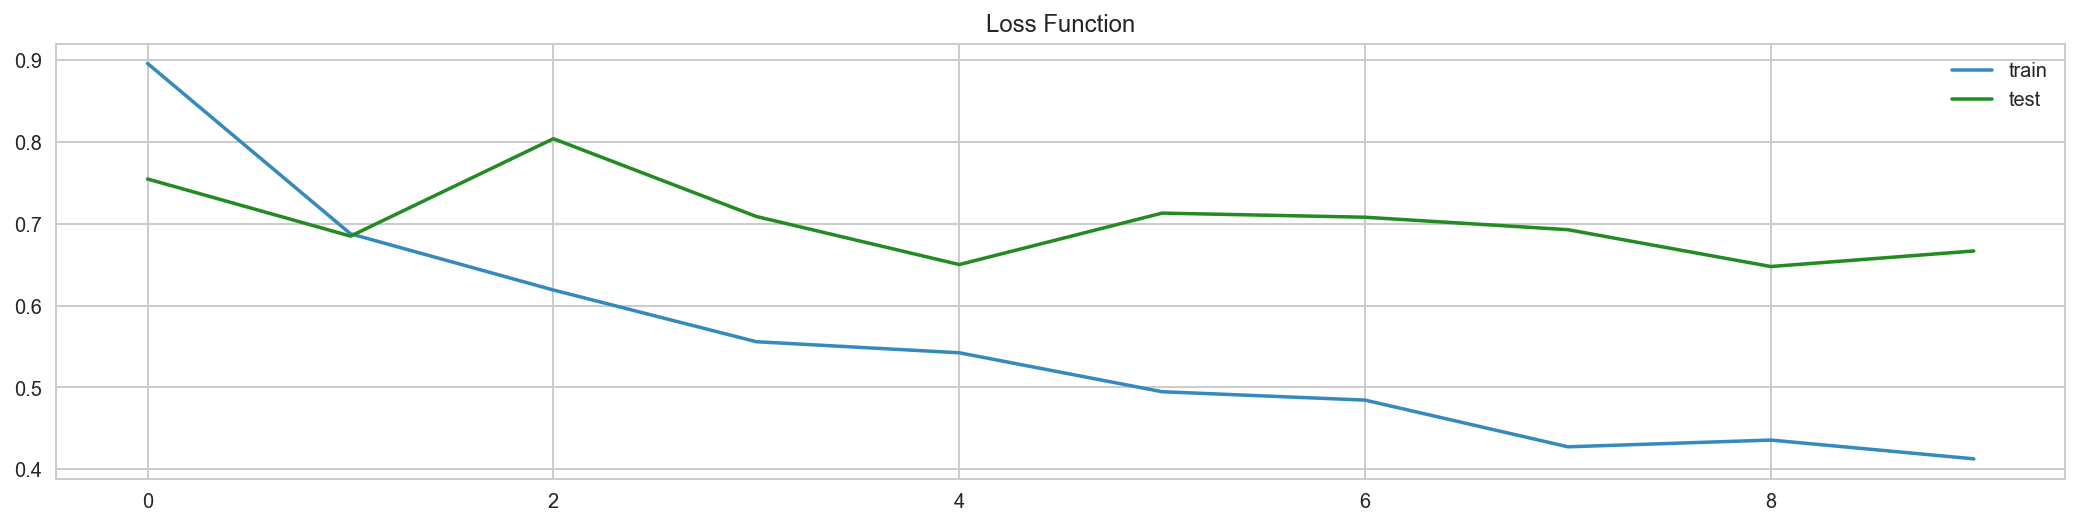

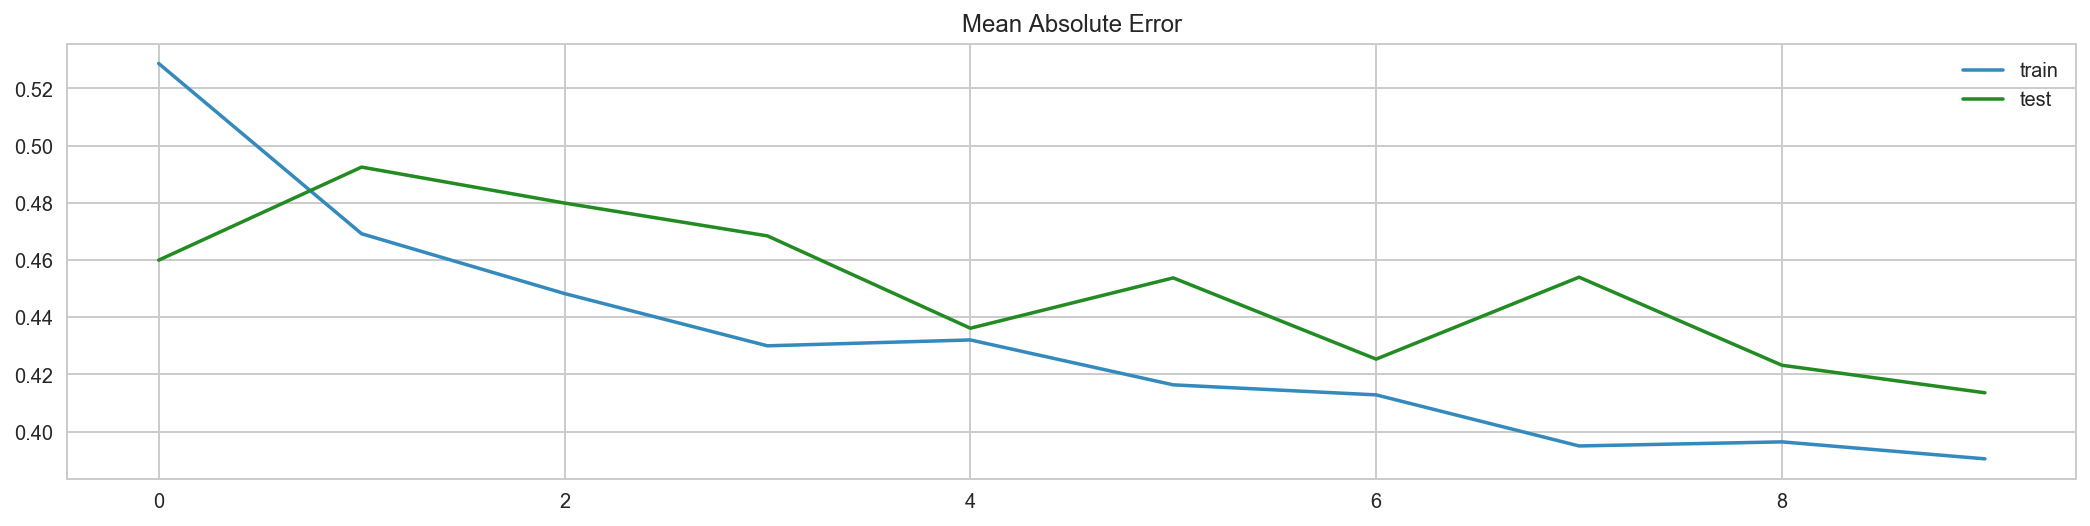

In [60]:
loss_plot(mlp_cat_history)
mae_plot(mlp_cat_history)

In [61]:
mlp_cat_model.load_weights('weights.best.mlp_cat_reg.sberbank.hdf5')
y_train_cat_mlp = mlp_cat_model.predict(X_train_cat)
y_test_cat_mlp = mlp_cat_model.predict(X_test_cat)

scores('MLP Model; Numeric and Categorical Features', 
       y_train_cat, y_test_cat, y_train_cat_mlp, y_test_cat_mlp)

_______________________________________
MLP Model; Numeric and Categorical Features
_______________________________________
EV score. Train:  0.782010081846
EV score. Test:  0.676597325288
---------
R2 score. Train:  0.781933363446
R2 score. Test:  0.67625080579
---------
MSE score. Train:  0.396571527964
MSE score. Test:  0.647791020651
---------
MAE score. Train:  0.377172679072
MAE score. Test:  0.423198407648
---------
MdAE score. Train:  0.18850664907
MdAE score. Test:  0.202510809001


In [62]:
mlp_cat_model.save('kaggle_sberbank_mlp_cat_reg_model.h5')

In [63]:
def mlp_cat_enc_model():
    model = Sequential()
    
    model.add(Dense(636*16, activation='relu', input_dim=636))   
    model.add(Dense(636*4, activation='relu'))    
    model.add(Dense(636, activation='relu'))
    
    model.add(Dense(1))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [64]:
mlp_cat_enc_model = mlp_cat_enc_model()
mlp_cat_enc_checkpointer = ModelCheckpoint(filepath='weights.best.mlp_cat_enc_reg.sberbank.hdf5', 
                                           verbose=2, save_best_only=True)
mlp_cat_enc_history = mlp_cat_enc_model.fit(X_train_cat_enc, y_train_cat_enc, 
                                            validation_data=(X_test_cat_enc, y_test_cat_enc),
                                            nb_epoch=5, batch_size=128, verbose=0, 
                                            callbacks=[mlp_cat_enc_checkpointer])

Epoch 00000: val_loss improved from inf to 1.14182, saving model to weights.best.mlp_cat_enc_reg.sberbank.hdf5
Epoch 00001: val_loss improved from 1.14182 to 0.78451, saving model to weights.best.mlp_cat_enc_reg.sberbank.hdf5
Epoch 00002: val_loss improved from 0.78451 to 0.68201, saving model to weights.best.mlp_cat_enc_reg.sberbank.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve


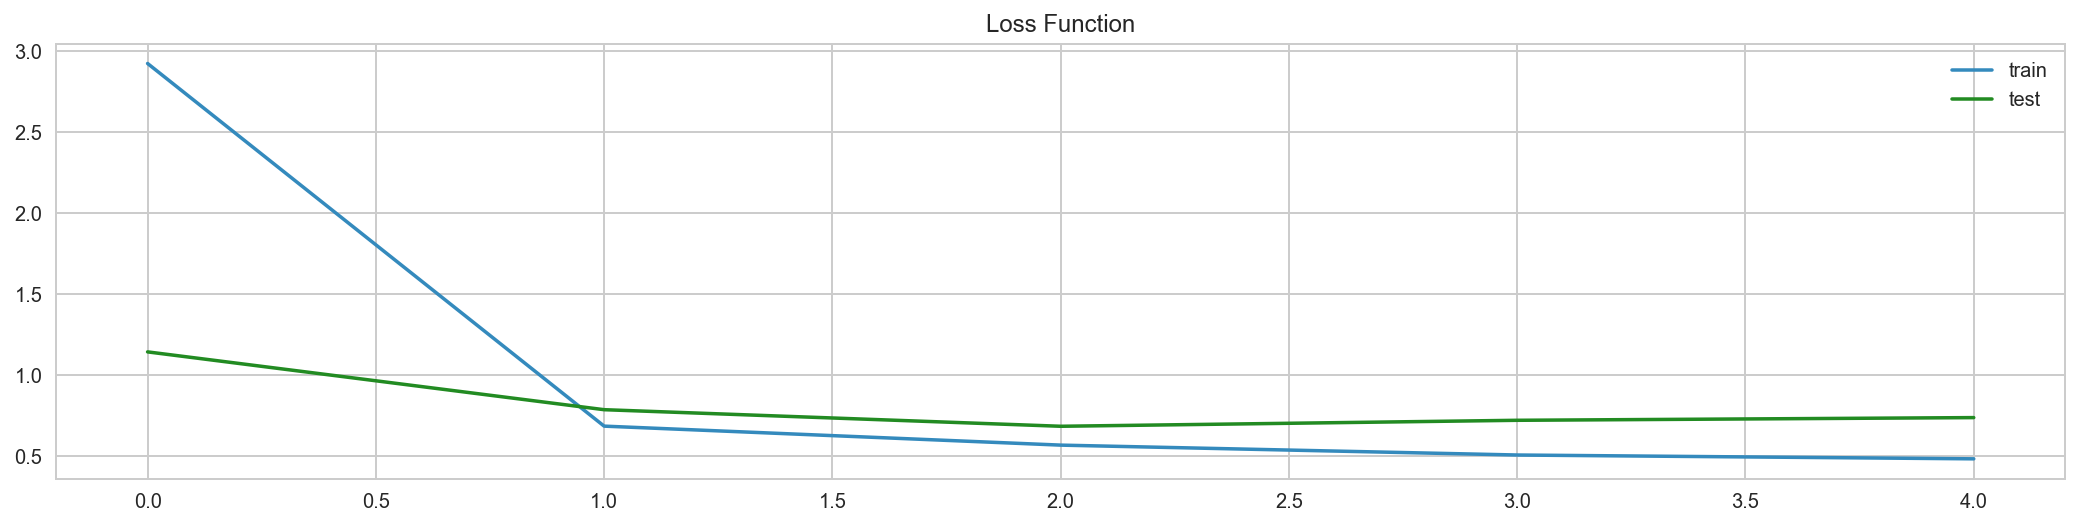

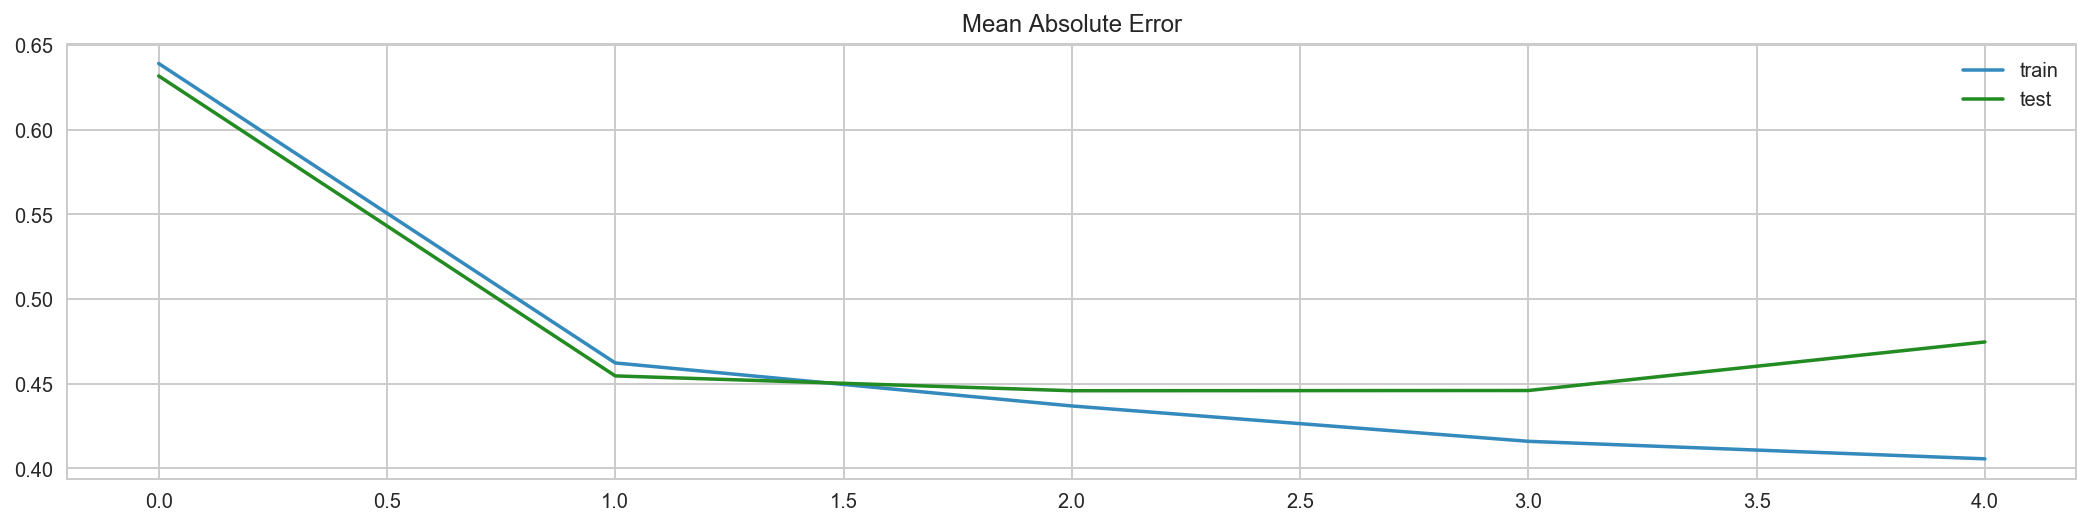

In [65]:
loss_plot(mlp_cat_enc_history)
mae_plot(mlp_cat_enc_history)

In [66]:
mlp_cat_enc_model.load_weights('weights.best.mlp_cat_enc_reg.sberbank.hdf5')
y_train_cat_enc_mlp = mlp_cat_enc_model.predict(X_train_cat_enc)
y_test_cat_enc_mlp = mlp_cat_enc_model.predict(X_test_cat_enc)

scores('MLP Model; Numeric and Encoded Categorical Features', 
       y_train_cat_enc, y_test_cat_enc, y_train_cat_enc_mlp, y_test_cat_enc_mlp)

_______________________________________
MLP Model; Numeric and Encoded Categorical Features
_______________________________________
EV score. Train:  0.7237861434
EV score. Test:  0.659150178427
---------
R2 score. Train:  0.723668867263
R2 score. Test:  0.659149210196
---------
MSE score. Train:  0.502530149799
MSE score. Test:  0.682009669725
---------
MAE score. Train:  0.405609245135
MAE score. Test:  0.445880775796
---------
MdAE score. Train:  0.208317982356
MdAE score. Test:  0.228854256154


In [67]:
mlp_cat_enc_model.save('kaggle_sberbank_mlp_cat_enc_reg_model.h5')

#### CNN

In [68]:
def cnn_model():
    model = Sequential()
        
    model.add(Conv1D(36, 5, padding='valid', activation='relu', input_shape=(36, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv1D(144, 3, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())

    model.add(Dense(576, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, kernel_initializer='normal'))
   
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [69]:
cnn_model = cnn_model()
cnn_checkpointer = ModelCheckpoint(filepath='weights.best.cnn_reg.sberbank.hdf5', 
                                   verbose=2, save_best_only=True)
cnn_history = cnn_model.fit(X_train.reshape(16719, 36, 1), y_train, 
                            epochs=20, batch_size=128, verbose=0, callbacks=[cnn_checkpointer],
                            validation_data=(X_test.reshape(4180, 36, 1), y_test))

Epoch 00000: val_loss improved from inf to 0.93670, saving model to weights.best.cnn_reg.sberbank.hdf5
Epoch 00001: val_loss improved from 0.93670 to 0.89904, saving model to weights.best.cnn_reg.sberbank.hdf5
Epoch 00002: val_loss improved from 0.89904 to 0.76809, saving model to weights.best.cnn_reg.sberbank.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss improved from 0.76809 to 0.69775, saving model to weights.best.cnn_reg.sberbank.hdf5
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss did not improve
Epoch 00007: val_loss improved from 0.69775 to 0.68095, saving model to weights.best.cnn_reg.sberbank.hdf5
Epoch 00008: val_loss did not improve
Epoch 00009: val_loss improved from 0.68095 to 0.66529, saving model to weights.best.cnn_reg.sberbank.hdf5
Epoch 00010: val_loss improved from 0.66529 to 0.64030, saving model to weights.best.cnn_reg.sberbank.hdf5
Epoch 00011: val_loss improved from 0.64030 to 0.62736, saving model to weights.best.cnn_reg.sberbank.h

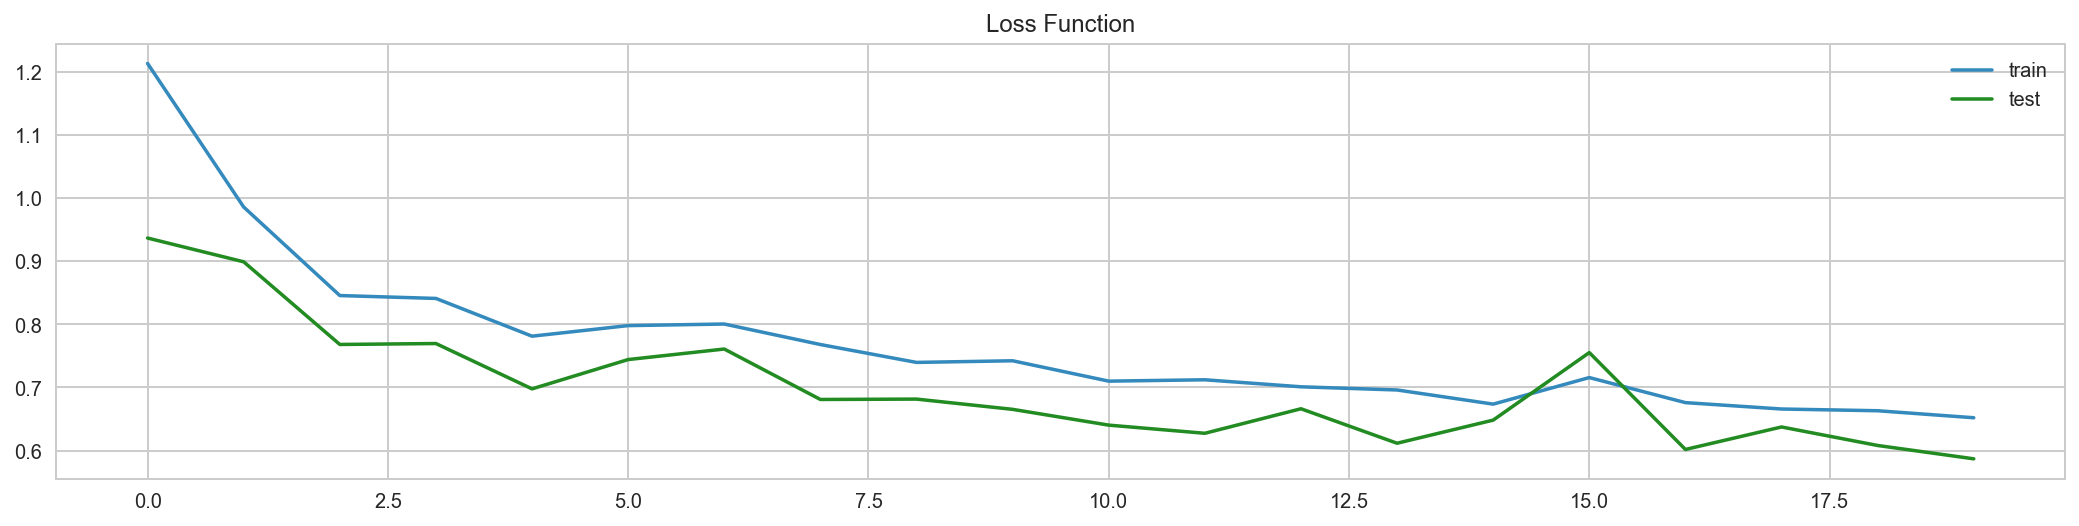

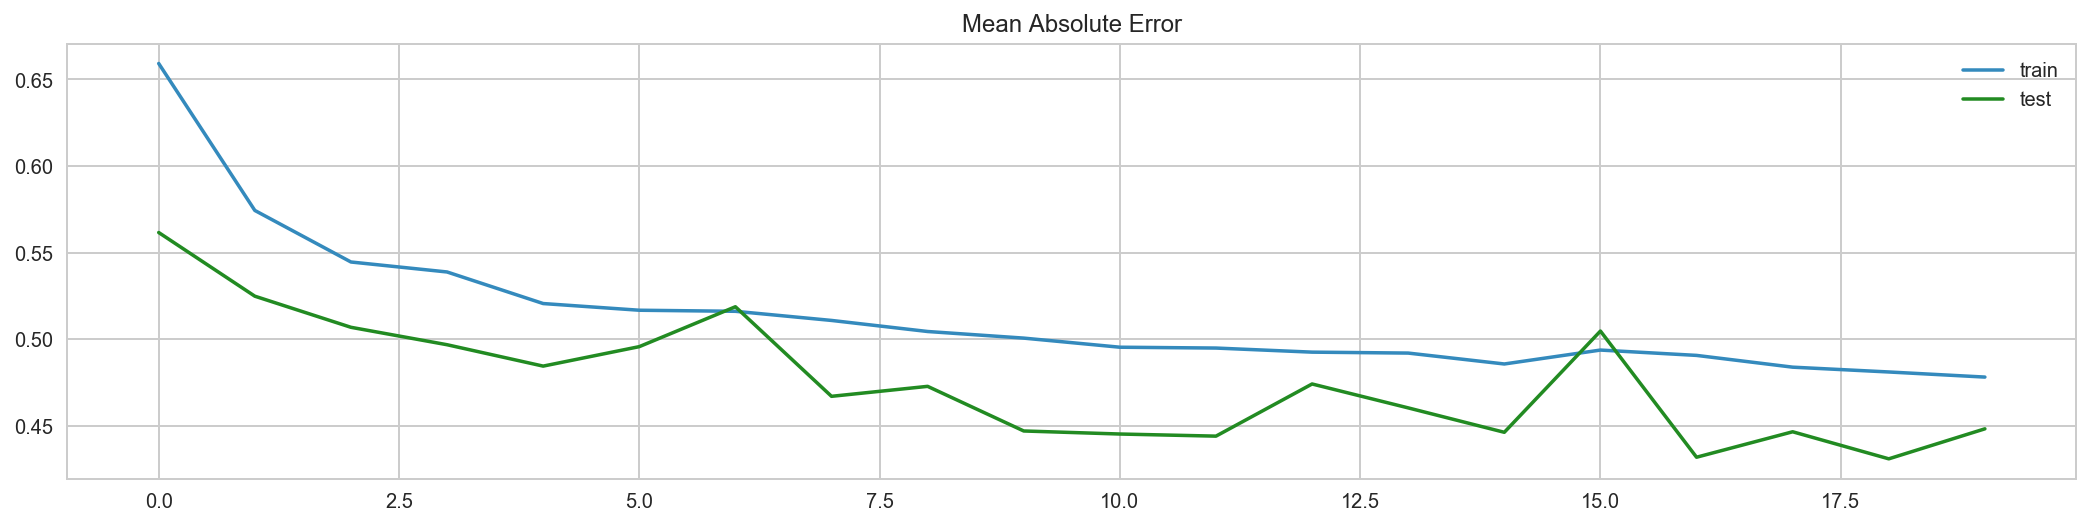

In [70]:
loss_plot(cnn_history)
mae_plot(cnn_history)

In [71]:
cnn_model.load_weights('weights.best.cnn_reg.sberbank.hdf5')
y_train_cnn = cnn_model.predict(X_train.reshape(16719, 36, 1))
y_test_cnn = cnn_model.predict(X_test.reshape(4180, 36, 1))

scores('CNN Model; Numeric Features', y_train, y_test, y_train_cnn, y_test_cnn)

_______________________________________
CNN Model; Numeric Features
_______________________________________
EV score. Train:  0.705114363797
EV score. Test:  0.707528070576
---------
R2 score. Train:  0.70437175327
R2 score. Test:  0.706684765892
---------
MSE score. Train:  0.537623486874
MSE score. Test:  0.586895591629
---------
MAE score. Train:  0.434927205225
MAE score. Test:  0.448317733572
---------
MdAE score. Train:  0.236828503211
MdAE score. Test:  0.240453710688


In [72]:
cnn_model.save('kaggle_sberbank_cnn_reg_model.h5')

In [73]:
def cnn_cat_model():
    model = Sequential()
        
    model.add(Conv1D(44, 5, padding='valid', activation='relu', input_shape=(44, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv1D(156, 3, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())

    model.add(Dense(624, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [74]:
cnn_cat_model = cnn_cat_model()
cnn_cat_checkpointer = ModelCheckpoint(filepath='weights.best.cnn_cat_reg.sberbank.hdf5', 
                                       verbose=2, save_best_only=True)

cnn_cat_history = cnn_cat_model.fit(X_train_cat.reshape(16719, 44, 1), y_train_cat, 
                                    epochs=20, batch_size=128, verbose=0, callbacks=[cnn_cat_checkpointer],
                                    validation_data=(X_test_cat.reshape(4180, 44, 1), y_test_cat))

Epoch 00000: val_loss improved from inf to 0.88733, saving model to weights.best.cnn_cat_reg.sberbank.hdf5
Epoch 00001: val_loss did not improve
Epoch 00002: val_loss improved from 0.88733 to 0.68227, saving model to weights.best.cnn_cat_reg.sberbank.hdf5
Epoch 00003: val_loss did not improve
Epoch 00004: val_loss did not improve
Epoch 00005: val_loss did not improve
Epoch 00006: val_loss improved from 0.68227 to 0.66485, saving model to weights.best.cnn_cat_reg.sberbank.hdf5
Epoch 00007: val_loss did not improve
Epoch 00008: val_loss improved from 0.66485 to 0.64924, saving model to weights.best.cnn_cat_reg.sberbank.hdf5
Epoch 00009: val_loss did not improve
Epoch 00010: val_loss improved from 0.64924 to 0.61577, saving model to weights.best.cnn_cat_reg.sberbank.hdf5
Epoch 00011: val_loss improved from 0.61577 to 0.61314, saving model to weights.best.cnn_cat_reg.sberbank.hdf5
Epoch 00012: val_loss improved from 0.61314 to 0.60660, saving model to weights.best.cnn_cat_reg.sberbank.hdf5

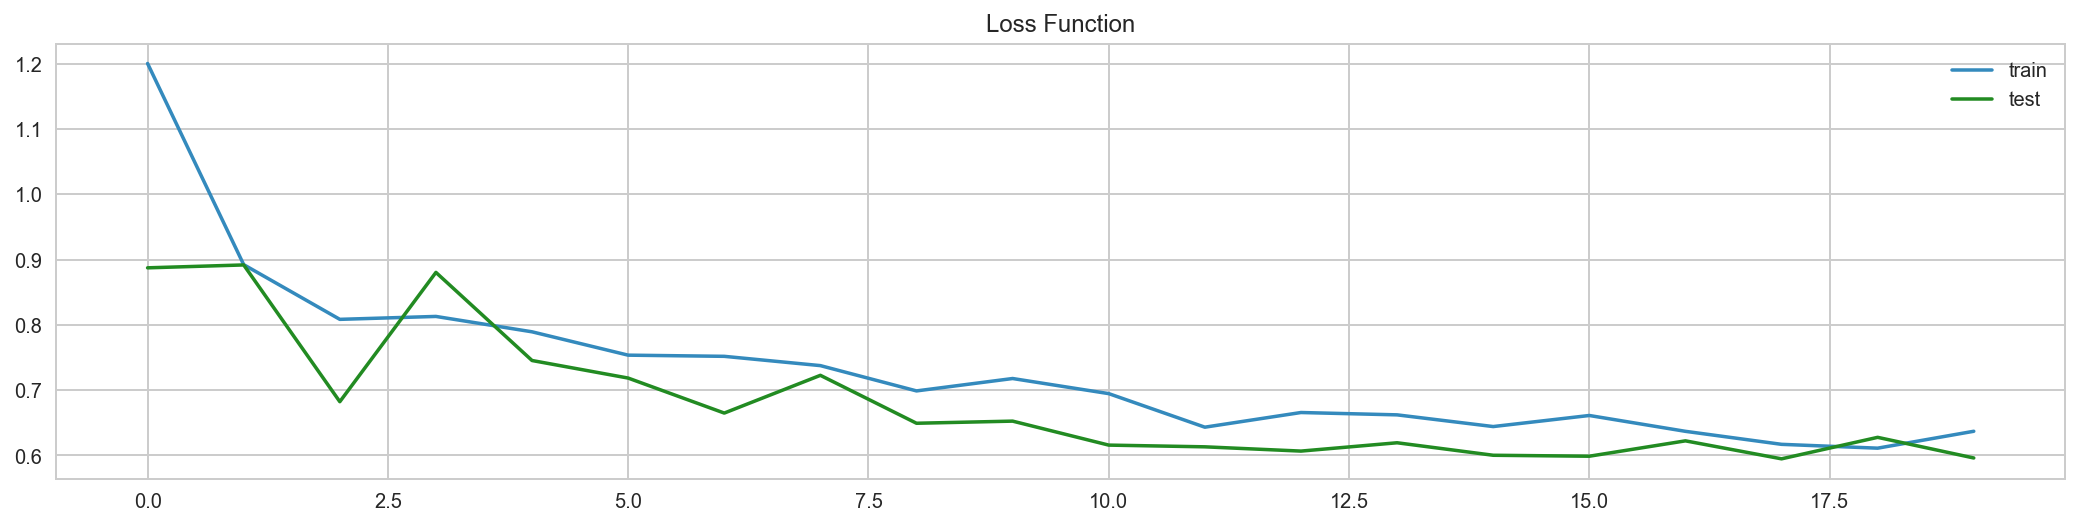

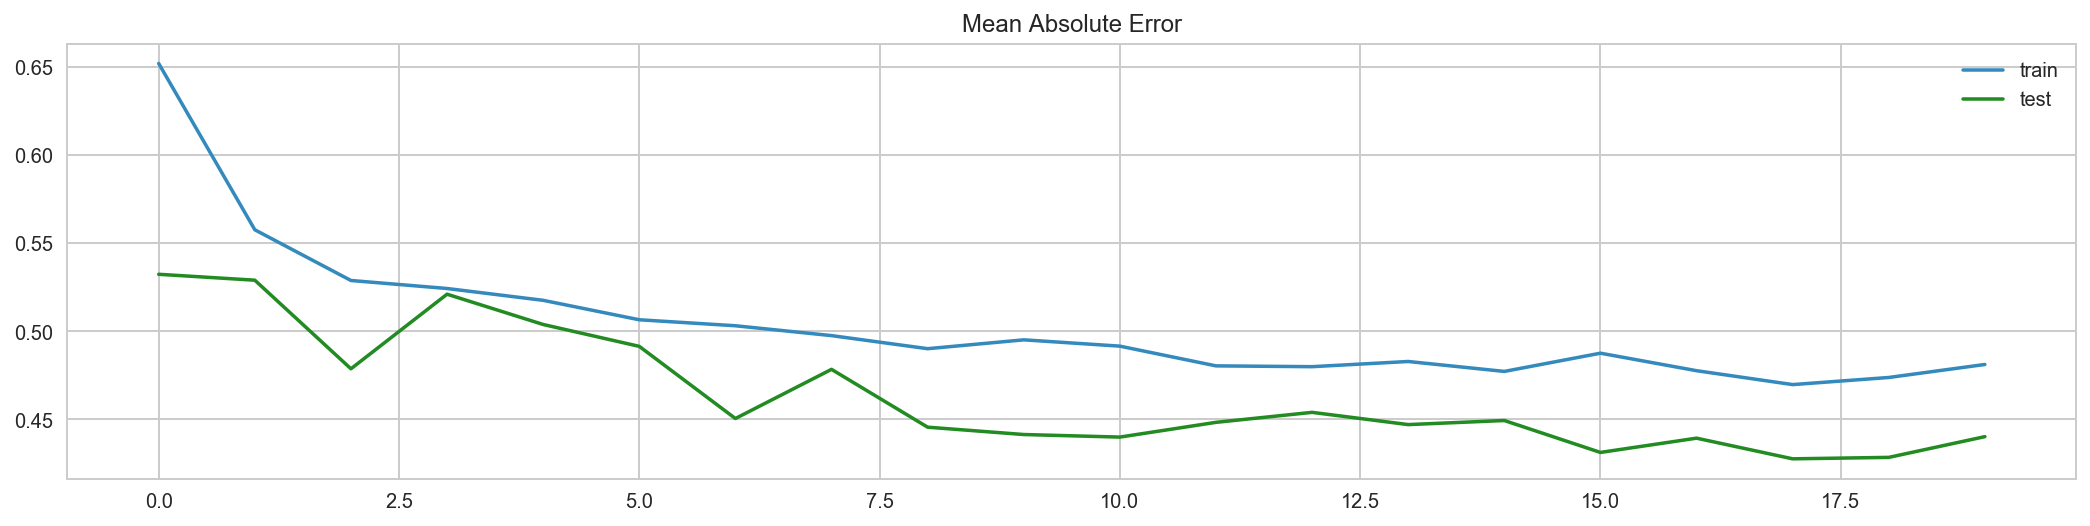

In [75]:
loss_plot(cnn_cat_history)
mae_plot(cnn_cat_history)

In [76]:
cnn_cat_model.load_weights('weights.best.cnn_cat_reg.sberbank.hdf5')
y_train_cat_cnn = cnn_cat_model.predict(X_train_cat.reshape(16719, 44, 1))
y_test_cat_cnn = cnn_cat_model.predict(X_test_cat.reshape(4180, 44, 1))

scores('CNN Model; Numeric and Categorical Features', 
       y_train_cat, y_test_cat, y_train_cat_cnn, y_test_cat_cnn)

_______________________________________
CNN Model; Numeric and Categorical Features
_______________________________________
EV score. Train:  0.723223586143
EV score. Test:  0.70394823434
---------
R2 score. Train:  0.721872064679
R2 score. Test:  0.70276161412
---------
MSE score. Train:  0.505797778251
MSE score. Test:  0.594745441254
---------
MAE score. Train:  0.409804135352
MAE score. Test:  0.427567134966
---------
MdAE score. Train:  0.205107864936
MdAE score. Test:  0.209665605177


In [77]:
cnn_cat_model.save('kaggle_sberbank_cnn_cat_reg_model.h5')

In [78]:
def cnn_cat_enc_model():
    model = Sequential()
        
    model.add(Conv1D(159, 5, padding='valid', activation='relu', input_shape=(636, 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))

    model.add(Conv1D(318, 3, padding='valid', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.25))
    
    model.add(Flatten())

    model.add(Dense(636, kernel_initializer='normal', activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1, kernel_initializer='normal'))
    
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [79]:
cnn_cat_enc_model = cnn_cat_enc_model()
cnn_cat_enc_checkpointer = ModelCheckpoint(filepath='weights.best.cnn_cat_enc_reg.sberbank.hdf5', 
                                           verbose=2, save_best_only=True)

cnn_cat_enc_history = \
cnn_cat_enc_model.fit(X_train_cat_enc.reshape(16719, 636, 1), y_train_cat_enc, 
                      epochs=10, batch_size=128, verbose=2, callbacks=[cnn_cat_enc_checkpointer],
                      validation_data=(X_test_cat_enc.reshape(4180, 636, 1), y_test_cat_enc))

Train on 16719 samples, validate on 4180 samples
Epoch 1/10
Epoch 00000: val_loss improved from inf to 0.95507, saving model to weights.best.cnn_cat_enc_reg.sberbank.hdf5
491s - loss: 1.0854 - mean_absolute_error: 0.6284 - val_loss: 0.9551 - val_mean_absolute_error: 0.5626
Epoch 2/10
Epoch 00001: val_loss improved from 0.95507 to 0.85263, saving model to weights.best.cnn_cat_enc_reg.sberbank.hdf5
451s - loss: 0.8050 - mean_absolute_error: 0.5231 - val_loss: 0.8526 - val_mean_absolute_error: 0.4949
Epoch 3/10
Epoch 00002: val_loss improved from 0.85263 to 0.79684, saving model to weights.best.cnn_cat_enc_reg.sberbank.hdf5
443s - loss: 0.7633 - mean_absolute_error: 0.5041 - val_loss: 0.7968 - val_mean_absolute_error: 0.4888
Epoch 4/10
Epoch 00003: val_loss improved from 0.79684 to 0.67811, saving model to weights.best.cnn_cat_enc_reg.sberbank.hdf5
435s - loss: 0.7312 - mean_absolute_error: 0.4955 - val_loss: 0.6781 - val_mean_absolute_error: 0.4819
Epoch 5/10
Epoch 00004: val_loss improv

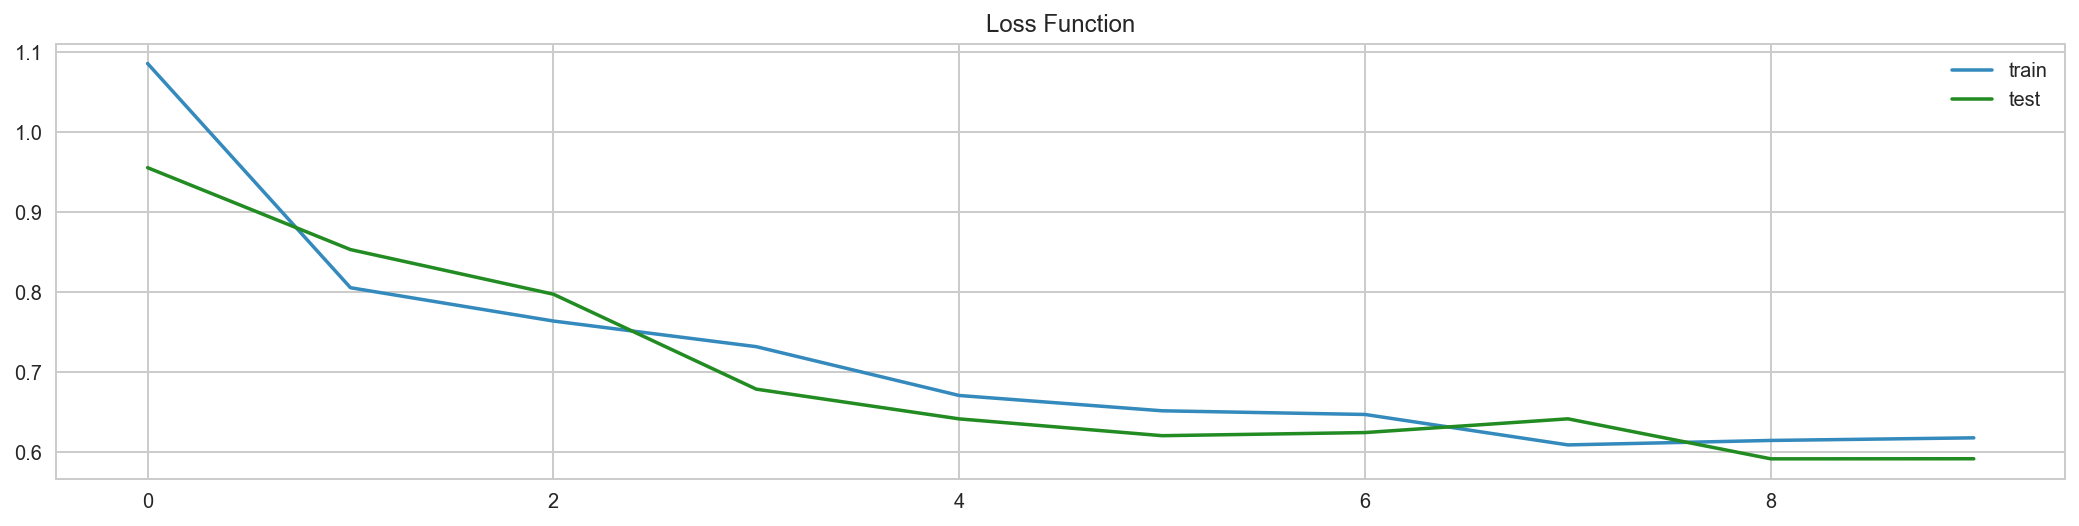

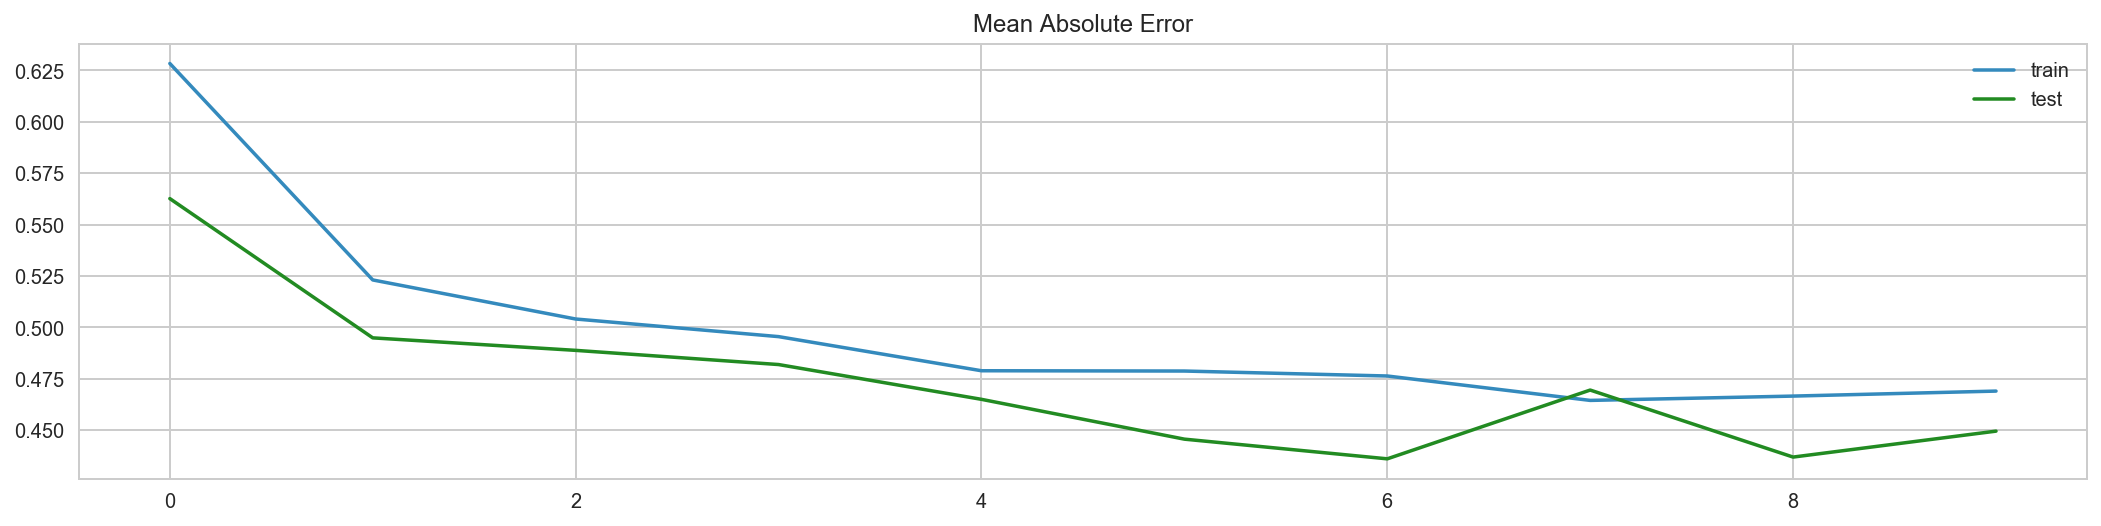

In [80]:
loss_plot(cnn_cat_enc_history)
mae_plot(cnn_cat_enc_history)

In [81]:
cnn_cat_enc_model.load_weights('weights.best.cnn_cat_enc_reg.sberbank.hdf5')
y_train_cat_enc_cnn = cnn_cat_enc_model.predict(X_train_cat_enc.reshape(16719, 636, 1))
y_test_cat_enc_cnn = cnn_cat_enc_model.predict(X_test_cat_enc.reshape(4180, 636, 1))

scores('CNN Model; Numeric and Encoded Categorical Features', 
       y_train_cat_enc, y_test_cat_enc, y_train_cat_enc_cnn, y_test_cat_enc_cnn)

_______________________________________
CNN Model; Numeric and Encoded Categorical Features
_______________________________________
EV score. Train:  0.717959835524
EV score. Test:  0.705085909833
---------
R2 score. Train:  0.716921542701
R2 score. Test:  0.704646336872
---------
MSE score. Train:  0.514800696332
MSE score. Test:  0.590974292176
---------
MAE score. Train:  0.419095635951
MAE score. Test:  0.436912609943
---------
MdAE score. Train:  0.212063937253
MdAE score. Test:  0.218610971385


In [82]:
cnn_cat_enc_model.save('kaggle_sberbank_cnn_cat_enc_reg_model.h5')

#### RNN

In [83]:
def rnn_model():
    model = Sequential()
    
    model.add(LSTM(144, return_sequences=True, input_shape=(1, 36)))
    model.add(LSTM(576, return_sequences=False))   
    
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])     
    return model

In [84]:
rnn_model = rnn_model()
rnn_checkpointer = ModelCheckpoint(filepath='weights.best.rnn_reg.sberbank.hdf5', 
                                   verbose=2, save_best_only=True)

rnn_history = rnn_model.fit(X_train.reshape(16719, 1, 36), y_train.reshape(16719), 
                            epochs=7, verbose=2, callbacks=[rnn_checkpointer],
                            validation_data=(X_test.reshape(4180, 1, 36), y_test.reshape(4180)))

Train on 16719 samples, validate on 4180 samples
Epoch 1/7
Epoch 00000: val_loss improved from inf to 0.78929, saving model to weights.best.rnn_reg.sberbank.hdf5
42s - loss: 0.8048 - mean_absolute_error: 0.5039 - val_loss: 0.7893 - val_mean_absolute_error: 0.5012
Epoch 2/7
Epoch 00001: val_loss improved from 0.78929 to 0.72229, saving model to weights.best.rnn_reg.sberbank.hdf5
38s - loss: 0.6888 - mean_absolute_error: 0.4645 - val_loss: 0.7223 - val_mean_absolute_error: 0.5053
Epoch 3/7
Epoch 00002: val_loss did not improve
38s - loss: 0.6602 - mean_absolute_error: 0.4527 - val_loss: 0.7320 - val_mean_absolute_error: 0.4785
Epoch 4/7
Epoch 00003: val_loss improved from 0.72229 to 0.71437, saving model to weights.best.rnn_reg.sberbank.hdf5
38s - loss: 0.6298 - mean_absolute_error: 0.4477 - val_loss: 0.7144 - val_mean_absolute_error: 0.4607
Epoch 5/7
Epoch 00004: val_loss improved from 0.71437 to 0.62779, saving model to weights.best.rnn_reg.sberbank.hdf5
38s - loss: 0.6043 - mean_absol

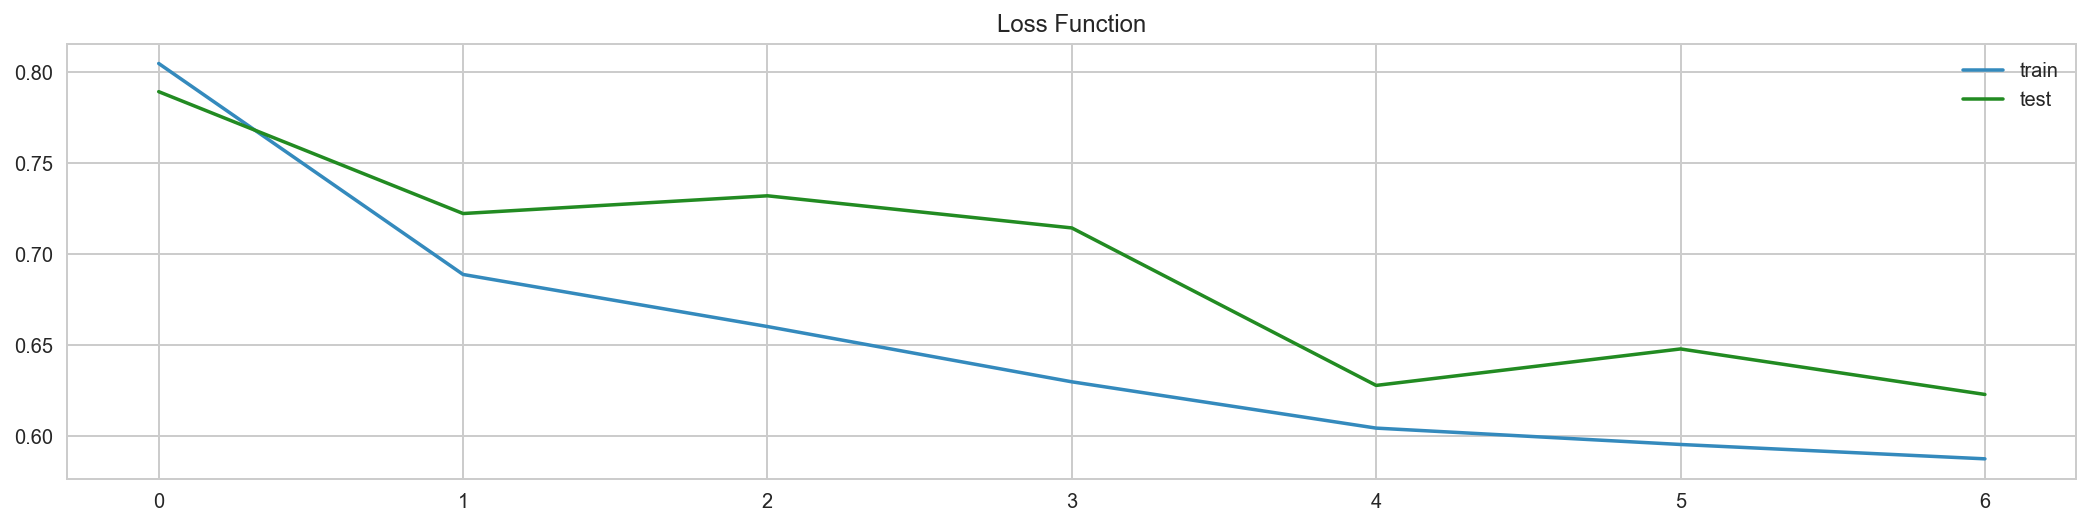

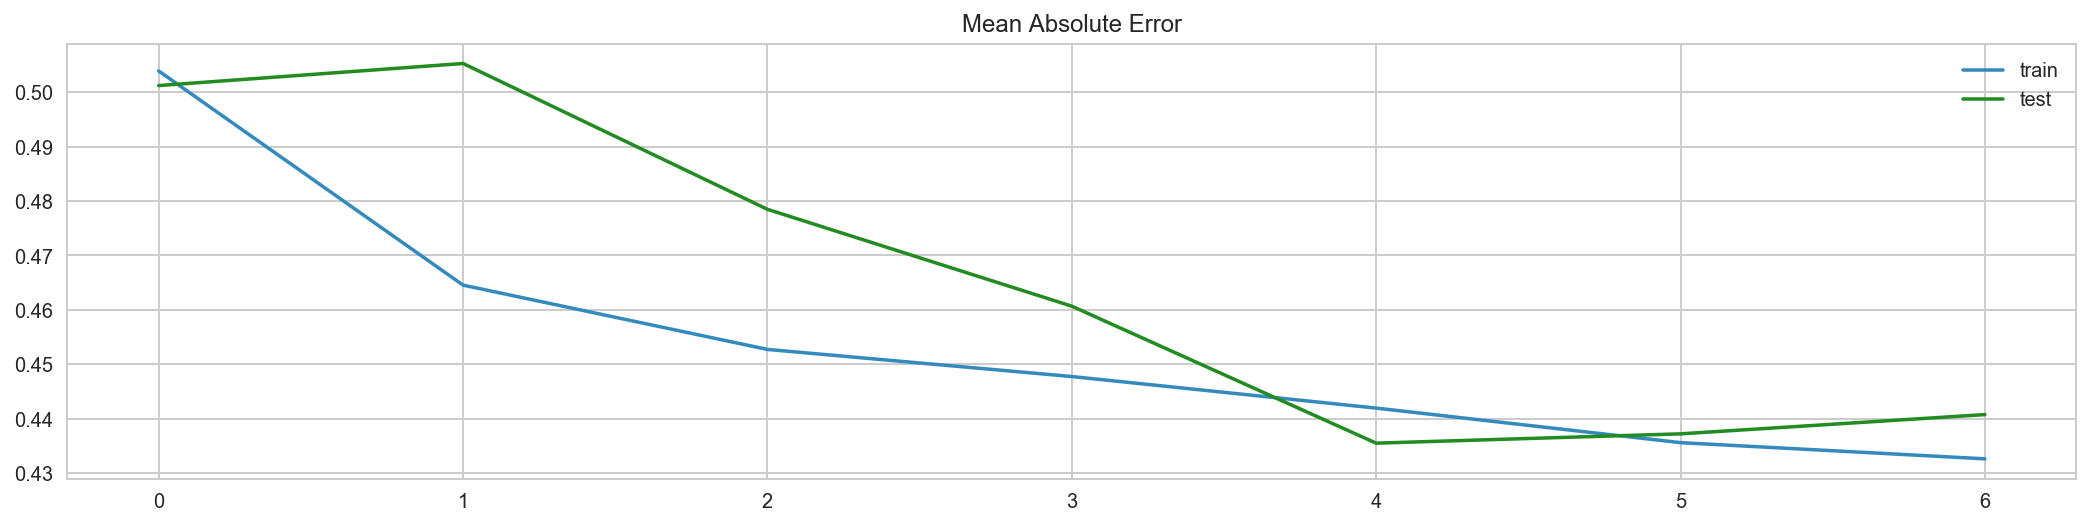

In [85]:
loss_plot(rnn_history)
mae_plot(rnn_history)

In [86]:
rnn_model.load_weights('weights.best.rnn_reg.sberbank.hdf5')
y_train_rnn = rnn_model.predict(X_train.reshape(16719, 1, 36))
y_test_rnn = rnn_model.predict(X_test.reshape(4180, 1, 36))

scores('RNN Model; Numeric Features', y_train, y_test, y_train_rnn, y_test_rnn)

_______________________________________
RNN Model; Numeric Features
_______________________________________
EV score. Train:  0.682497217371
EV score. Test:  0.689002521684
---------
R2 score. Train:  0.681939868929
R2 score. Test:  0.688726676982
---------
MSE score. Train:  0.578417653229
MSE score. Test:  0.622828001507
---------
MAE score. Train:  0.431094164427
MAE score. Test:  0.440757009896
---------
MdAE score. Train:  0.235219608049
MdAE score. Test:  0.241612637755


In [87]:
rnn_model.save('kaggle_sberbank_rnn_reg_model.h5')

In [88]:
def rnn_cat_model():
    model = Sequential()
    
    model.add(LSTM(156, return_sequences=True, input_shape=(1, 44)))
    model.add(LSTM(624, return_sequences=False))   
    
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])     
    return model 

In [89]:
rnn_cat_model = rnn_cat_model()
rnn_cat_checkpointer = ModelCheckpoint(filepath='weights.best.rnn_cat_reg.sberbank.hdf5', 
                                        verbose=2, save_best_only=True)

rnn_cat_history = rnn_cat_model.fit(X_train_cat.reshape(16719, 1, 44), y_train_cat.reshape(16719), 
                                    epochs=10, verbose=2, callbacks=[rnn_cat_checkpointer],
                                    validation_data=(X_test_cat.reshape(4180, 1, 44), y_test_cat.reshape(4180)))

Train on 16719 samples, validate on 4180 samples
Epoch 1/10
Epoch 00000: val_loss improved from inf to 0.66692, saving model to weights.best.rnn_cat_reg.sberbank.hdf5
47s - loss: 0.8226 - mean_absolute_error: 0.4999 - val_loss: 0.6669 - val_mean_absolute_error: 0.4597
Epoch 2/10
Epoch 00001: val_loss did not improve
43s - loss: 0.6973 - mean_absolute_error: 0.4620 - val_loss: 0.7960 - val_mean_absolute_error: 0.5140
Epoch 3/10
Epoch 00002: val_loss did not improve
44s - loss: 0.6600 - mean_absolute_error: 0.4513 - val_loss: 0.7380 - val_mean_absolute_error: 0.4688
Epoch 4/10
Epoch 00003: val_loss improved from 0.66692 to 0.63284, saving model to weights.best.rnn_cat_reg.sberbank.hdf5
44s - loss: 0.6382 - mean_absolute_error: 0.4438 - val_loss: 0.6328 - val_mean_absolute_error: 0.4465
Epoch 5/10
Epoch 00004: val_loss improved from 0.63284 to 0.62415, saving model to weights.best.rnn_cat_reg.sberbank.hdf5
44s - loss: 0.6093 - mean_absolute_error: 0.4388 - val_loss: 0.6241 - val_mean_abso

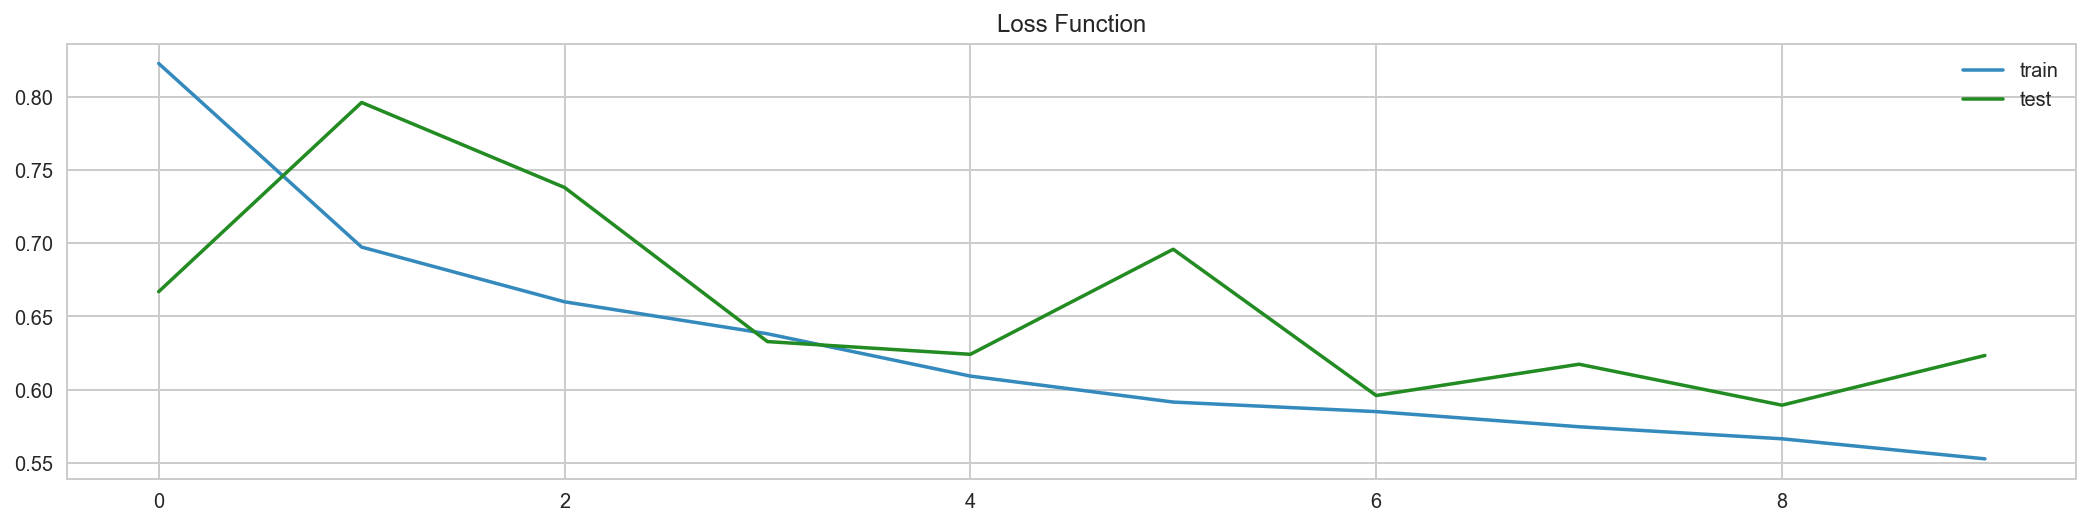

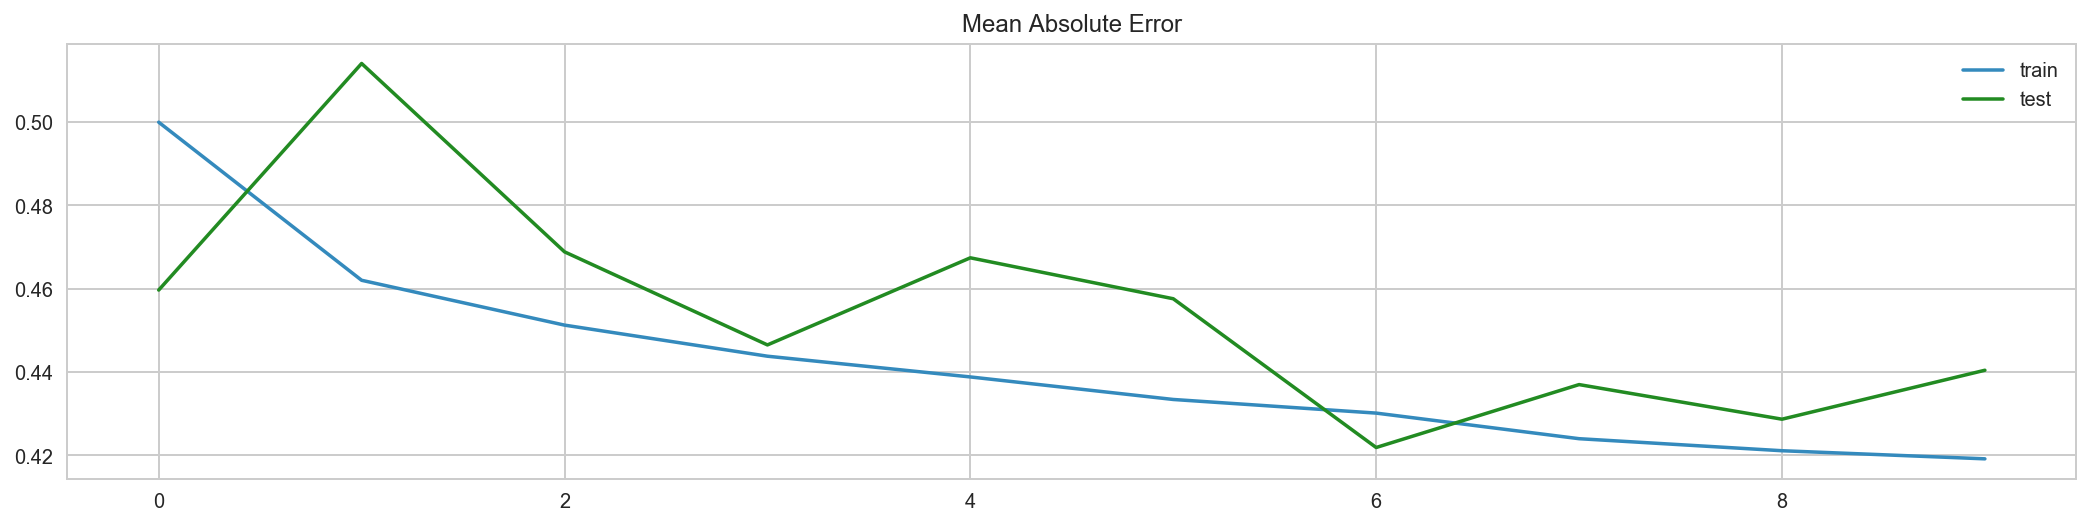

In [90]:
loss_plot(rnn_cat_history)
mae_plot(rnn_cat_history)

In [91]:
rnn_cat_model.load_weights('weights.best.rnn_cat_reg.sberbank.hdf5')
y_train_cat_rnn = rnn_cat_model.predict(X_train_cat.reshape(16719, 1, 44))
y_test_cat_rnn = rnn_cat_model.predict(X_test_cat.reshape(4180, 1, 44))

scores('RNN Model; Numeric and Categorical Features', 
       y_train_cat, y_test_cat, y_train_cat_rnn, y_test_cat_rnn)

_______________________________________
RNN Model; Numeric and Categorical Features
_______________________________________
EV score. Train:  0.715584707297
EV score. Test:  0.706017286927
---------
R2 score. Train:  0.715237510991
R2 score. Test:  0.705408504212
---------
MSE score. Train:  0.517863241977
MSE score. Test:  0.589449268584
---------
MAE score. Train:  0.415470796335
MAE score. Test:  0.428698135495
---------
MdAE score. Train:  0.218850794236
MdAE score. Test:  0.220256512788


In [92]:
rnn_cat_model.save('kaggle_sberbank_rnn_cat_reg_model.h5')

In [93]:
def rnn_cat_enc_model():
    model = Sequential()
    
    model.add(LSTM(159, return_sequences=True, input_shape=(1, 636)))
    model.add(LSTM(636, return_sequences=False))   
    
    model.add(Dense(1))

    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])     
    return model 

In [94]:
rnn_cat_enc_model = rnn_cat_enc_model()
rnn_cat_enc_checkpointer = ModelCheckpoint(filepath='weights.best.rnn_cat_enc_reg.sberbank.hdf5', 
                                        verbose=2, save_best_only=True)
rnn_cat_enc_history = \
rnn_cat_enc_model.fit(X_train_cat_enc.reshape(16719, 1, 636), y_train_cat_enc.reshape(16719), 
                      epochs=10, verbose=2, callbacks=[rnn_cat_enc_checkpointer],
                      validation_data=(X_test_cat_enc.reshape(4180, 1, 636), y_test_cat_enc.reshape(4180)))

Train on 16719 samples, validate on 4180 samples
Epoch 1/10
Epoch 00000: val_loss improved from inf to 0.62132, saving model to weights.best.rnn_cat_enc_reg.sberbank.hdf5
54s - loss: 0.7393 - mean_absolute_error: 0.4851 - val_loss: 0.6213 - val_mean_absolute_error: 0.4545
Epoch 2/10
Epoch 00001: val_loss did not improve
50s - loss: 0.6346 - mean_absolute_error: 0.4404 - val_loss: 0.6963 - val_mean_absolute_error: 0.4658
Epoch 3/10
Epoch 00002: val_loss improved from 0.62132 to 0.60604, saving model to weights.best.rnn_cat_enc_reg.sberbank.hdf5
50s - loss: 0.6121 - mean_absolute_error: 0.4291 - val_loss: 0.6060 - val_mean_absolute_error: 0.4378
Epoch 4/10
Epoch 00003: val_loss did not improve
49s - loss: 0.6062 - mean_absolute_error: 0.4226 - val_loss: 0.6201 - val_mean_absolute_error: 0.4315
Epoch 5/10
Epoch 00004: val_loss improved from 0.60604 to 0.59229, saving model to weights.best.rnn_cat_enc_reg.sberbank.hdf5
51s - loss: 0.5854 - mean_absolute_error: 0.4186 - val_loss: 0.5923 - v

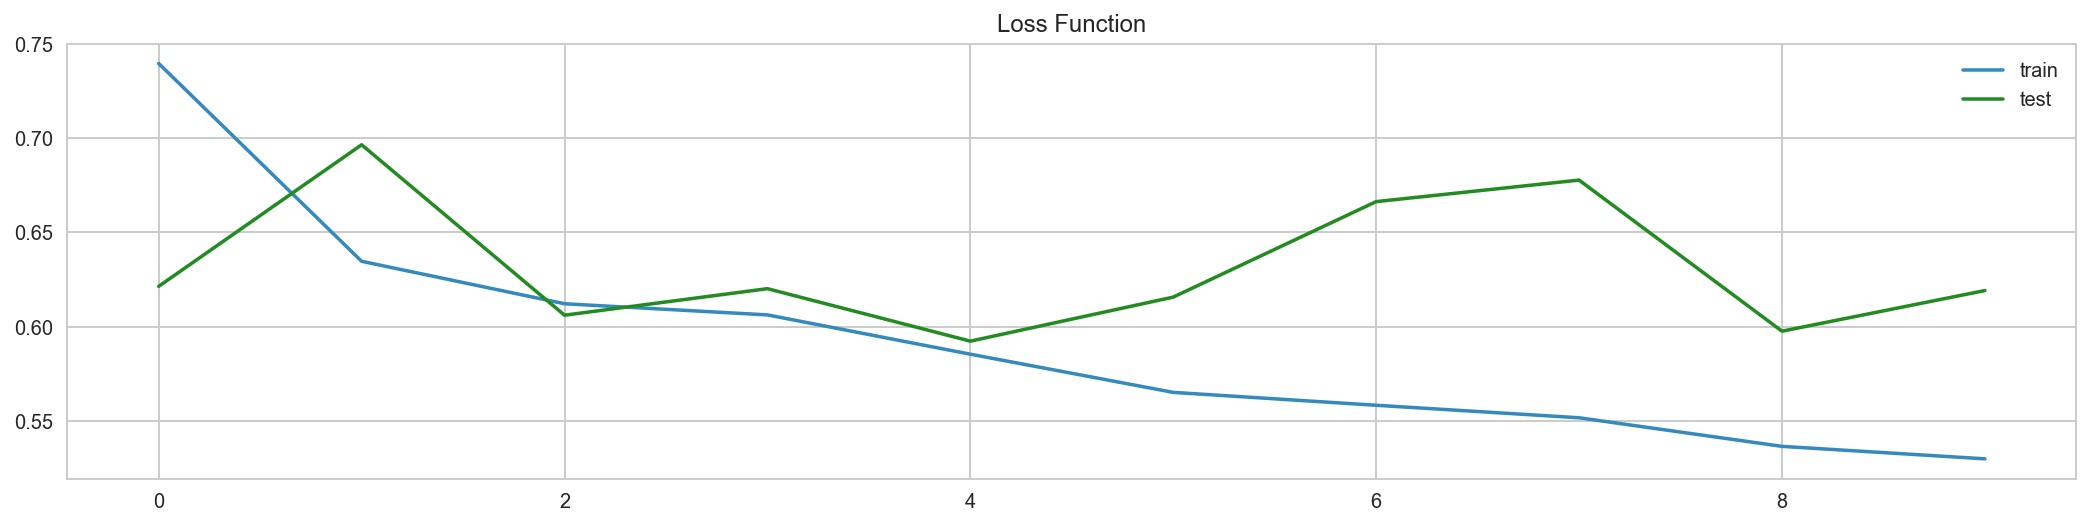

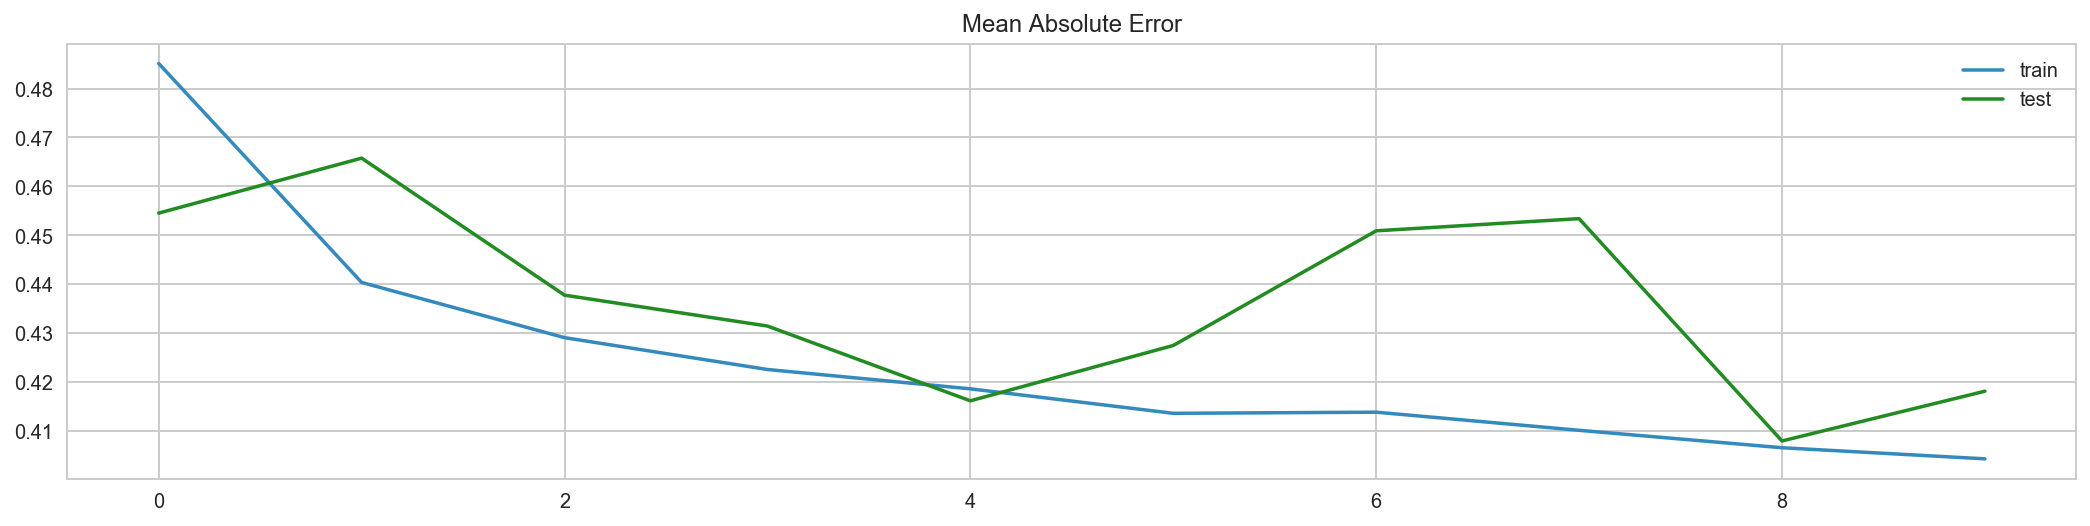

In [95]:
loss_plot(rnn_cat_enc_history)
mae_plot(rnn_cat_enc_history)

In [96]:
rnn_cat_enc_model.load_weights('weights.best.rnn_cat_enc_reg.sberbank.hdf5')
y_train_cat_enc_rnn = rnn_cat_enc_model.predict(X_train_cat_enc.reshape(16719, 1, 636))
y_test_cat_enc_rnn = rnn_cat_enc_model.predict(X_test_cat_enc.reshape(4180, 1, 636))

scores('RNN Model; Numeric and Encoded Categorical Features', 
       y_train_cat_enc, y_test_cat_enc, y_train_cat_enc_rnn, y_test_cat_enc_rnn)

_______________________________________
RNN Model; Numeric and Encoded Categorical Features
_______________________________________
EV score. Train:  0.713417534491
EV score. Test:  0.704193010422
---------
R2 score. Train:  0.712717363012
R2 score. Test:  0.703989347329
---------
MSE score. Train:  0.522446331581
MSE score. Test:  0.592288865105
---------
MAE score. Train:  0.394271343729
MAE score. Test:  0.416193402073
---------
MdAE score. Train:  0.19245701419
MdAE score. Test:  0.204565595982


#### Display Predictions

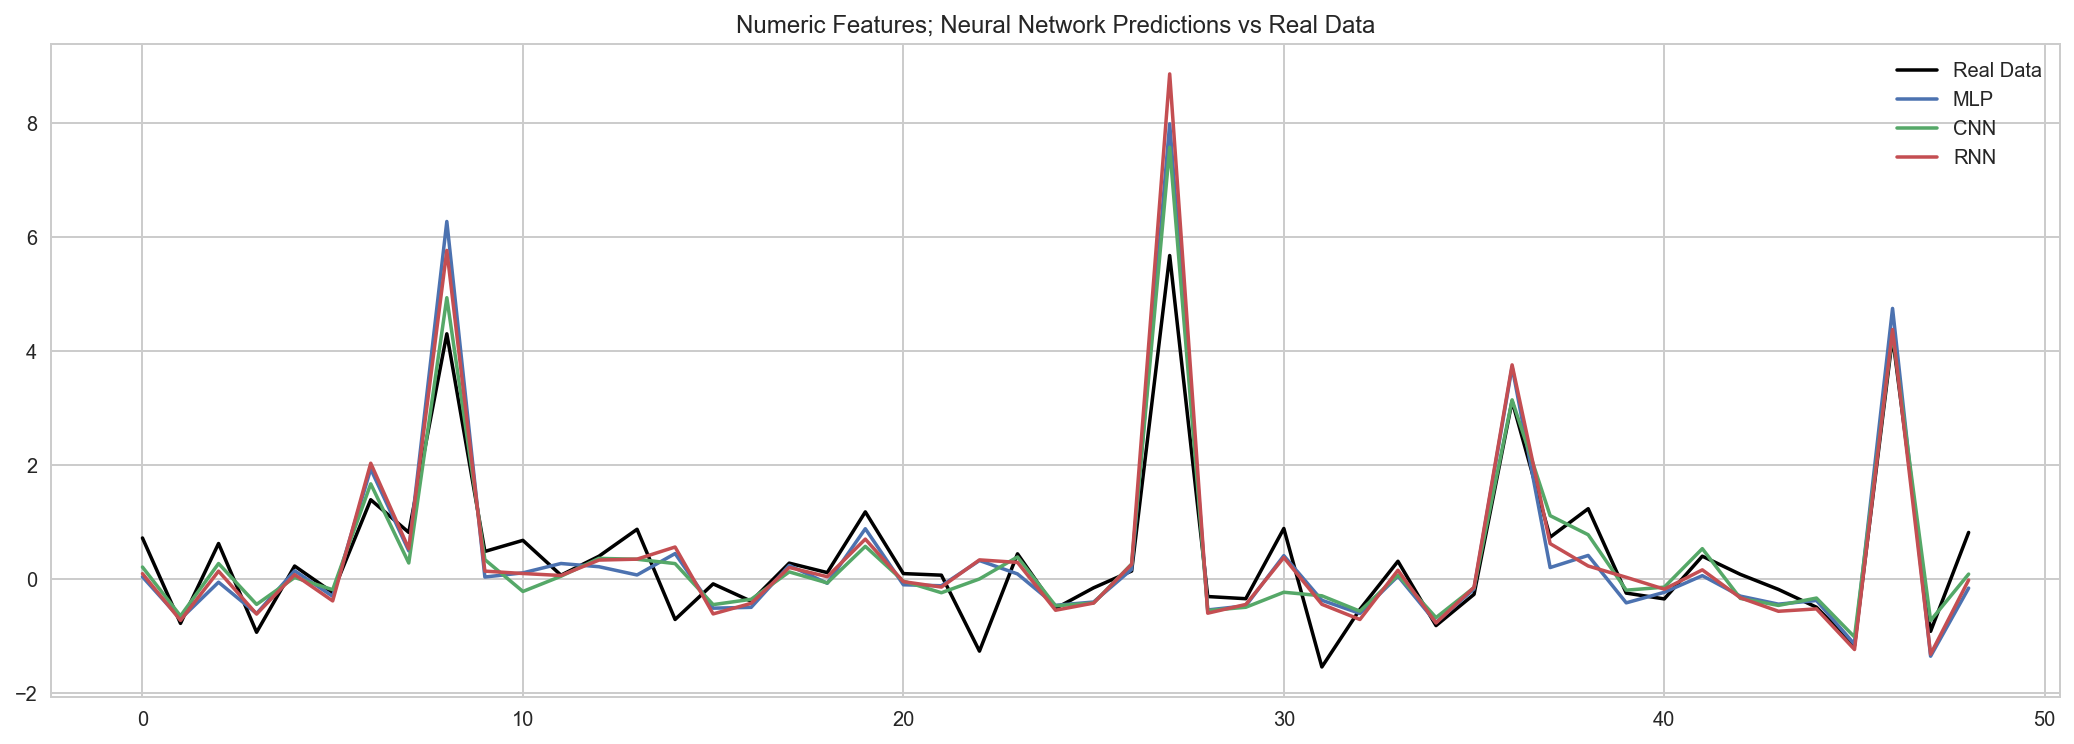

In [97]:
plt.figure(figsize = (18, 6))

plt.plot(y_test[1:50], color = 'black', label='Real Data')

plt.plot(y_test_mlp[1:50], label='MLP')
plt.plot(y_test_cnn[1:50], label='CNN')
plt.plot(y_test_rnn[1:50], label='RNN')

plt.legend()
plt.title("Numeric Features; Neural Network Predictions vs Real Data");

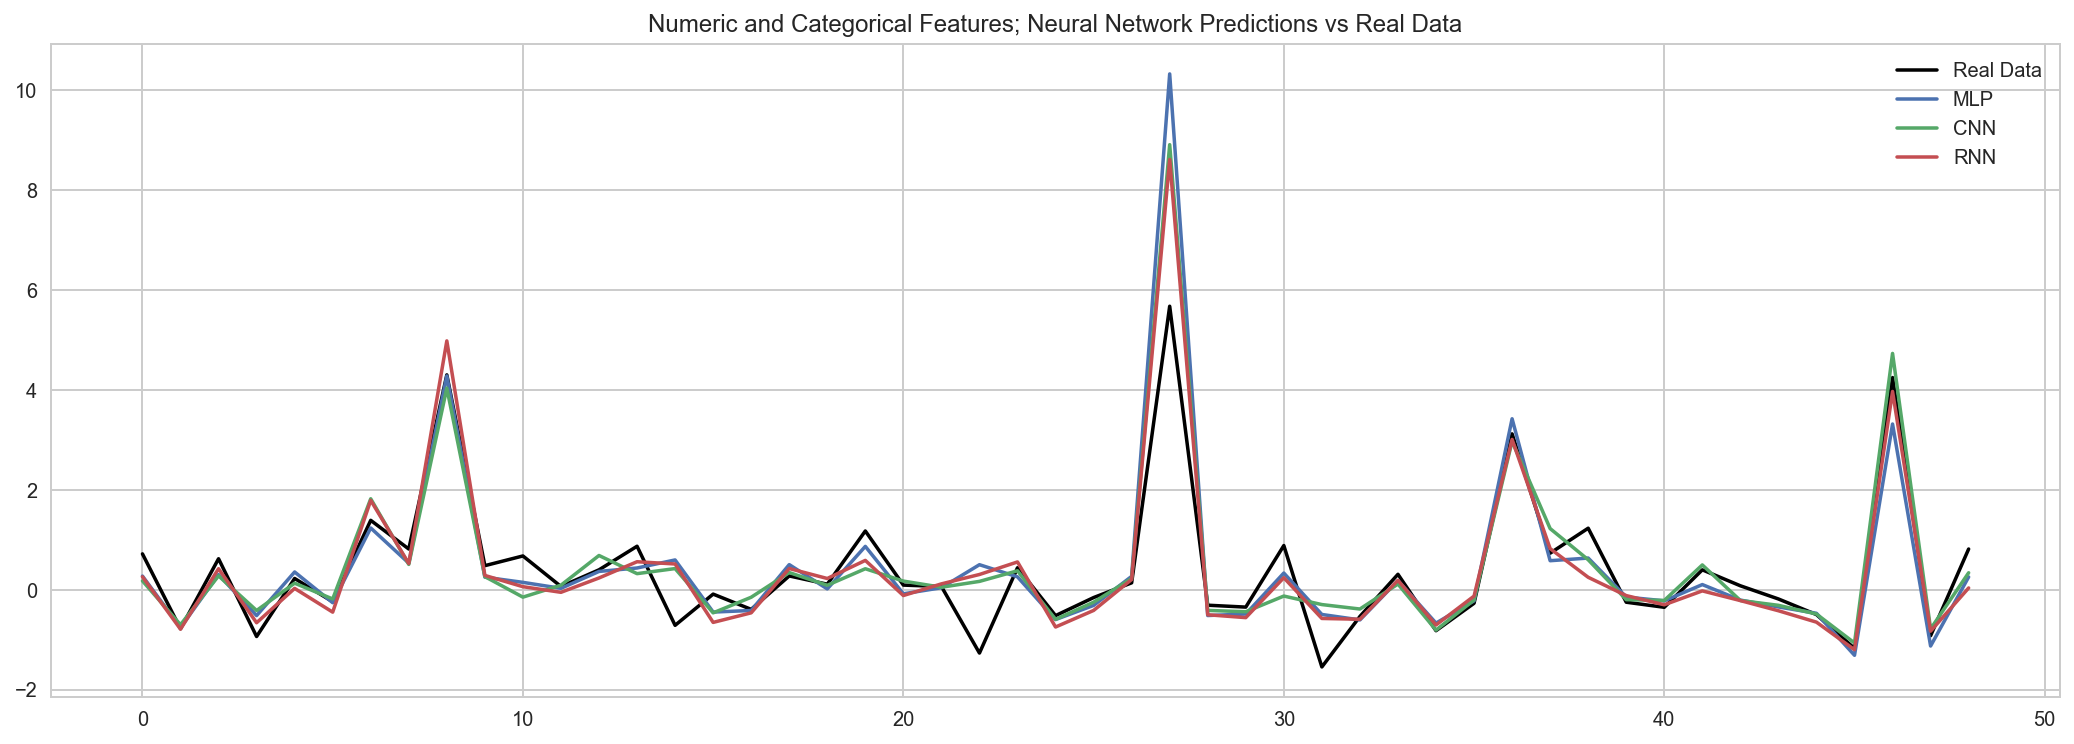

In [98]:
plt.figure(figsize = (18, 6))

plt.plot(y_test_cat[1:50], color = 'black', label='Real Data')

plt.plot(y_test_cat_mlp[1:50], label='MLP')
plt.plot(y_test_cat_cnn[1:50], label='CNN')
plt.plot(y_test_cat_rnn[1:50], label='RNN')

plt.legend()
plt.title("Numeric and Categorical Features; Neural Network Predictions vs Real Data");

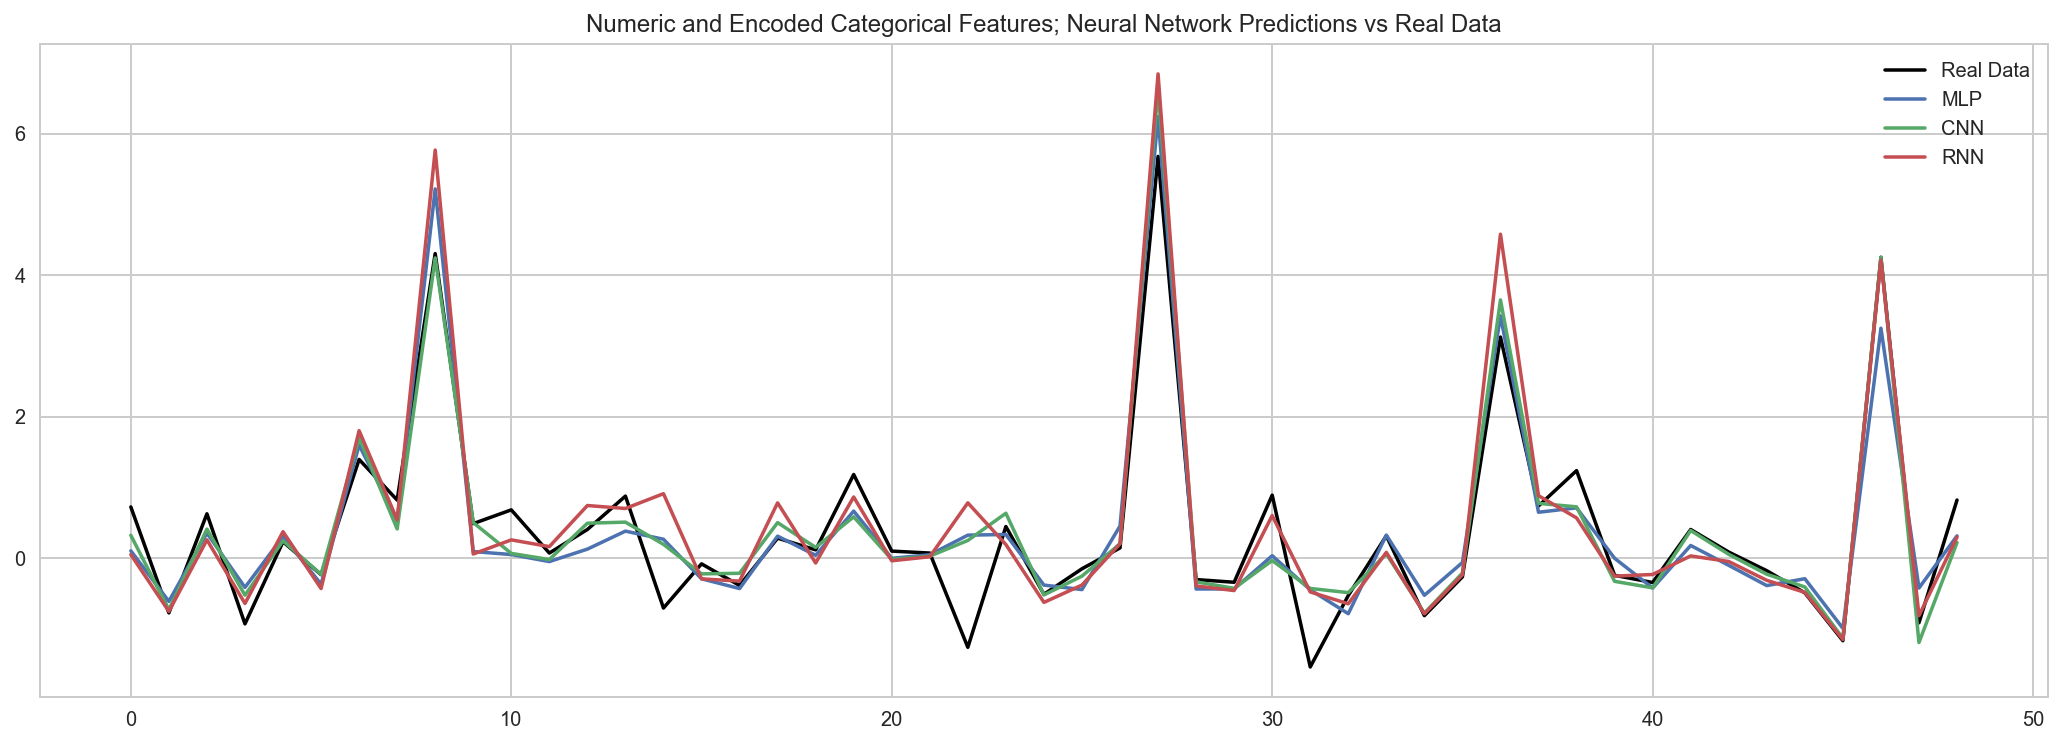

In [99]:
plt.figure(figsize = (18, 6))

plt.plot(y_test_cat[1:50], color = 'black', label='Real Data')

plt.plot(y_test_cat_enc_mlp[1:50], label='MLP')
plt.plot(y_test_cat_enc_cnn[1:50], label='CNN')
plt.plot(y_test_cat_enc_rnn[1:50], label='RNN')

plt.legend()
plt.title("Numeric and Encoded Categorical Features; Neural Network Predictions vs Real Data");

---
## 5. Evaluation Metrics
- explained variance regression score
- coefficient of determination
- mean squared error
- mean absolute error
- median absolute error

In [100]:
# Scale
target_scale = RobustScaler()
s_target_train = target_scale.fit_transform(target_train.reshape(-1,1))
#########################################################################################
feature_scale = RobustScaler()
s_features_train = feature_scale.fit_transform(features_train)
s_features_test = feature_scale.transform(features_test)
########################################################################################
feature_cat_scale = RobustScaler()
s_features_train_cat = feature_cat_scale.fit_transform(features_train_cat)
s_features_test_cat = feature_cat_scale.transform(features_test_cat)
########################################################################################
feature_cat_enc_scale = RobustScaler()
s_features_train_cat_enc = feature_cat_enc_scale.fit_transform(features_train_cat_enc)
s_features_test_cat_enc = feature_cat_enc_scale.transform(features_test_cat_enc)

### 5.1 Regressors; Scikit-Learn
#### Numeric Features

In [101]:
gbr = GradientBoostingRegressor(max_depth=4, n_estimators=216)
gbr.fit(s_features_train, s_target_train)

s_target_train_gbr = gbr.predict(s_features_train)
s_target_test_gbr = gbr.predict(s_features_test)

scores2('Gradient Boosting Regressor', s_target_train, s_target_train_gbr)

_______________________________________
Gradient Boosting Regressor
_______________________________________
EV score: 0.825179810737
---------
R2 score: 0.825179810737
---------
MSE score: 0.322666059625
---------
MAE score: 0.34774839191
---------
MdAE score: 0.185154890894


In [102]:
br = BaggingRegressor(n_estimators=252)
br.fit(s_features_train, s_target_train)

s_target_train_br = br.predict(s_features_train)
s_target_test_br = br.predict(s_features_test)

scores2('Bagging Regressor', s_target_train, s_target_train_br)

_______________________________________
Bagging Regressor
_______________________________________
EV score: 0.958452730784
---------
R2 score: 0.95843201992
---------
MSE score: 0.0767221245758
---------
MAE score: 0.144379137608
---------
MdAE score: 0.0626716064031


In [103]:
s_target_train_mlpr = mlpr.predict(s_features_train)
s_target_test_mlpr = mlpr.predict(s_features_test)

scores2('MLP Regressor', s_target_train, s_target_train_mlpr)


_______________________________________
MLP Regressor
_______________________________________
EV score: 0.693714264414
---------
R2 score: 0.69343366993
---------
MSE score: 0.565830240512
---------
MAE score: 0.433349194582
---------
MdAE score: 0.244117560663


#### Numeric and Categorical Features

In [104]:
gbr_cat = GradientBoostingRegressor(max_depth=3, n_estimators=396)
gbr_cat.fit(s_features_train_cat, s_target_train)

s_target_train_cat_gbr = gbr_cat.predict(s_features_train_cat)
s_target_test_cat_gbr = gbr_cat.predict(s_features_test_cat)

scores2('Gradient Boosting Regressor', s_target_train, s_target_train_cat_gbr)

_______________________________________
Gradient Boosting Regressor
_______________________________________
EV score: 0.813227343634
---------
R2 score: 0.813227343634
---------
MSE score: 0.344726757987
---------
MAE score: 0.357167721423
---------
MdAE score: 0.190744564286


In [105]:
br_cat = BaggingRegressor(n_estimators=220)
br_cat.fit(s_features_train_cat, s_target_train)

s_target_train_cat_br = br_cat.predict(s_features_train_cat)
s_target_test_cat_br = br_cat.predict(s_features_test_cat)

scores2('Bagging Regressor', s_target_train, s_target_train_cat_br)

_______________________________________
Bagging Regressor
_______________________________________
EV score: 0.958423566208
---------
R2 score: 0.958399843145
---------
MSE score: 0.0767815133294
---------
MAE score: 0.14481657106
---------
MdAE score: 0.063009478449


In [106]:
s_target_train_cat_mlpr = mlpr_cat.predict(s_features_train_cat)
s_target_test_cat_mlpr = mlpr_cat.predict(s_features_test_cat)

scores2('MLP Regressor', s_target_train, s_target_train_cat_mlpr)

_______________________________________
MLP Regressor
_______________________________________
EV score: 0.710679165769
---------
R2 score: 0.71064965173
---------
MSE score: 0.534054659939
---------
MAE score: 0.417151334953
---------
MdAE score: 0.22658448092


#### Numeric and Encoded Categorical Features

In [107]:
gbr_cat_enc = GradientBoostingRegressor(max_depth=3, n_estimators=159)
gbr_cat_enc.fit(s_features_train_cat_enc, s_target_train)

s_target_train_cat_enc_gbr = gbr_cat_enc.predict(s_features_train_cat_enc)
s_target_test_cat_enc_gbr = gbr_cat_enc.predict(s_features_test_cat_enc)

scores2('Gradient Boosting Regressor', s_target_train, s_target_train_cat_enc_gbr)

_______________________________________
Gradient Boosting Regressor
_______________________________________
EV score: 0.764000775181
---------
R2 score: 0.764000775181
---------
MSE score: 0.435584358236
---------
MAE score: 0.394758875506
---------
MdAE score: 0.206033263364


In [108]:
br_cat_enc = BaggingRegressor(n_estimators=159)
br_cat_enc.fit(s_features_train_cat_enc, s_target_train)

s_target_train_cat_enc_br = br_cat.predict(s_features_train_cat_enc)
s_target_test_cat_enc_br = br_cat.predict(s_features_test_cat_enc)

scores2('Bagging Regressor', s_target_train, s_target_train_cat_enc_br)

_______________________________________
Bagging Regressor
_______________________________________
EV score: 0.921236747847
---------
R2 score: 0.921131716427
---------
MSE score: 0.145567387824
---------
MAE score: 0.200423963543
---------
MdAE score: 0.0926198683352


In [109]:
s_target_train_cat_enc_mlpr = mlpr_cat_enc.predict(s_features_train_cat_enc)
s_target_test_cat_enc_mlpr = mlpr_cat_enc.predict(s_features_test_cat_enc)

scores2('MLP Regressor', s_target_train, s_target_train_cat_enc_mlpr)

_______________________________________
MLP Regressor
_______________________________________
EV score: 0.746619206117
---------
R2 score: 0.746609328351
---------
MSE score: 0.467683795054
---------
MAE score: 0.405222034075
---------
MdAE score: 0.222134648003


### 5.2 Neural Networks; Keras
#### Numeric Features

In [110]:
s_target_train_mlp = mlp_model.predict(s_features_train)
s_target_test_mlp = mlp_model.predict(s_features_test)

scores2('MLP', s_target_train, s_target_train_mlp)

_______________________________________
MLP
_______________________________________
EV score: 0.691691023207
---------
R2 score: 0.691377931788
---------
MSE score: 0.569624521532
---------
MAE score: 0.436912935111
---------
MdAE score: 0.24509363963


In [111]:
s_target_train_cnn = cnn_model.predict(s_features_train.reshape(20899, 36, 1))
s_target_test_cnn = cnn_model.predict(s_features_test.reshape(7662, 36, 1))

scores2('CNN', s_target_train, s_target_train_cnn)

_______________________________________
CNN
_______________________________________
EV score: 0.705699665165
---------
R2 score: 0.704911064054
---------
MSE score: 0.544646385534
---------
MAE score: 0.436627739764
---------
MdAE score: 0.236745600673


In [112]:
s_target_train_rnn = rnn_model.predict(s_features_train.reshape(20899, 1, 36))
s_target_test_rnn = rnn_model.predict(s_features_test.reshape(7662, 1, 36))

scores2('RNN', s_target_train, s_target_train_rnn)

_______________________________________
RNN
_______________________________________
EV score: 0.683971486573
---------
R2 score: 0.683528029013
---------
MSE score: 0.584113106676
---------
MAE score: 0.432211275343
---------
MdAE score: 0.236503906741


#### Numeric and Categorical Feature

In [113]:
s_target_train_cat_mlp = mlp_cat_model.predict(s_features_train_cat)
s_target_test_cat_mlp = mlp_cat_model.predict(s_features_test_cat)

scores2('MLP', s_target_train, s_target_train_cat_mlp)

_______________________________________
MLP
_______________________________________
EV score: 0.75918930514
---------
R2 score: 0.759061813261
---------
MSE score: 0.444700212578
---------
MAE score: 0.385666589948
---------
MdAE score: 0.190842316247


In [114]:
s_target_train_cat_cnn = cnn_cat_model.predict(s_features_train_cat.reshape(20899, 44, 1))
s_target_test_cat_cnn = cnn_cat_model.predict(s_features_test_cat.reshape(7662, 44, 1))

scores2('CNN', s_target_train, s_target_train_cat_cnn)

_______________________________________
CNN
_______________________________________
EV score: 0.718989132617
---------
R2 score: 0.717740071509
---------
MSE score: 0.520967854457
---------
MAE score: 0.412349317236
---------
MdAE score: 0.205521016452


In [115]:
s_target_train_cat_rnn = rnn_cat_model.predict(s_features_train_cat.reshape(20899, 1, 44))
s_target_test_cat_rnn = rnn_cat_model.predict(s_features_test_cat.reshape(7662, 1, 44))

scores2('RNN', s_target_train, s_target_train_cat_rnn)

_______________________________________
RNN
_______________________________________
EV score: 0.71349498516
---------
R2 score: 0.713045364694
---------
MSE score: 0.529632886543
---------
MAE score: 0.417582557722
---------
MdAE score: 0.219545605191


#### Numeric and Encoded Categorical Features

In [116]:
s_target_train_cat_enc_mlp = mlp_cat_enc_model.predict(s_features_train_cat_enc)
s_target_test_cat_enc_mlp = mlp_cat_enc_model.predict(s_features_test_cat_enc)

scores2('MLP', s_target_train, s_target_train_cat_enc_mlp)

_______________________________________
MLP
_______________________________________
EV score: 0.710217960283
---------
R2 score: 0.710141416775
---------
MSE score: 0.534992710464
---------
MAE score: 0.412341763475
---------
MdAE score: 0.210951037326


In [117]:
s_target_train_cat_enc_cnn = cnn_cat_enc_model.predict(s_features_train_cat_enc.reshape(20899, 636, 1))
s_target_test_cat_enc_cnn = cnn_cat_enc_model.predict(s_features_test_cat_enc.reshape(7662, 636, 1))

scores2('CNN', s_target_train, s_target_train_cat_enc_cnn)

_______________________________________
CNN
_______________________________________
EV score: 0.715164502352
---------
R2 score: 0.714228135074
---------
MSE score: 0.5274498443
---------
MAE score: 0.421446617654
---------
MdAE score: 0.213246567262


In [118]:
s_target_train_cat_enc_rnn = rnn_cat_enc_model.predict(s_features_train_cat_enc.reshape(20899, 1, 636))
s_target_test_cat_enc_rnn = rnn_cat_enc_model.predict(s_features_test_cat_enc.reshape(7662, 1, 636))

scores2('RNN', s_target_train, s_target_train_cat_enc_rnn)

_______________________________________
RNN
_______________________________________
EV score: 0.711561546559
---------
R2 score: 0.711072133512
---------
MSE score: 0.53327488426
---------
MAE score: 0.398109809835
---------
MdAE score: 0.194746240963


---
## 6. Predictions

In [119]:
# Rescale Predictions
target_train_gbr = target_scale.inverse_transform(s_target_train_gbr.reshape(-1,1))
target_test_gbr = target_scale.inverse_transform(s_target_test_gbr.reshape(-1,1))
target_train_br = target_scale.inverse_transform(s_target_train_br.reshape(-1,1))
target_test_br = target_scale.inverse_transform(s_target_test_br.reshape(-1,1))
target_train_mlpr = target_scale.inverse_transform(s_target_train_mlpr.reshape(-1,1))
target_test_mlpr = target_scale.inverse_transform(s_target_test_mlpr.reshape(-1,1))

target_train_mlp = target_scale.inverse_transform(s_target_train_mlp)
target_test_mlp = target_scale.inverse_transform(s_target_test_mlp)
target_train_cnn = target_scale.inverse_transform(s_target_train_cnn)
target_test_cnn = target_scale.inverse_transform(s_target_test_cnn)
target_train_rnn = target_scale.inverse_transform(s_target_train_rnn)
target_test_rnn = target_scale.inverse_transform(s_target_test_rnn)

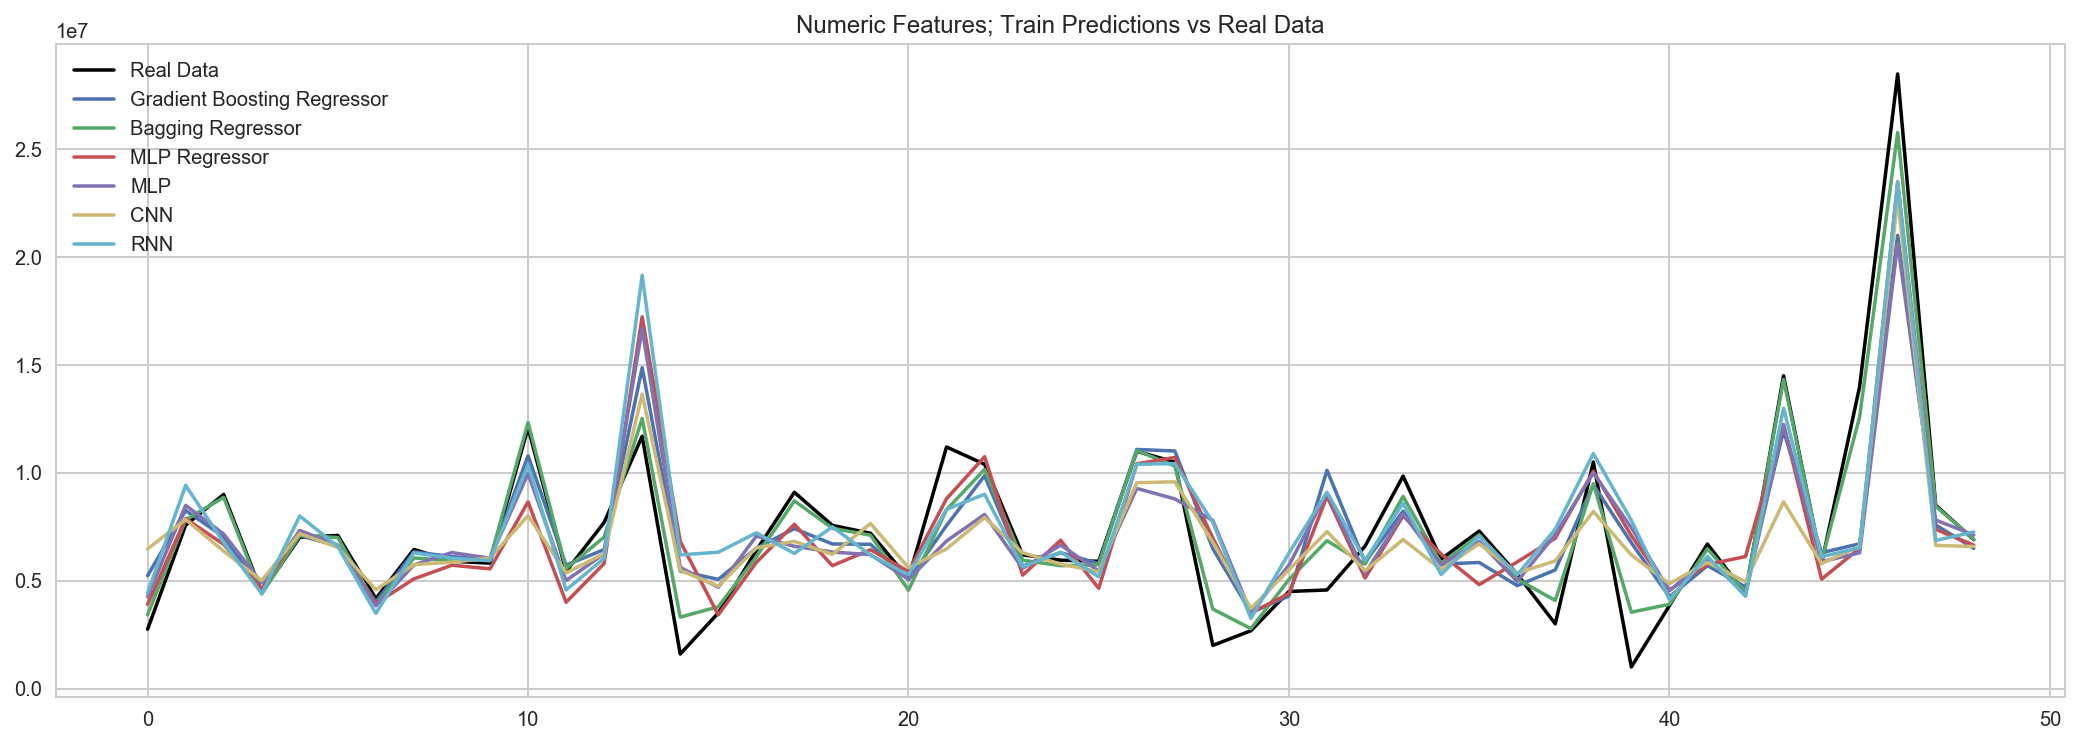

In [120]:
plt.figure(figsize = (18, 6))

plt.plot(target_train[1:50], color = 'black', label='Real Data')

plt.plot(target_train_gbr[1:50], label='Gradient Boosting Regressor')
plt.plot(target_train_br[1:50], label='Bagging Regressor')
plt.plot(target_train_mlpr[1:50], label='MLP Regressor')

plt.plot(target_train_mlp[1:50], label='MLP')
plt.plot(target_train_cnn[1:50], label='CNN')
plt.plot(target_train_rnn[1:50], label='RNN')

plt.legend()
plt.title("Numeric Features; Train Predictions vs Real Data");

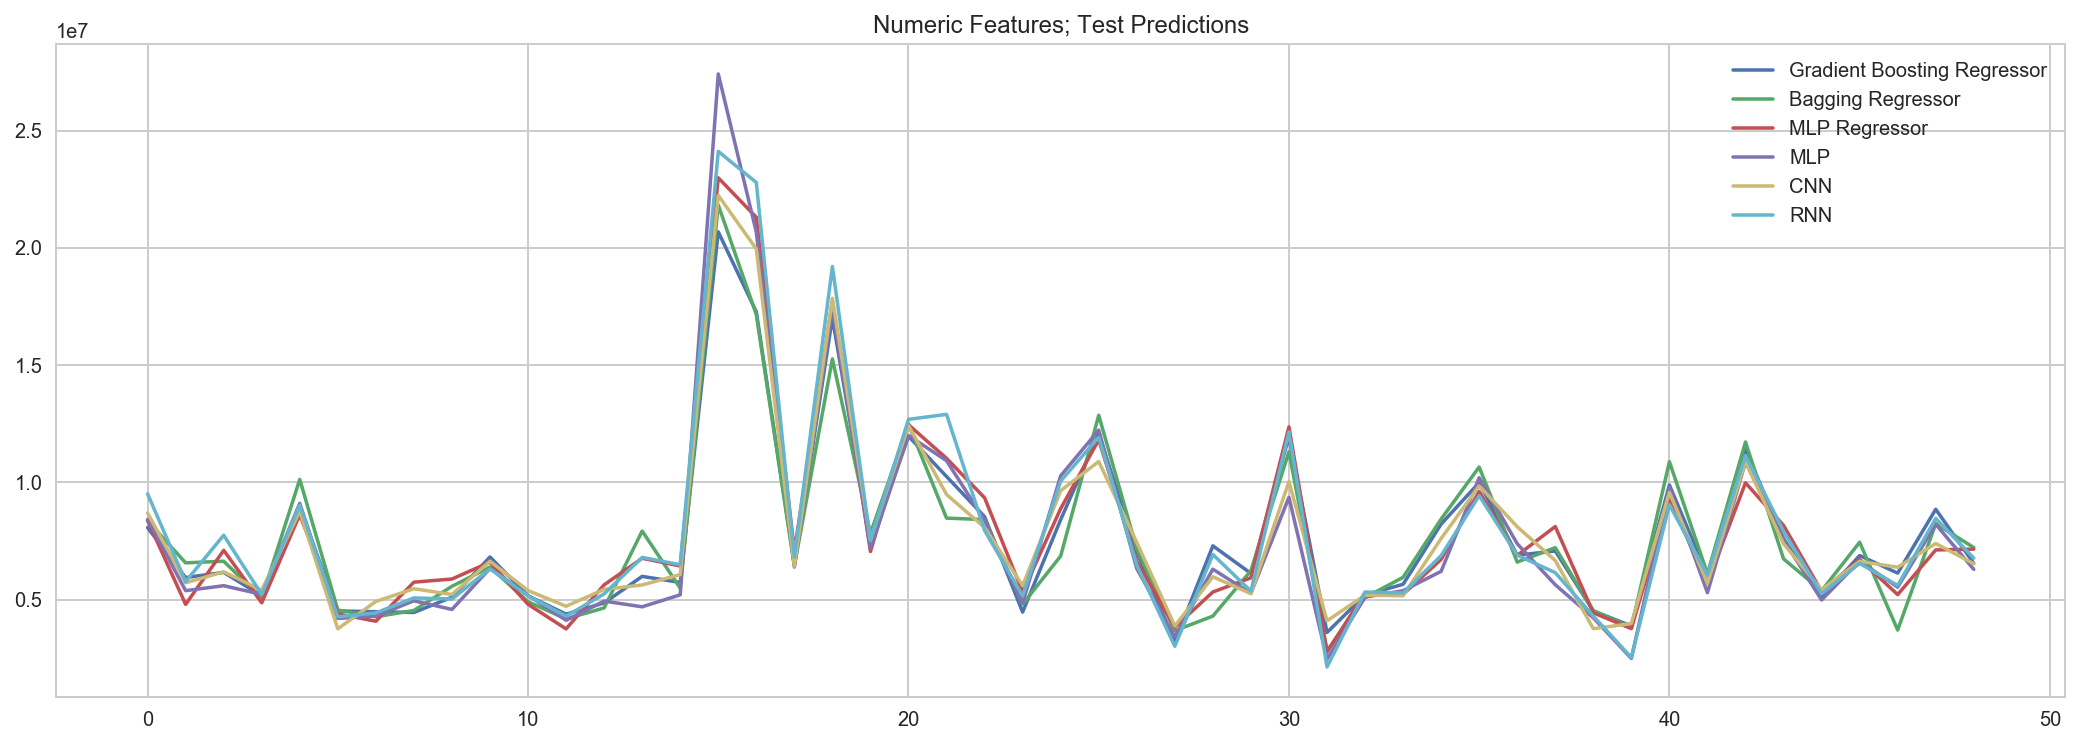

In [121]:
plt.figure(figsize = (18, 6))

plt.plot(target_test_gbr[1:50], label='Gradient Boosting Regressor')
plt.plot(target_test_br[1:50], label='Bagging Regressor')
plt.plot(target_test_mlpr[1:50], label='MLP Regressor')

plt.plot(target_test_mlp[1:50], label='MLP')
plt.plot(target_test_cnn[1:50], label='CNN')
plt.plot(target_test_rnn[1:50], label='RNN')

plt.legend()
plt.title("Numeric Features; Test Predictions");


In [122]:
# Rescale Predictions
target_train_cat_gbr = target_scale.inverse_transform(s_target_train_cat_gbr.reshape(-1,1))
target_test_cat_gbr = target_scale.inverse_transform(s_target_test_cat_gbr.reshape(-1,1))
target_train_cat_br = target_scale.inverse_transform(s_target_train_cat_br.reshape(-1,1))
target_test_cat_br = target_scale.inverse_transform(s_target_test_cat_br.reshape(-1,1))
target_train_cat_mlpr = target_scale.inverse_transform(s_target_train_cat_mlpr.reshape(-1,1))
target_test_cat_mlpr = target_scale.inverse_transform(s_target_test_cat_mlpr.reshape(-1,1))

target_train_cat_mlp = target_scale.inverse_transform(s_target_train_cat_mlp.reshape(-1,1))
target_test_cat_mlp = target_scale.inverse_transform(s_target_test_cat_mlp.reshape(-1,1))
target_train_cat_cnn = target_scale.inverse_transform(s_target_train_cat_cnn.reshape(-1,1))
target_test_cat_cnn = target_scale.inverse_transform(s_target_test_cat_cnn.reshape(-1,1))
target_train_cat_rnn = target_scale.inverse_transform(s_target_train_cat_rnn.reshape(-1,1))
target_test_cat_rnn = target_scale.inverse_transform(s_target_test_cat_rnn.reshape(-1,1))

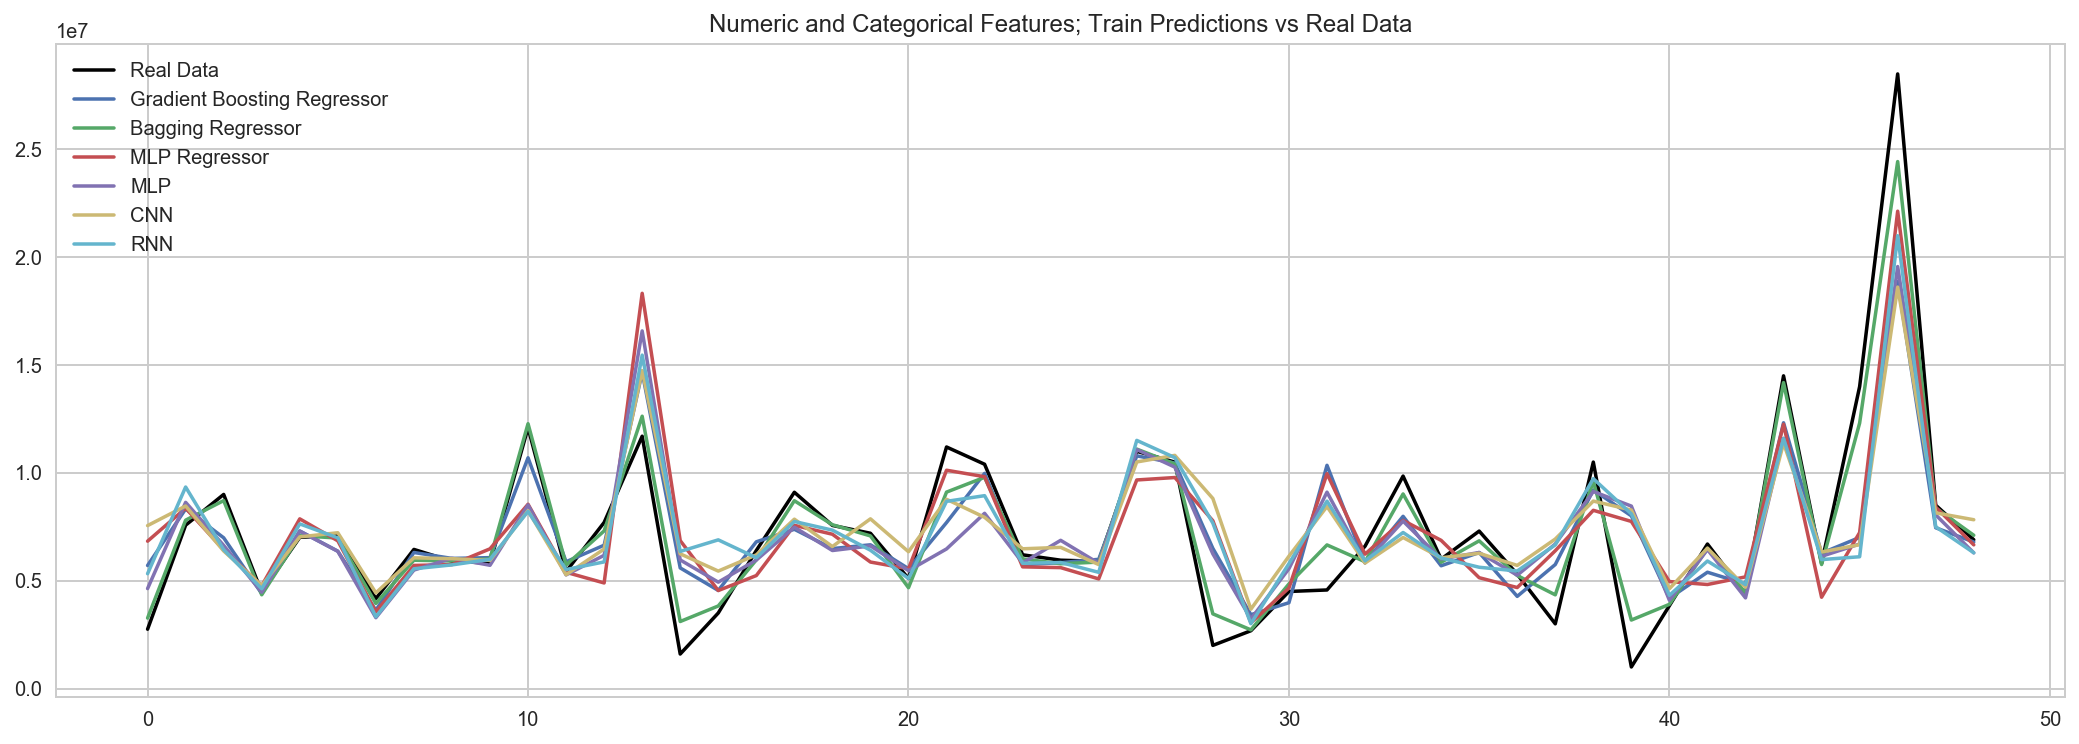

In [123]:
plt.figure(figsize = (18, 6))

plt.plot(target_train[1:50], color = 'black', label='Real Data')

plt.plot(target_train_cat_gbr[1:50], label='Gradient Boosting Regressor')
plt.plot(target_train_cat_br[1:50], label='Bagging Regressor')
plt.plot(target_train_cat_mlpr[1:50], label='MLP Regressor')

plt.plot(target_train_cat_mlp[1:50], label='MLP')
plt.plot(target_train_cat_cnn[1:50], label='CNN')
plt.plot(target_train_cat_rnn[1:50], label='RNN')

plt.legend()
plt.title("Numeric and Categorical Features; Train Predictions vs Real Data");

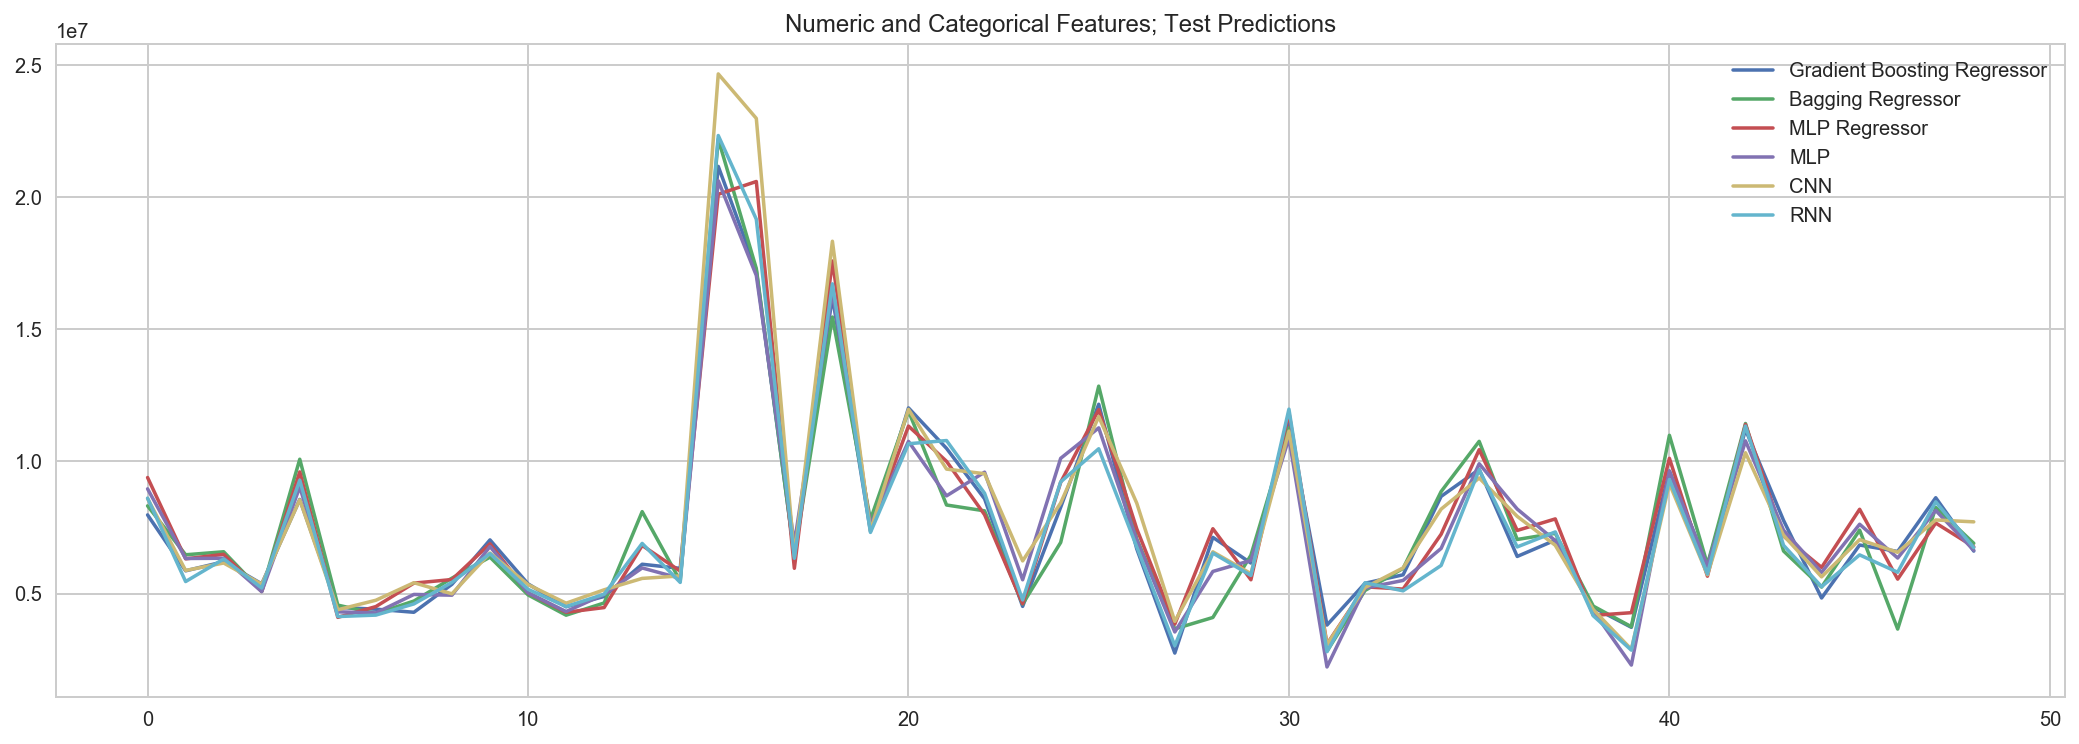

In [124]:
plt.figure(figsize = (18, 6))

plt.plot(target_test_cat_gbr[1:50], label='Gradient Boosting Regressor')
plt.plot(target_test_cat_br[1:50], label='Bagging Regressor')
plt.plot(target_test_cat_mlpr[1:50], label='MLP Regressor')

plt.plot(target_test_cat_mlp[1:50], label='MLP')
plt.plot(target_test_cat_cnn[1:50], label='CNN')
plt.plot(target_test_cat_rnn[1:50], label='RNN')

plt.legend()
plt.title("Numeric and Categorical Features; Test Predictions");

In [125]:
# Rescale Predictions
target_train_cat_enc_gbr = target_scale.inverse_transform(s_target_train_cat_enc_gbr.reshape(-1,1))
target_test_cat_enc_gbr = target_scale.inverse_transform(s_target_test_cat_enc_gbr.reshape(-1,1))
target_train_cat_enc_br = target_scale.inverse_transform(s_target_train_cat_enc_br.reshape(-1,1))
target_test_cat_enc_br = target_scale.inverse_transform(s_target_test_cat_enc_br.reshape(-1,1))
target_train_cat_enc_mlpr = target_scale.inverse_transform(s_target_train_cat_enc_mlpr.reshape(-1,1))
target_test_cat_enc_mlpr = target_scale.inverse_transform(s_target_test_cat_enc_mlpr.reshape(-1,1))

target_train_cat_enc_mlp = target_scale.inverse_transform(s_target_train_cat_enc_mlp.reshape(-1,1))
target_test_cat_enc_mlp = target_scale.inverse_transform(s_target_test_cat_enc_mlp.reshape(-1,1))
target_train_cat_enc_cnn = target_scale.inverse_transform(s_target_train_cat_enc_cnn.reshape(-1,1))
target_test_cat_enc_cnn = target_scale.inverse_transform(s_target_test_cat_enc_cnn.reshape(-1,1))
target_train_cat_enc_rnn = target_scale.inverse_transform(s_target_train_cat_enc_rnn.reshape(-1,1))
target_test_cat_enc_rnn = target_scale.inverse_transform(s_target_test_cat_enc_rnn.reshape(-1,1))

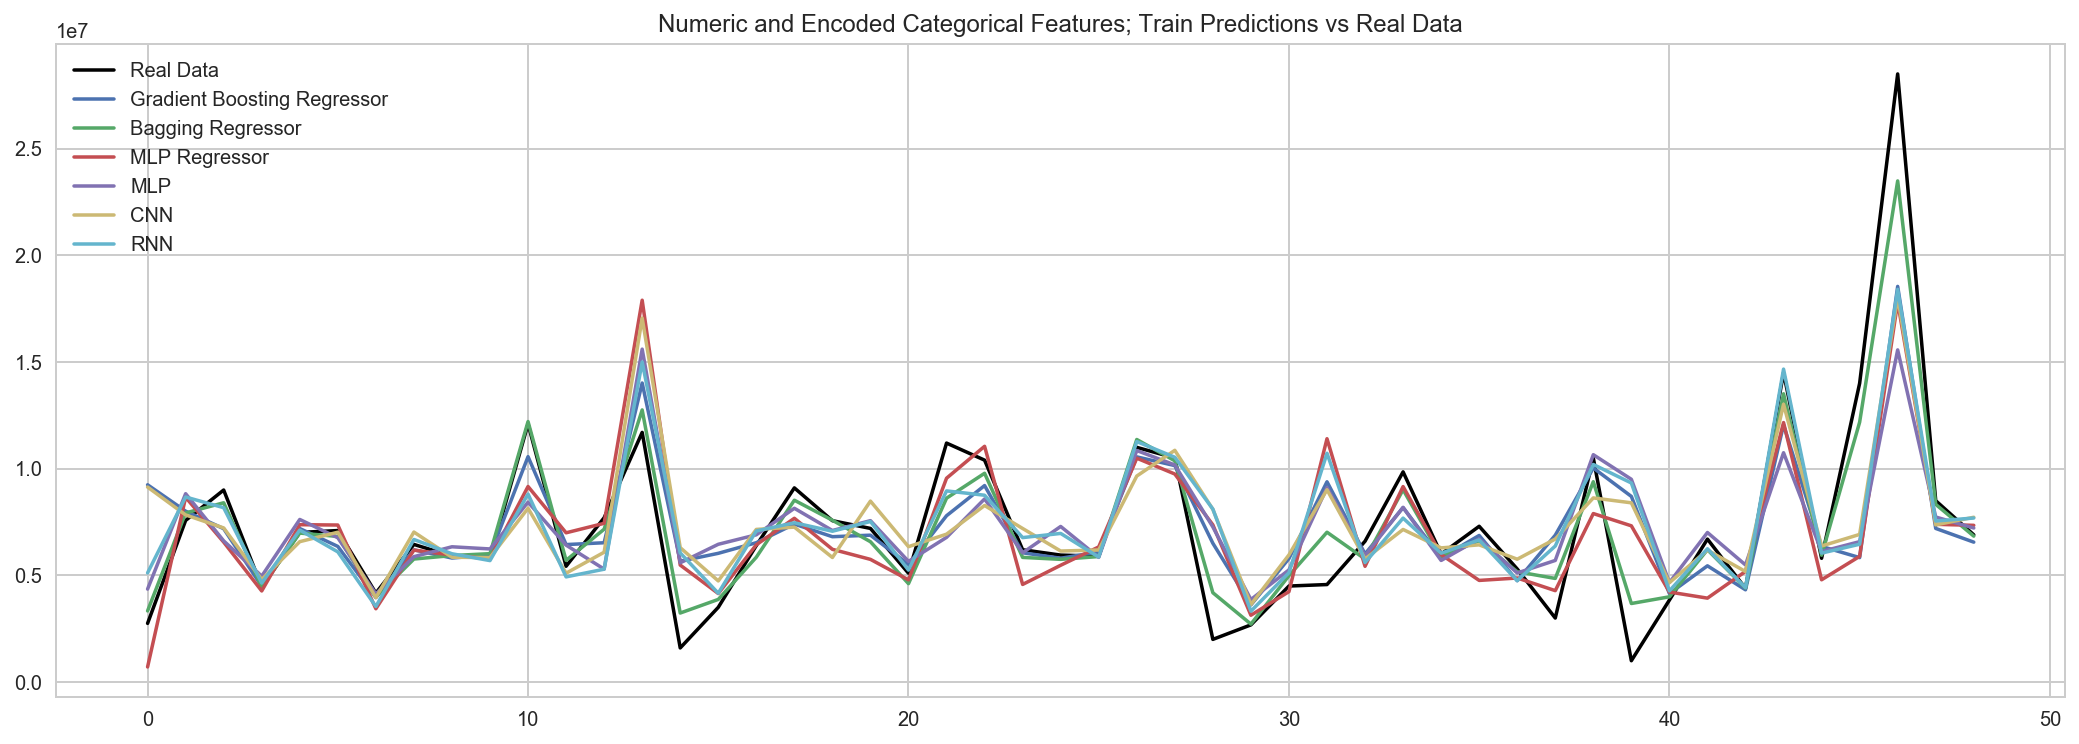

In [126]:
plt.figure(figsize = (18, 6))

plt.plot(target_train[1:50], color = 'black', label='Real Data')

plt.plot(target_train_cat_enc_gbr[1:50], label='Gradient Boosting Regressor')
plt.plot(target_train_cat_enc_br[1:50], label='Bagging Regressor')
plt.plot(target_train_cat_enc_mlpr[1:50], label='MLP Regressor')

plt.plot(target_train_cat_enc_mlp[1:50], label='MLP')
plt.plot(target_train_cat_enc_cnn[1:50], label='CNN')
plt.plot(target_train_cat_enc_rnn[1:50], label='RNN')

plt.legend()
plt.title("Numeric and Encoded Categorical Features; Train Predictions vs Real Data");

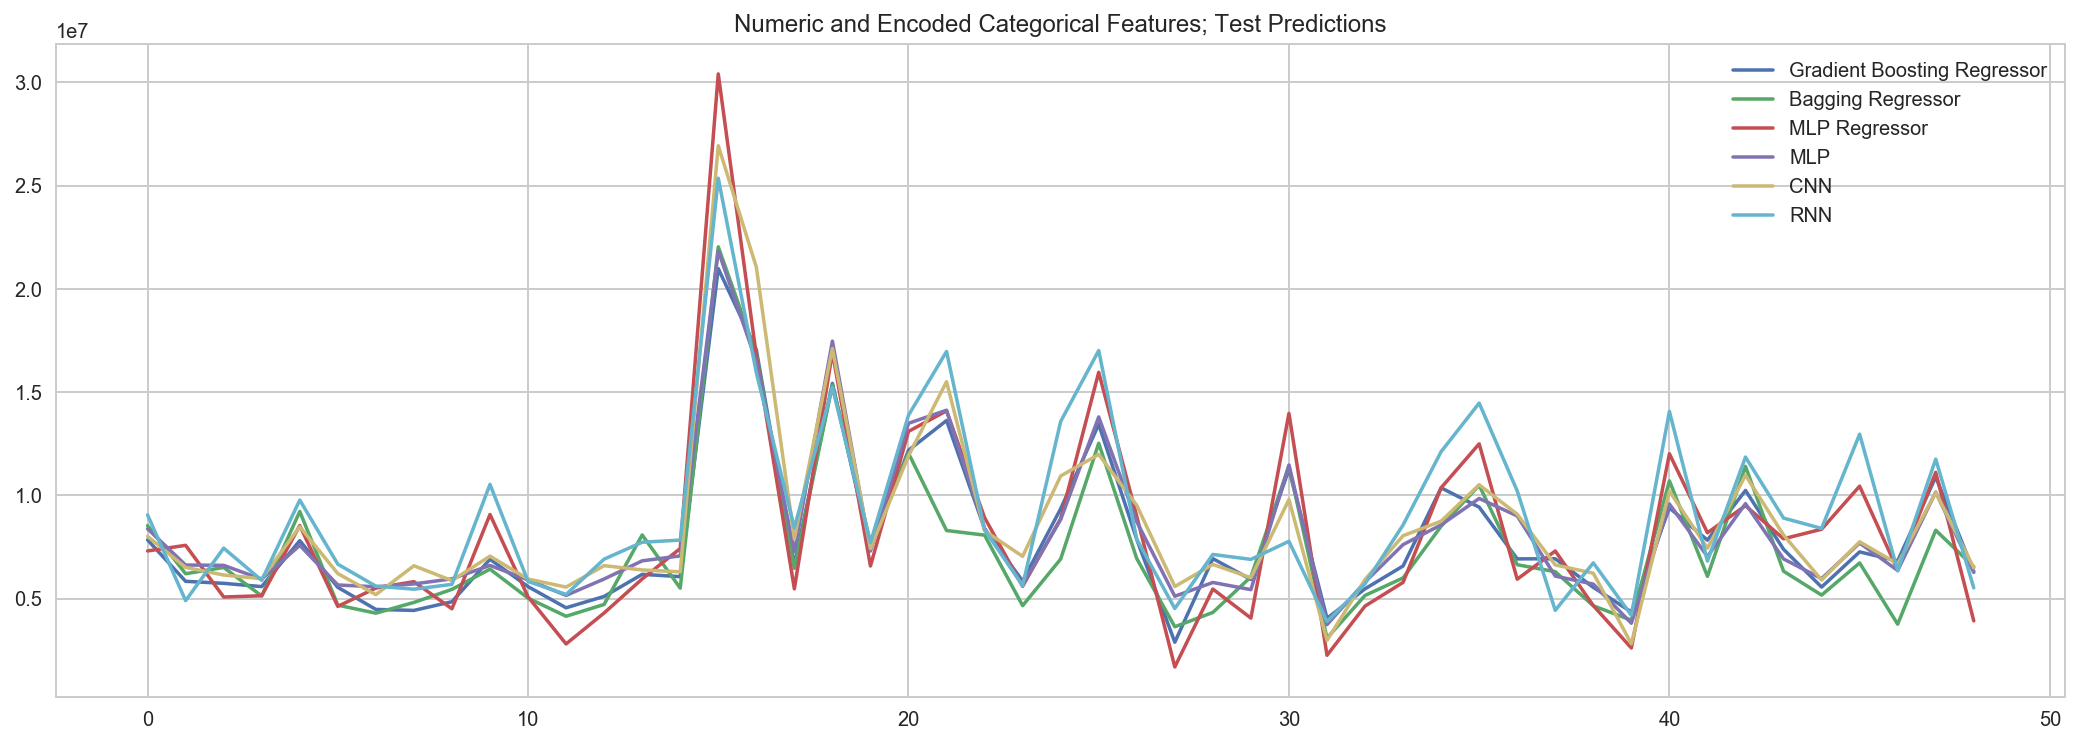

In [127]:
plt.figure(figsize = (18, 6))

plt.plot(target_test_cat_enc_gbr[1:50], label='Gradient Boosting Regressor')
plt.plot(target_test_cat_enc_br[1:50], label='Bagging Regressor')
plt.plot(target_test_cat_enc_mlpr[1:50], label='MLP Regressor')

plt.plot(target_test_cat_enc_mlp[1:50], label='MLP')
plt.plot(target_test_cat_enc_cnn[1:50], label='CNN')
plt.plot(target_test_cat_enc_rnn[1:50], label='RNN')

plt.legend()
plt.title("Numeric and Encoded Categorical Features; Test Predictions");

---
## 7. Submissions
### 7.1 Regressors; Scikit-Learn

In [128]:
target_gbr = ["{0:.2f}".format(x) for x in target_test_gbr.reshape(-1)]

submission_gbr = pd.DataFrame({"id": test['id'], "price_doc": target_gbr})
print(submission_gbr[0:20])

submission_gbr.to_csv('kaggle_sberbank_gbr.csv', index=False)

       id    price_doc
0   30474   6040835.58
1   30475   8072036.41
2   30476   5940948.42
3   30477   6161525.25
4   30478   5165647.97
5   30479   8920643.02
6   30480   4517640.13
7   30481   4484149.79
8   30482   4452378.21
9   30483   5103473.30
10  30484   6818472.29
11  30485   5165647.97
12  30486   4380338.51
13  30487   4859770.91
14  30488   5991468.80
15  30489   5733213.28
16  30490  20681380.38
17  30491  17270791.38
18  30492   6479018.41
19  30493  17013396.50


In [129]:
target_br = ["{0:.2f}".format(x) for x in target_test_br.reshape(-1)]

submission_br = pd.DataFrame({"id": test['id'], "price_doc": target_br})
print(submission_br[0:20])

submission_br.to_csv('kaggle_sberbank_br.csv', index=False)

       id    price_doc
0   30474   5600791.36
1   30475   8361968.69
2   30476   6568198.34
3   30477   6638044.39
4   30478   5065348.15
5   30479  10124819.32
6   30480   4557749.15
7   30481   4270453.69
8   30482   4537075.38
9   30483   5569130.17
10  30484   6388383.65
11  30485   4909037.86
12  30486   4178131.30
13  30487   4647075.86
14  30488   7924204.13
15  30489   5486967.94
16  30490  21830754.35
17  30491  17152973.67
18  30492   6437211.77
19  30493  15266352.72


In [130]:
target_mlpr = ["{0:.2f}".format(x) for x in target_test_mlpr.reshape(-1)]

submission_mlpr = pd.DataFrame({"id": test['id'], "price_doc": target_mlpr})
print(submission_mlpr[0:20])

submission_mlpr.to_csv('kaggle_sberbank_mlpr.csv', index=False)

       id    price_doc
0   30474   4537901.15
1   30475   8372563.84
2   30476   4798155.67
3   30477   7102314.50
4   30478   4864263.89
5   30479   8626580.24
6   30480   4392119.42
7   30481   4079783.18
8   30482   5744739.70
9   30483   5878924.30
10  30484   6598825.50
11  30485   4801546.08
12  30486   3751606.23
13  30487   5631778.33
14  30488   6763013.82
15  30489   6433988.68
16  30490  22987026.92
17  30491  21302605.10
18  30492   7063739.29
19  30493  17711474.06


In [131]:
target_gbr_cat = ["{0:.2f}".format(x) for x in target_test_cat_gbr.reshape(-1)]

submission_gbr_cat = pd.DataFrame({"id": test['id'], "price_doc": target_gbr_cat})
print(submission_gbr_cat[0:20])

submission_gbr_cat.to_csv('kaggle_sberbank_gbr_cat.csv', index=False)

       id    price_doc
0   30474   5912716.65
1   30475   7974392.88
2   30476   5858493.35
3   30477   6202651.00
4   30478   5364302.58
5   30479   8560863.52
6   30480   4473971.05
7   30481   4407103.48
8   30482   4289849.90
9   30483   5348391.08
10  30484   7028558.14
11  30485   5364302.58
12  30486   4500022.76
13  30487   4887658.76
14  30488   6107215.42
15  30489   5952158.54
16  30490  21162121.03
17  30491  17229893.01
18  30492   6451063.59
19  30493  16228805.00


In [132]:
target_br_cat = ["{0:.2f}".format(x) for x in target_test_cat_br.reshape(-1)]

submission_br_cat = pd.DataFrame({"id": test['id'], "price_doc": target_br_cat})
print(submission_br_cat[0:20])

submission_br_cat.to_csv('kaggle_sberbank_br_cat.csv', index=False)

       id    price_doc
0   30474   5686971.95
1   30475   8316598.06
2   30476   6465614.90
3   30477   6579480.26
4   30478   5079301.04
5   30479  10081248.72
6   30480   4560751.29
7   30481   4239751.14
8   30482   4714897.03
9   30483   5581068.40
10  30484   6375975.48
11  30485   4947923.60
12  30486   4179794.85
13  30487   4642047.91
14  30488   8097525.54
15  30489   5473229.88
16  30490  22194878.63
17  30491  17296615.91
18  30492   6447858.51
19  30493  15461981.69


In [133]:
target_mlpr_cat = ["{0:.2f}".format(x) for x in target_test_cat_mlpr.reshape(-1)]

submission_mlpr_cat = pd.DataFrame({"id": test['id'], "price_doc": target_mlpr_cat})
print(submission_mlpr_cat[0:20])

submission_mlpr_cat.to_csv('kaggle_sberbank_mlpr_cat.csv', index=False)

       id    price_doc
0   30474   4819948.59
1   30475   9388439.23
2   30476   6311583.63
3   30477   6482661.68
4   30478   5076371.79
5   30479   9601338.40
6   30480   4097422.23
7   30481   4505549.68
8   30482   5393255.05
9   30483   5528490.41
10  30484   6882820.04
11  30485   5023372.23
12  30486   4290011.37
13  30487   4467911.18
14  30488   6818560.14
15  30489   5847630.71
16  30490  20108200.99
17  30491  20590669.37
18  30492   5953733.23
19  30493  17583144.41


In [134]:
target_gbr_cat_enc = ["{0:.2f}".format(x) for x in target_test_cat_enc_gbr.reshape(-1)]

submission_gbr_cat_enc = pd.DataFrame({"id": test['id'], "price_doc": target_gbr_cat_enc})
print(submission_gbr_cat_enc[0:20])

submission_gbr_cat_enc.to_csv('kaggle_sberbank_gbr_cat_enc.csv', index=False)

       id    price_doc
0   30474   5948800.73
1   30475   7846955.09
2   30476   5842330.01
3   30477   5744159.23
4   30478   5585856.24
5   30479   7809837.60
6   30480   5550427.52
7   30481   4481368.53
8   30482   4433156.09
9   30483   4854506.26
10  30484   6910499.09
11  30485   5585856.24
12  30486   4560513.45
13  30487   5109981.63
14  30488   6180068.25
15  30489   6067358.28
16  30490  20982581.73
17  30491  17050385.04
18  30492   6625461.06
19  30493  15427405.28


In [135]:
target_br_cat_enc = ["{0:.2f}".format(x) for x in target_test_cat_enc_br.reshape(-1)]

submission_br_cat_enc = pd.DataFrame({"id": test['id'], "price_doc": target_br_cat_enc})
print(submission_br_cat_enc[0:20])

submission_br_cat_enc.to_csv('kaggle_sberbank_br_cat_enc.csv', index=False)

       id    price_doc
0   30474   5542519.70
1   30475   8542405.20
2   30476   6209650.92
3   30477   6513228.61
4   30478   5130991.92
5   30479   9223791.22
6   30480   4688339.93
7   30481   4300009.21
8   30482   4819473.84
9   30483   5452580.11
10  30484   6431714.60
11  30485   5028826.49
12  30486   4150187.74
13  30487   4722238.08
14  30488   8088037.69
15  30489   5512005.96
16  30490  22037583.43
17  30491  16852140.89
18  30492   6470971.87
19  30493  15349355.82


In [136]:
target_mlpr_cat_enc = ["{0:.2f}".format(x) for x in target_test_cat_enc_mlpr.reshape(-1)]

submission_mlpr_cat_enc = pd.DataFrame({"id": test['id'], "price_doc": target_mlpr_cat_enc})
print(submission_mlpr_cat_enc[0:20])

submission_mlpr_cat_enc.to_csv('kaggle_sberbank_mlpr_cat_enc.csv', index=False)

       id    price_doc
0   30474   5487337.84
1   30475   7313022.58
2   30476   7584364.53
3   30477   5081928.75
4   30478   5142982.45
5   30479   8539228.46
6   30480   4628334.45
7   30481   5516185.54
8   30482   5825363.35
9   30483   4512560.21
10  30484   9076288.23
11  30485   5090095.49
12  30486   2809555.76
13  30487   4309582.96
14  30488   5956866.79
15  30489   7430420.69
16  30490  30410626.15
17  30491  16784170.08
18  30492   5478261.64
19  30493  16936985.40


### 7.2 Neural Networks; Keras

In [137]:
target_mlp = ["{0:.2f}".format(x) for x in target_test_mlp.reshape(-1)]

submission_mlp = pd.DataFrame({"id": test['id'], "price_doc": target_mlp})
print(submission_mlp[0:20])

submission_mlp.to_csv('kaggle_sberbank_mlp.csv', index=False)

       id    price_doc
0   30474   5376716.00
1   30475   8421092.00
2   30476   5382682.00
3   30477   5593360.00
4   30478   5224266.00
5   30479   9105084.00
6   30480   4199799.00
7   30481   4298073.50
8   30482   4951228.00
9   30483   4582320.50
10  30484   6330828.50
11  30485   5179838.00
12  30486   4120875.50
13  30487   4937351.00
14  30488   4694134.50
15  30489   5205119.50
16  30490  27416182.00
17  30491  20674322.00
18  30492   6389120.00
19  30493  17434500.00


In [138]:
target_cnn = ["{0:.2f}".format(x) for x in target_test_cnn.reshape(-1)]

submission_cnn = pd.DataFrame({"id": test['id'], "price_doc": target_cnn})
print(submission_cnn[0:20])

submission_cnn.to_csv('kaggle_sberbank_cnn.csv', index=False)

       id    price_doc
0   30474   5546415.00
1   30475   8692826.00
2   30476   5718079.50
3   30477   6186291.00
4   30478   5402433.00
5   30479   8770521.00
6   30480   3755831.75
7   30481   4922126.50
8   30482   5464379.00
9   30483   5219245.00
10  30484   6637870.00
11  30485   5388213.00
12  30486   4718509.50
13  30487   5438425.00
14  30488   5625787.00
15  30489   6067875.50
16  30490  22237340.00
17  30491  19950900.00
18  30492   6429827.00
19  30493  17847342.00


In [139]:
target_rnn = ["{0:.2f}".format(x) for x in target_test_rnn.reshape(-1)]

submission_rnn = pd.DataFrame({"id": test['id'], "price_doc": target_cnn})
print(submission_rnn[0:20])

submission_rnn.to_csv('kaggle_sberbank_rnn.csv', index=False)

       id    price_doc
0   30474   5546415.00
1   30475   8692826.00
2   30476   5718079.50
3   30477   6186291.00
4   30478   5402433.00
5   30479   8770521.00
6   30480   3755831.75
7   30481   4922126.50
8   30482   5464379.00
9   30483   5219245.00
10  30484   6637870.00
11  30485   5388213.00
12  30486   4718509.50
13  30487   5438425.00
14  30488   5625787.00
15  30489   6067875.50
16  30490  22237340.00
17  30491  19950900.00
18  30492   6429827.00
19  30493  17847342.00


In [140]:
target_mlp_cat = ["{0:.2f}".format(x) for x in target_test_cat_mlp.reshape(-1)]

submission_mlp_cat = pd.DataFrame({"id": test['id'], "price_doc": target_mlp_cat})
print(submission_mlp_cat[0:20])

submission_mlp_cat.to_csv('kaggle_sberbank_mlp_cat.csv', index=False)

       id    price_doc
0   30474   5791398.50
1   30475   8960279.00
2   30476   6325069.00
3   30477   6333821.00
4   30478   5070839.50
5   30479   9031646.00
6   30480   4306202.00
7   30481   4265964.50
8   30482   4964341.00
9   30483   4936940.50
10  30484   6777067.50
11  30485   5024926.50
12  30486   4317978.00
13  30487   4965258.00
14  30488   5966916.50
15  30489   5574628.00
16  30490  20617850.00
17  30491  17035660.00
18  30492   6884737.50
19  30493  16429780.00


In [141]:
target_cnn_cat = ["{0:.2f}".format(x) for x in target_test_cat_cnn.reshape(-1)]

submission_cnn_cat = pd.DataFrame({"id": test['id'], "price_doc": target_cnn_cat})
print(submission_cnn_cat[0:20])

submission_cnn_cat.to_csv('kaggle_sberbank_cnn_cat.csv', index=False)

       id    price_doc
0   30474   5756297.00
1   30475   8592417.00
2   30476   5872788.00
3   30477   6153985.50
4   30478   5353383.00
5   30479   8545409.00
6   30480   4386547.00
7   30481   4744909.00
8   30482   5408512.00
9   30483   4988338.00
10  30484   6530310.00
11  30485   5337154.50
12  30486   4633907.00
13  30487   5140162.00
14  30488   5571628.50
15  30489   5665645.50
16  30490  24661556.00
17  30491  22978944.00
18  30492   6394977.50
19  30493  18330088.00


In [142]:
target_rnn_cat = ["{0:.2f}".format(x) for x in target_test_cat_rnn.reshape(-1)]

submission_rnn_cat = pd.DataFrame({"id": test['id'], "price_doc": target_cnn_cat})
print(submission_rnn_cat[0:20])

submission_rnn_cat.to_csv('kaggle_sberbank_rnn_cat.csv', index=False)

       id    price_doc
0   30474   5756297.00
1   30475   8592417.00
2   30476   5872788.00
3   30477   6153985.50
4   30478   5353383.00
5   30479   8545409.00
6   30480   4386547.00
7   30481   4744909.00
8   30482   5408512.00
9   30483   4988338.00
10  30484   6530310.00
11  30485   5337154.50
12  30486   4633907.00
13  30487   5140162.00
14  30488   5571628.50
15  30489   5665645.50
16  30490  24661556.00
17  30491  22978944.00
18  30492   6394977.50
19  30493  18330088.00


In [143]:
target_mlp_cat_enc = ["{0:.2f}".format(x) for x in target_test_cat_enc_mlp.reshape(-1)]

submission_mlp_cat_enc = pd.DataFrame({"id": test['id'], "price_doc": target_mlp_cat_enc})
print(submission_mlp_cat_enc[0:20])

submission_mlp_cat_enc.to_csv('kaggle_sberbank_mlp_cat_enc.csv', index=False)

       id    price_doc
0   30474   5360488.00
1   30475   8384932.50
2   30476   6630569.00
3   30477   6615604.50
4   30478   5945434.00
5   30479   7583406.00
6   30480   5664892.50
7   30481   5577127.00
8   30482   5715783.00
9   30483   5961407.50
10  30484   6610890.50
11  30485   5912065.50
12  30486   5160693.00
13  30487   5955565.00
14  30488   6833825.50
15  30489   7072624.50
16  30490  21844736.00
17  30491  16479899.00
18  30492   7269341.00
19  30493  17472888.00


In [144]:
target_cnn_cat_enc = ["{0:.2f}".format(x) for x in target_test_cat_enc_cnn.reshape(-1)]

submission_cnn_cat_enc = pd.DataFrame({"id": test['id'], "price_doc": target_cnn_cat_enc})
print(submission_cnn_cat_enc[0:20])

submission_cnn_cat_enc.to_csv('kaggle_sberbank_cnn_cat_enc.csv', index=False)

       id    price_doc
0   30474   5411044.00
1   30475   8017171.00
2   30476   6516236.50
3   30477   6147025.50
4   30478   5968458.00
5   30479   8483004.00
6   30480   6216253.50
7   30481   5196970.50
8   30482   6596386.00
9   30483   5876670.50
10  30484   7061481.00
11  30485   5950888.00
12  30486   5562962.00
13  30487   6600395.50
14  30488   6392657.50
15  30489   6299242.50
16  30490  26935144.00
17  30491  21061264.00
18  30492   7896723.00
19  30493  17118060.00


In [145]:
target_rnn_cat_enc = ["{0:.2f}".format(x) for x in target_test_cat_enc_rnn.reshape(-1)]

submission_rnn_cat_enc = pd.DataFrame({"id": test['id'], "price_doc": target_cnn_cat_enc})
print(submission_rnn_cat_enc[0:20])

submission_rnn_cat_enc.to_csv('kaggle_sberbank_rnn_cat_enc.csv', index=False)

       id    price_doc
0   30474   5411044.00
1   30475   8017171.00
2   30476   6516236.50
3   30477   6147025.50
4   30478   5968458.00
5   30479   8483004.00
6   30480   6216253.50
7   30481   5196970.50
8   30482   6596386.00
9   30483   5876670.50
10  30484   7061481.00
11  30485   5950888.00
12  30486   5562962.00
13  30487   6600395.50
14  30488   6392657.50
15  30489   6299242.50
16  30490  26935144.00
17  30491  21061264.00
18  30492   7896723.00
19  30493  17118060.00


[kaggle.com](https://www.kaggle.com/c/sberbank-russian-housing-market)